# EE610 - Image Processing
## Assignment 4
## Dadi Dharani 20D070023

In [ ]:
#importing useful libraries
import cv2
%matplotlib inline
import torch
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50,15)

import numpy as np

import os
import sys
import random
import tensorflow as tf


from tensorflow import keras
## Seeding
seed = 2022
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
from google.colab import drive #Mounting to the user's Gdrive to extract Data
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Study the challenge statement of MoNuSeg challenge, read the data and display a few training and testing images and their masks (black background, and a random color for each cell nucleus).

## Data Generator
### We define a class DataGen which can read the image data from the folders: tissue-images and binary-mask given the path to the Training set or Testing set.
### It can divide the data into the desired batch sizes and also split the dataset into training and validation data
### Credits to https://www.youtube.com/watch?v=M3EZS__Z_XE

In [ ]:
#Defining our Class
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=3, image_size=256): #Constructor of the Class
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name): #__load__ function loads an image into the data batch given it's id_name
        ## Path
        image_path = os.path.join(self.path,"Tissue-Images", id_name) #Given a path, it will look into the folder Tissue-images and load the path to the image with the desired id_name
        mask_path = os.path.join(self.path,"Binary-Mask",id_name) #Given a path, it will look into the folder Binary-Mask and load the path to the Mask with the desired id_name

        ## Reading Image
        image = cv2.imread(image_path, 1) #Reads the image in RGB
        image = cv2.resize(image, (self.image_size, self.image_size)) #Resizes to the image to the desired size (desired as a power of 2)

        mask = cv2.imread(mask_path, 0) #Reads the image as Greyscale
        mask = cv2.resize(mask, (self.image_size, self.image_size))  #Resizes to the image to the desired size (desired as a power of 2)


        ## Normalizaing
        image = image/255.0
        mask = mask/255.0

        return image, mask #Return the image and mask to be added to our data batch

    def __getitem__(self, index): #__get__item function returns an entire batch loaded from the desired folder
        if(index+1)*self.batch_size > len(self.ids): #If batch size doesn't exactly divide number of given ids for training, then use the remainder in one batch
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size] #Selecting the ids from the folder

        image = []
        mask  = []

        for id_name in files_batch: #Loop to load all images and masks in a batch into one data structure
            _img, _mask = self.__load__(id_name) #Calls the load() function to add image and mask of given id_name into the batch
            image.append(_img)
            mask.append(_mask)

        #Converting image and mask batch to numpy arrays
        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self): #Funtion to stop Data generation on end of epochs
        pass

    def __len__(self): #Function to find number of batches in a data set
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyper Parameters

In [ ]:
#Training and Validation Dataset
image_size = 256 #Setting Image size to 256

train_path = "/content/drive/MyDrive/MoNuSeg-Training-Data/" #Before running this notebook, make sure that the MoNuSeg-Training-Data folder is added to MyDrive as a shortcut
epochs = 5 #Number of epochs is set to 5, more epochs lead to better training and fitting of parameters
batch_size = 1 #Batch size is kept as 1 and the training set is small with only 24 unique data points

## Training Ids
train_ids = next(os.walk(train_path+"Binary-Mask/"))[2]
print(train_ids)
## Validation Data Size
val_data_size = 6

valid_ids = train_ids[:val_data_size] #Validation set Ids
train_ids = train_ids[val_data_size:] #Training set Ids

['TCGA-18-5592-01Z-00-DX1.png', 'TCGA-21-5784-01Z-00-DX1.png', 'TCGA-21-5786-01Z-00-DX1.png', 'TCGA-38-6178-01Z-00-DX1.png', 'TCGA-49-4488-01Z-00-DX1.png', 'TCGA-50-5931-01Z-00-DX1.png', 'TCGA-A7-A13E-01Z-00-DX1.png', 'TCGA-A7-A13F-01Z-00-DX1.png', 'TCGA-AR-A1AK-01Z-00-DX1.png', 'TCGA-AR-A1AS-01Z-00-DX1.png', 'TCGA-AY-A8YK-01A-01-TS1.png', 'TCGA-B0-5698-01Z-00-DX1.png', 'TCGA-B0-5710-01Z-00-DX1.png', 'TCGA-B0-5711-01Z-00-DX1.png', 'TCGA-CH-5767-01Z-00-DX1.png', 'TCGA-DK-A2I6-01A-01-TS1.png', 'TCGA-E2-A1B5-01Z-00-DX1.png', 'TCGA-E2-A14V-01Z-00-DX1.png', 'TCGA-G2-A2EK-01A-02-TSB.png', 'TCGA-G9-6336-01Z-00-DX1.png', 'TCGA-G9-6348-01Z-00-DX1.png', 'TCGA-G9-6356-01Z-00-DX1.png', 'TCGA-G9-6362-01Z-00-DX1.png', 'TCGA-G9-6363-01Z-00-DX1.png', 'TCGA-HE-7128-01Z-00-DX1.png', 'TCGA-HE-7129-01Z-00-DX1.png', 'TCGA-HE-7130-01Z-00-DX1.png', 'TCGA-KB-A93J-01A-01-TS1.png', 'TCGA-NH-A8F7-01A-01-TS1.png', 'TCGA-RD-A8N9-01A-01-TS1.png']


In [ ]:
#Testing Dataset
image_size = 256 #Setting Image size to 256
test_path = "/content/drive/MyDrive/MoNuSeg-Test-Data/" #Before running this notebook, make sure that the MoNuSeg-Test-Data folder is added to MyDrive as a shortcut
epochs = 5 #Number of epochs is set to 5, more epochs lead to better training and fitting of parameters
batch_size = 1 #Batch size is kept as 1 and the training set is small with only 24 unique data points

## Testing Ids
test_ids = next(os.walk(test_path+"Binary-Mask/"))[2]
print(test_ids)


['TCGA-2Z-A9J9-01A-01-TS1.png', 'TCGA-44-2665-01B-06-BS6.png', 'TCGA-69-7764-01A-01-TS1.png', 'TCGA-A6-6782-01A-01-BS1.png', 'TCGA-AC-A2FO-01A-01-TS1.png', 'TCGA-AO-A0J2-01A-01-BSA.png', 'TCGA-CU-A0YN-01A-02-BSB.png', 'TCGA-EJ-A46H-01A-03-TSC.png', 'TCGA-FG-A4MU-01B-01-TS1.png', 'TCGA-GL-6846-01A-01-BS1.png', 'TCGA-HC-7209-01A-01-TS1.png', 'TCGA-HT-8564-01Z-00-DX1.png', 'TCGA-IZ-8196-01A-01-BS1.png', 'TCGA-ZF-A9R5-01A-01-TS1.png']


In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size) #Generating the Training Dataset using the class DataGen
x1, y1 = gen.__getitem__(0) #Loading an image and mask batch from the data set
print(x1.shape, y1.shape)

(1, 256, 256, 3) (1, 256, 256)


In [ ]:
x2, y2 = gen.__getitem__(1) #Loading an image and mask batch from the data set
print(x2.shape, y2.shape)

(1, 256, 256, 3) (1, 256, 256)


In [ ]:
gen = DataGen(test_ids, test_path, batch_size=batch_size, image_size=image_size)  #Generating the Testing Dataset using the class DataGen
x_t1, y_t1 = gen.__getitem__(0)
print(x_t1.shape, y_t1.shape)

(1, 256, 256, 3) (1, 256, 256)


In [ ]:
x_t2, y_t2 = gen.__getitem__(1) #Loading an image and mask batch from the data set
print(x_t2.shape, y_t2.shape)

(1, 256, 256, 3) (1, 256, 256)


## Display a few training and testing images and their masks

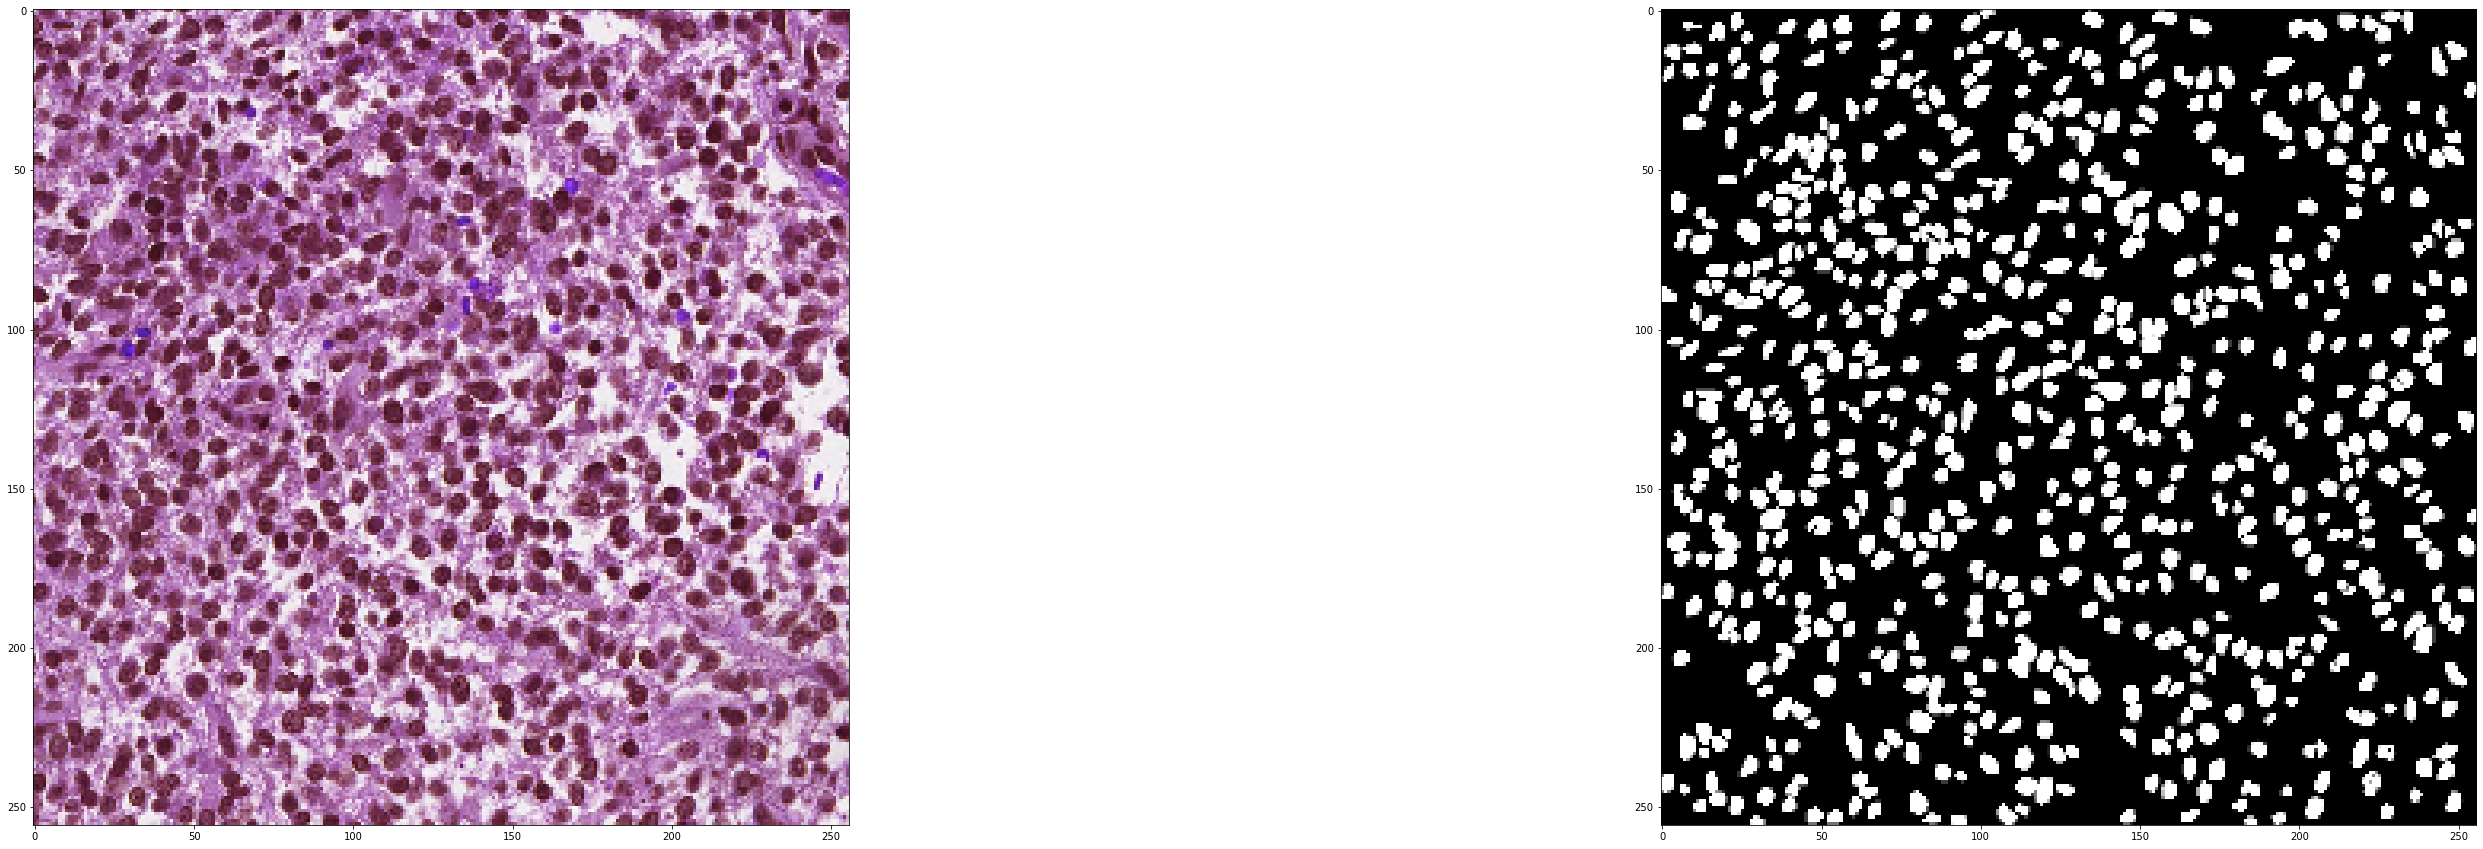

In [ ]:
#Displaying Training Image 1 and its binary mask

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x1[0])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y1[0], (image_size, image_size)), cmap="gray")

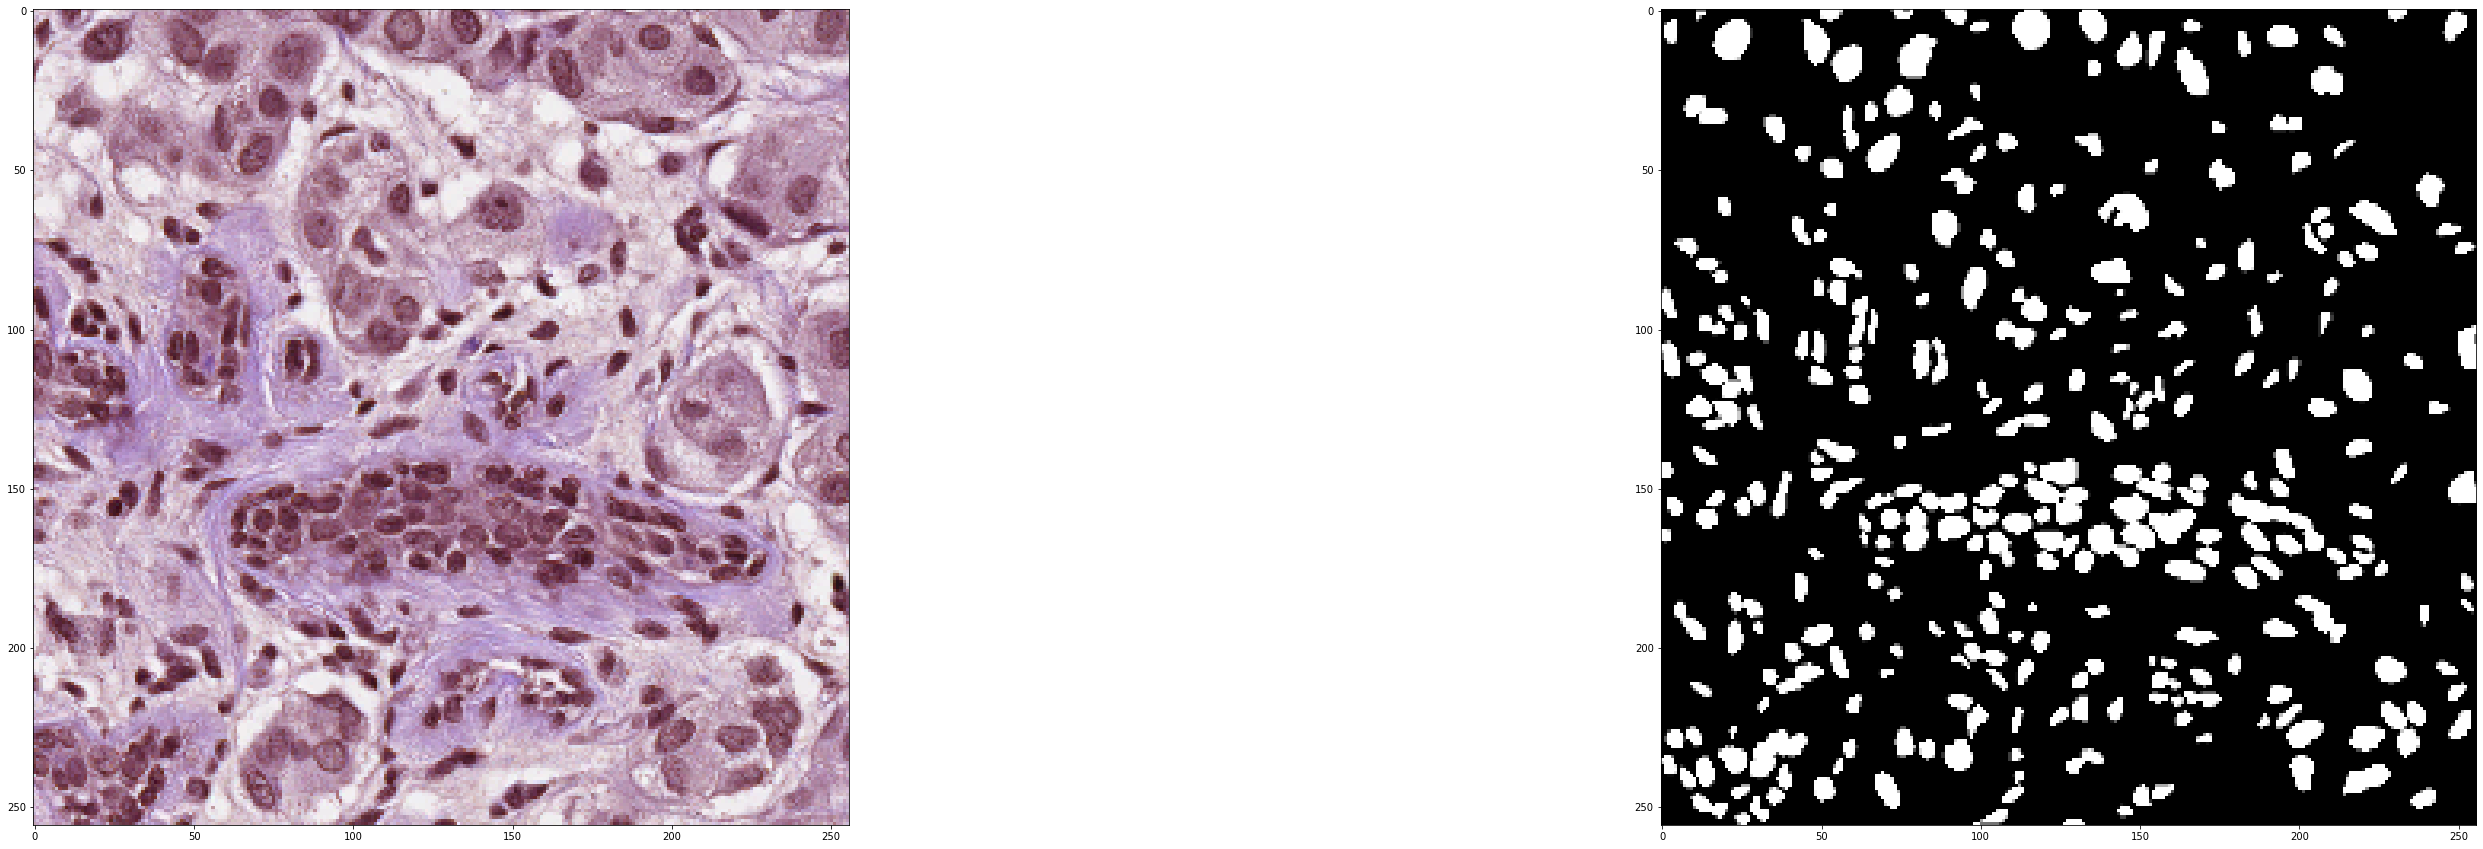

In [ ]:
#Displaying Training Image 2 and its binary mask

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x2[0])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y2[0], (image_size, image_size)), cmap="gray")

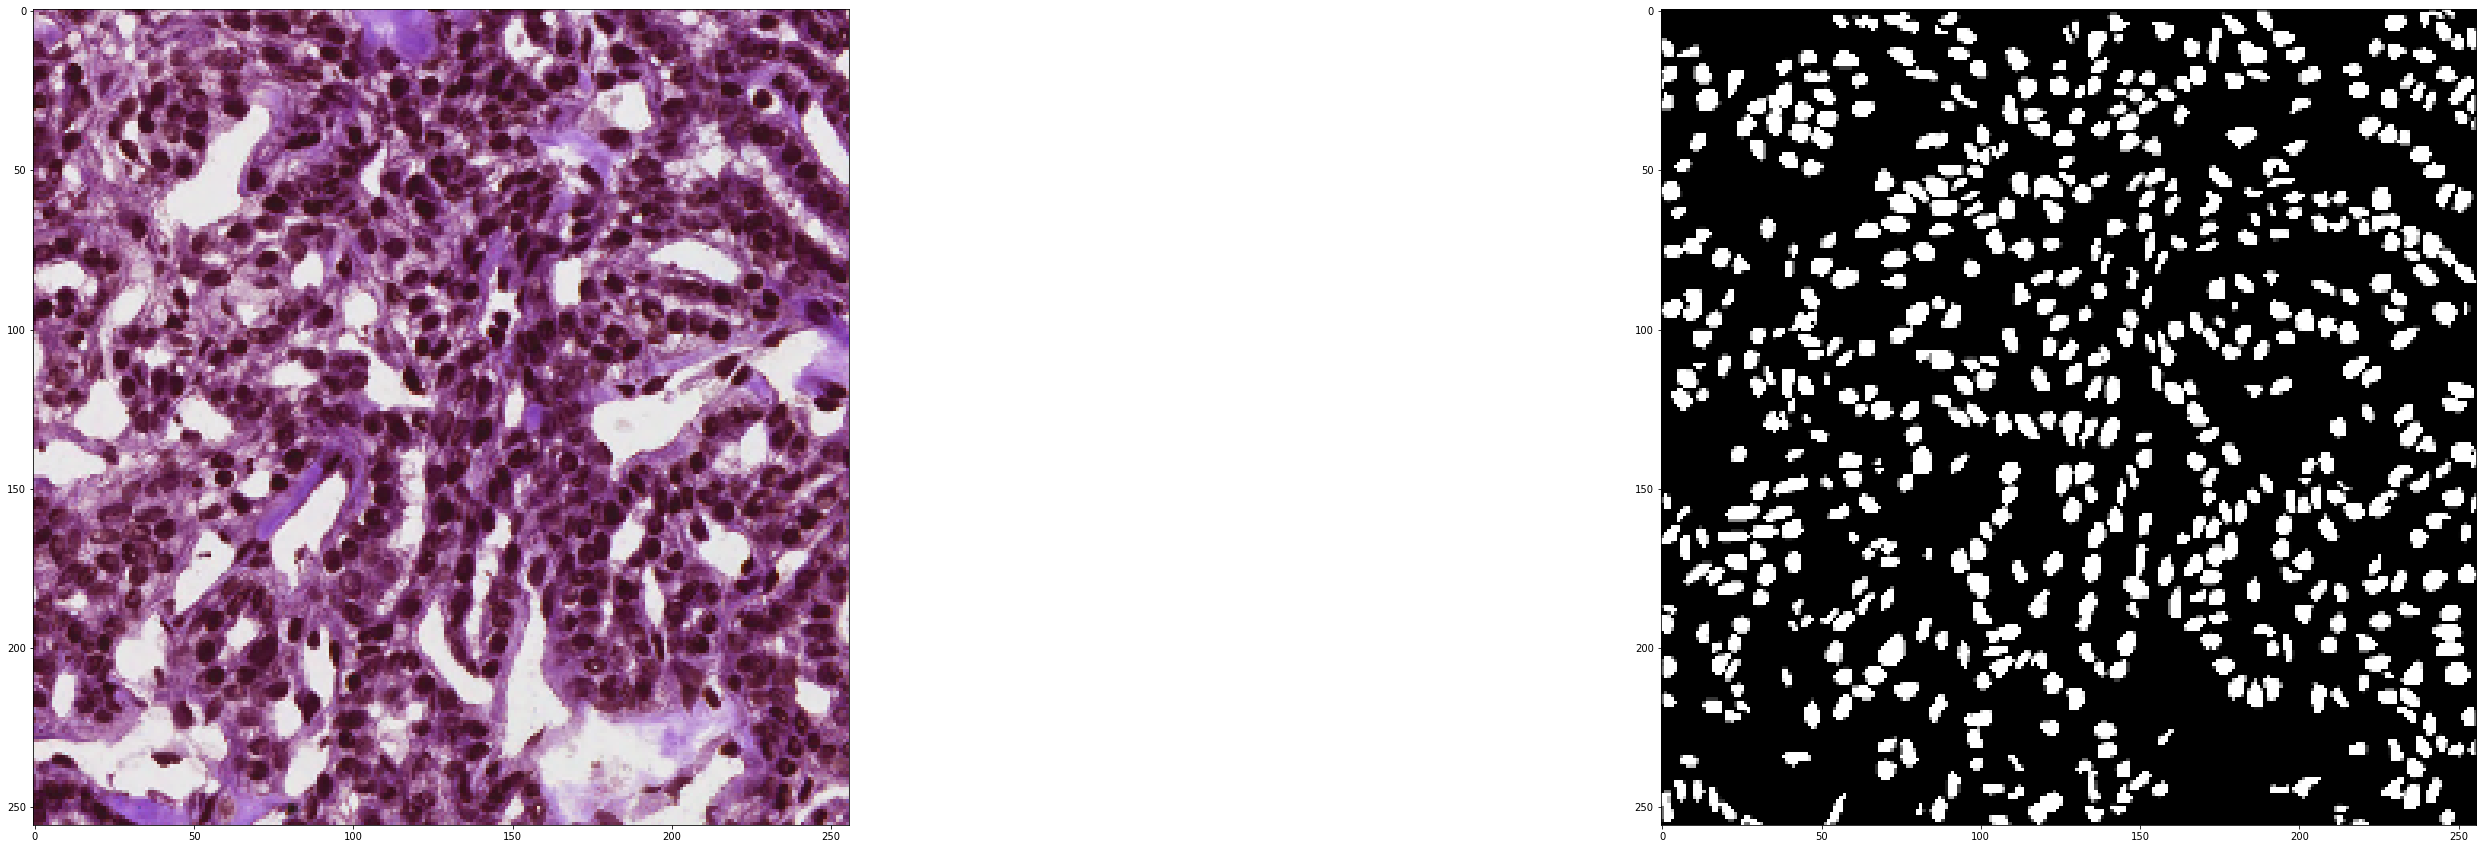

In [ ]:
#Displaying Testing Image 1 and its binary mask

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x_t1[0])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y_t1[0], (image_size, image_size)), cmap="gray")

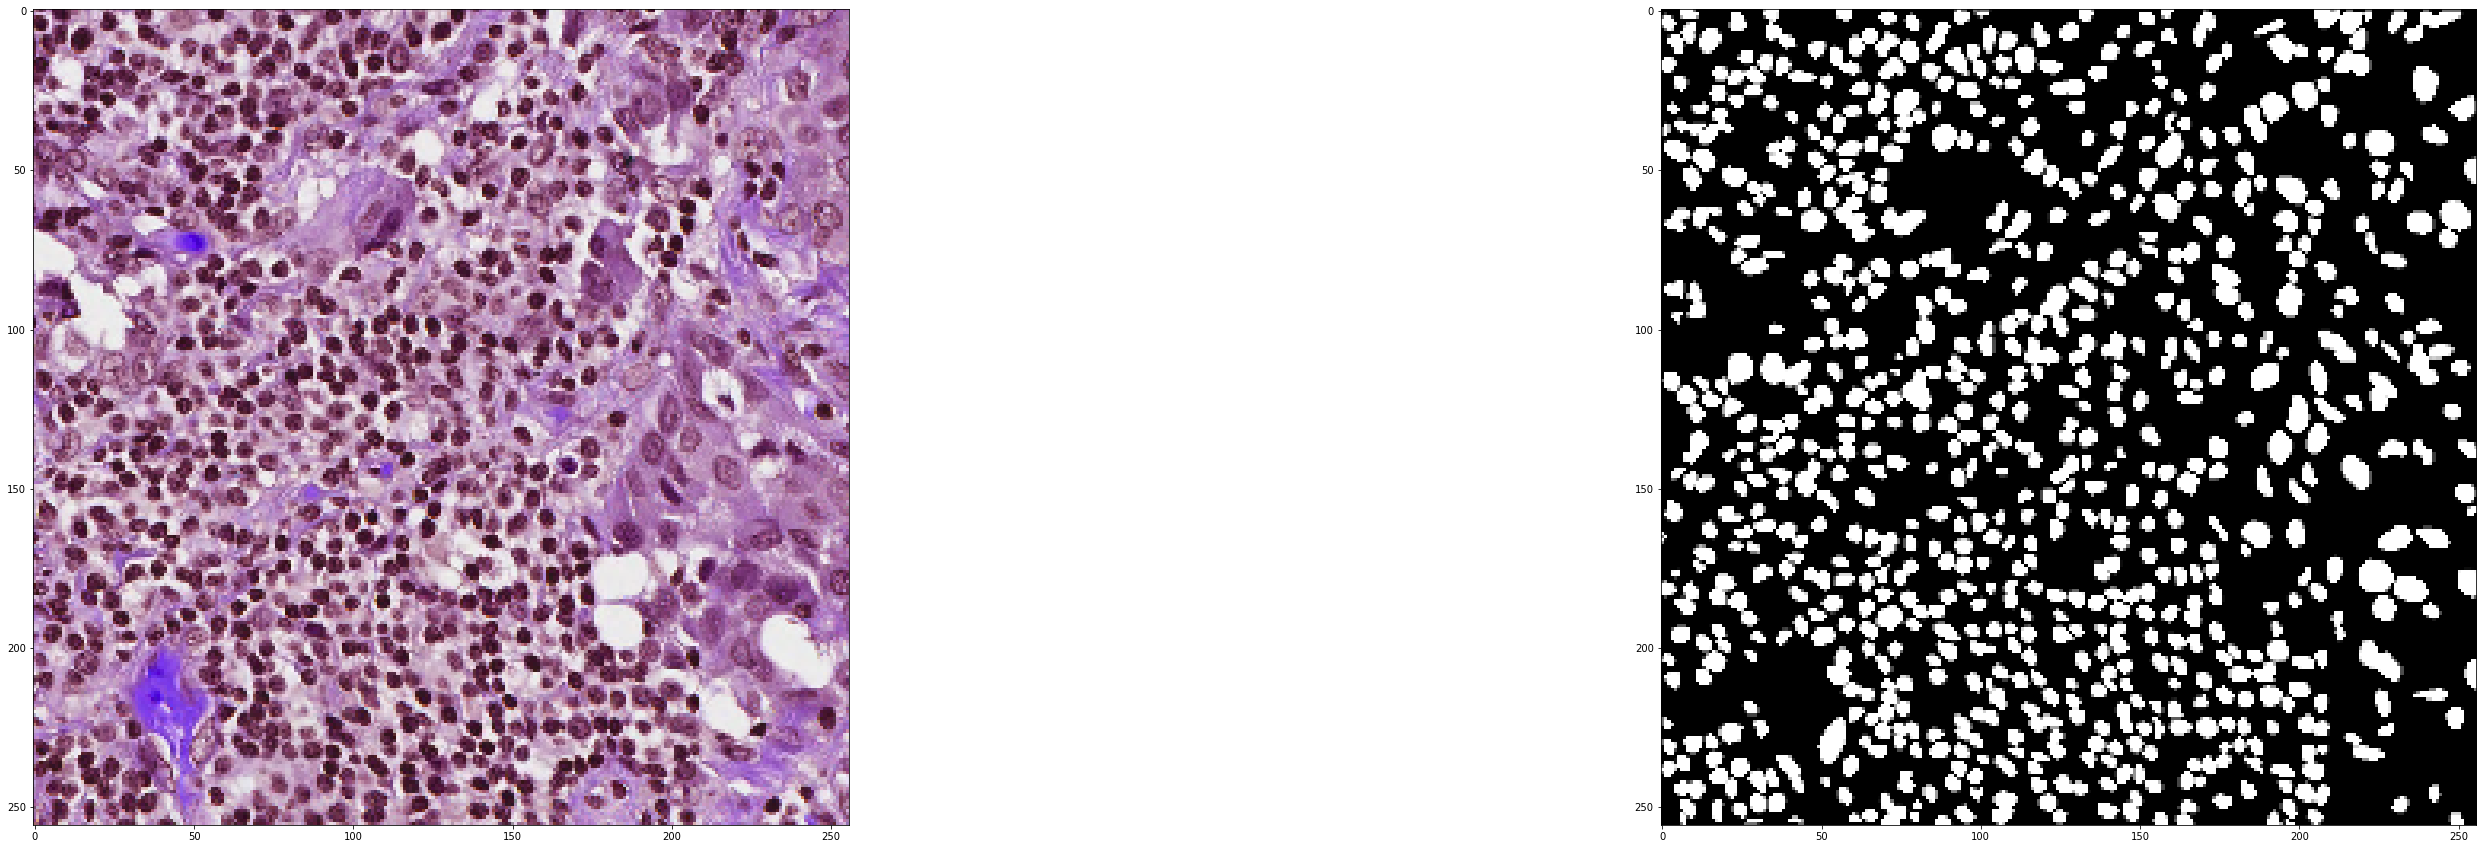

In [ ]:
#Displaying Testing Image 2 and its binary mask

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x_t2[0])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y_t2[0], (image_size, image_size)), cmap="gray")

## 2. Code a basic UNet for semantic segmentation in TF+Keras or Pytorch for the binary nucleus vs. non-nucleus segmentation. You may leave a small margin of pixels all around the image from the output.

## Convolutional Blocks


In [ ]:
# down_block corresponds to the left portion of the UNet structure which downsamples the image
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x) #Convolution layer 1
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c) #Convolution layer 2
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c) #Max pooling with block size = 2x2 and strides = (2,2) to reduce the image size by half by retaining the max value from each 2x2 region in the image
    return c, p

# up_block corresponds to the right portion of the UNet structure which upsamples the image back to its original size on using transposed convolutions
def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x) #Upsamples by repeating rows and columns by 2
    concat = keras.layers.Concatenate()([us, skip]) #Concatenating the upsampled layer(us) with the layer obtained by downsampling in the contraction path of the UNet
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat) #Convolution layer 1
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c) #Convolution layer 2
    return c
# bottleneck corresponds to the bottom-most part of the UNet structure consisting of 2 convolution layers
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x) #Convolution layer 1
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c) #Convolution layer 2
    return c

## UNet Model

In [ ]:
# Defining the UNet model
def UNet():
    f = [32, 64, 128, 256, 512]  # Array corresponding to the number of filters
    inputs = keras.layers.Input((image_size, image_size, 3))

    # Contraction path with 4 downsampling blocks
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #256 -> 128
    c2, p2 = down_block(p1, f[1]) #128 -> 64
    c3, p3 = down_block(p2, f[2]) #64 -> 32
    c4, p4 = down_block(p3, f[3]) #32 -> 16

    bn = bottleneck(p4, f[4])

    # Expansion path with 4 upsampling blocks
    u1 = up_block(bn, c4, f[3]) #16 -> 32
    u2 = up_block(u1, c3, f[2]) #32 -> 64
    u3 = up_block(u2, c2, f[1]) #64 -> 128
    u4 = up_block(u3, c1, f[0]) #128 -> 256

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4) # Final output 256x256x1
    model = keras.models.Model(inputs, outputs) # To group layers into an object
    return model

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"]) # Configuring the model for training using cross-entropy loss and optimizing using Adam algorithm
model.summary() #Summary of the UNet model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_19[0][0]']              
                                )                                                           

## Training the Model

### We shall train our model with the binary-crossentropy loss for now to test it

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Training Dataset
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Validation Dataset

train_steps = len(train_ids)//batch_size #Number of steps in training
valid_steps = len(valid_ids)//batch_size #Number of steps fin validating

#We invoke the UNet model defined above to be trained on the generated Dataset
model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/5
24/24 [==============================] - 68s 3s/step - loss: 0.7355 - acc: 0.7016 - val_loss: 0.6083 - val_acc: 0.6397
Epoch 2/5
24/24 [==============================] - 66s 3s/step - loss: 0.4889 - acc: 0.7263 - val_loss: 0.5714 - val_acc: 0.7087
Epoch 3/5
24/24 [==============================] - 66s 3s/step - loss: 0.4733 - acc: 0.7566 - val_loss: 0.5557 - val_acc: 0.7011
Epoch 4/5
24/24 [==============================] - 66s 3s/step - loss: 0.4351 - acc: 0.7909 - val_loss: 0.5406 - val_acc: 0.7134
Epoch 5/5
24/24 [==============================] - 65s 3s/step - loss: 0.4248 - acc: 0.7857 - val_loss: 0.5253 - val_acc: 0.7182


## Testing the data on Validation Set

In [ ]:
## Save the Weights
model.save_weights("/content/drive/MyDrive/UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 1s 972ms/step


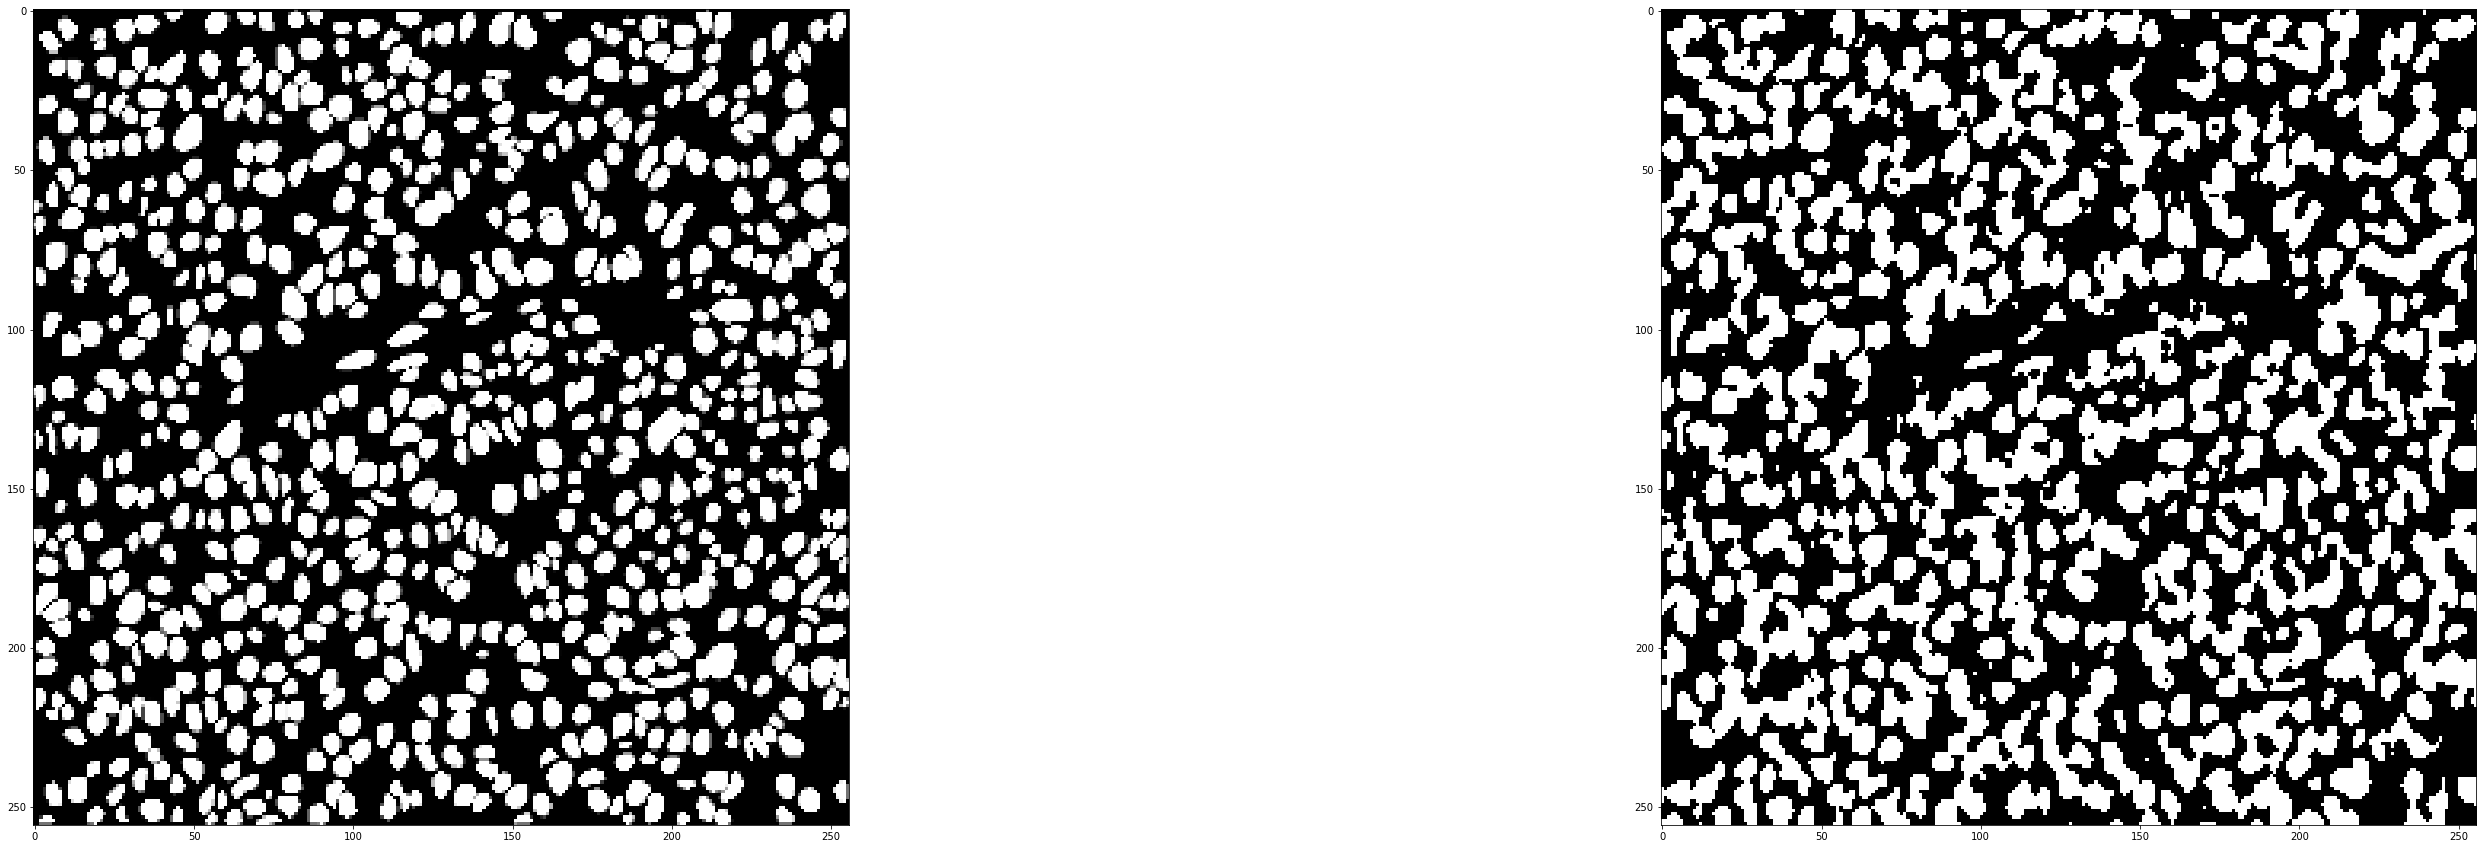

In [ ]:
# Example 1: the second mask corresponds to the resultant mask of our trained UNet model
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dataset for prediction
x, y = valid_gen.__getitem__(3)
result = model.predict(x)

result = result > 0.5  #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 1s 613ms/step


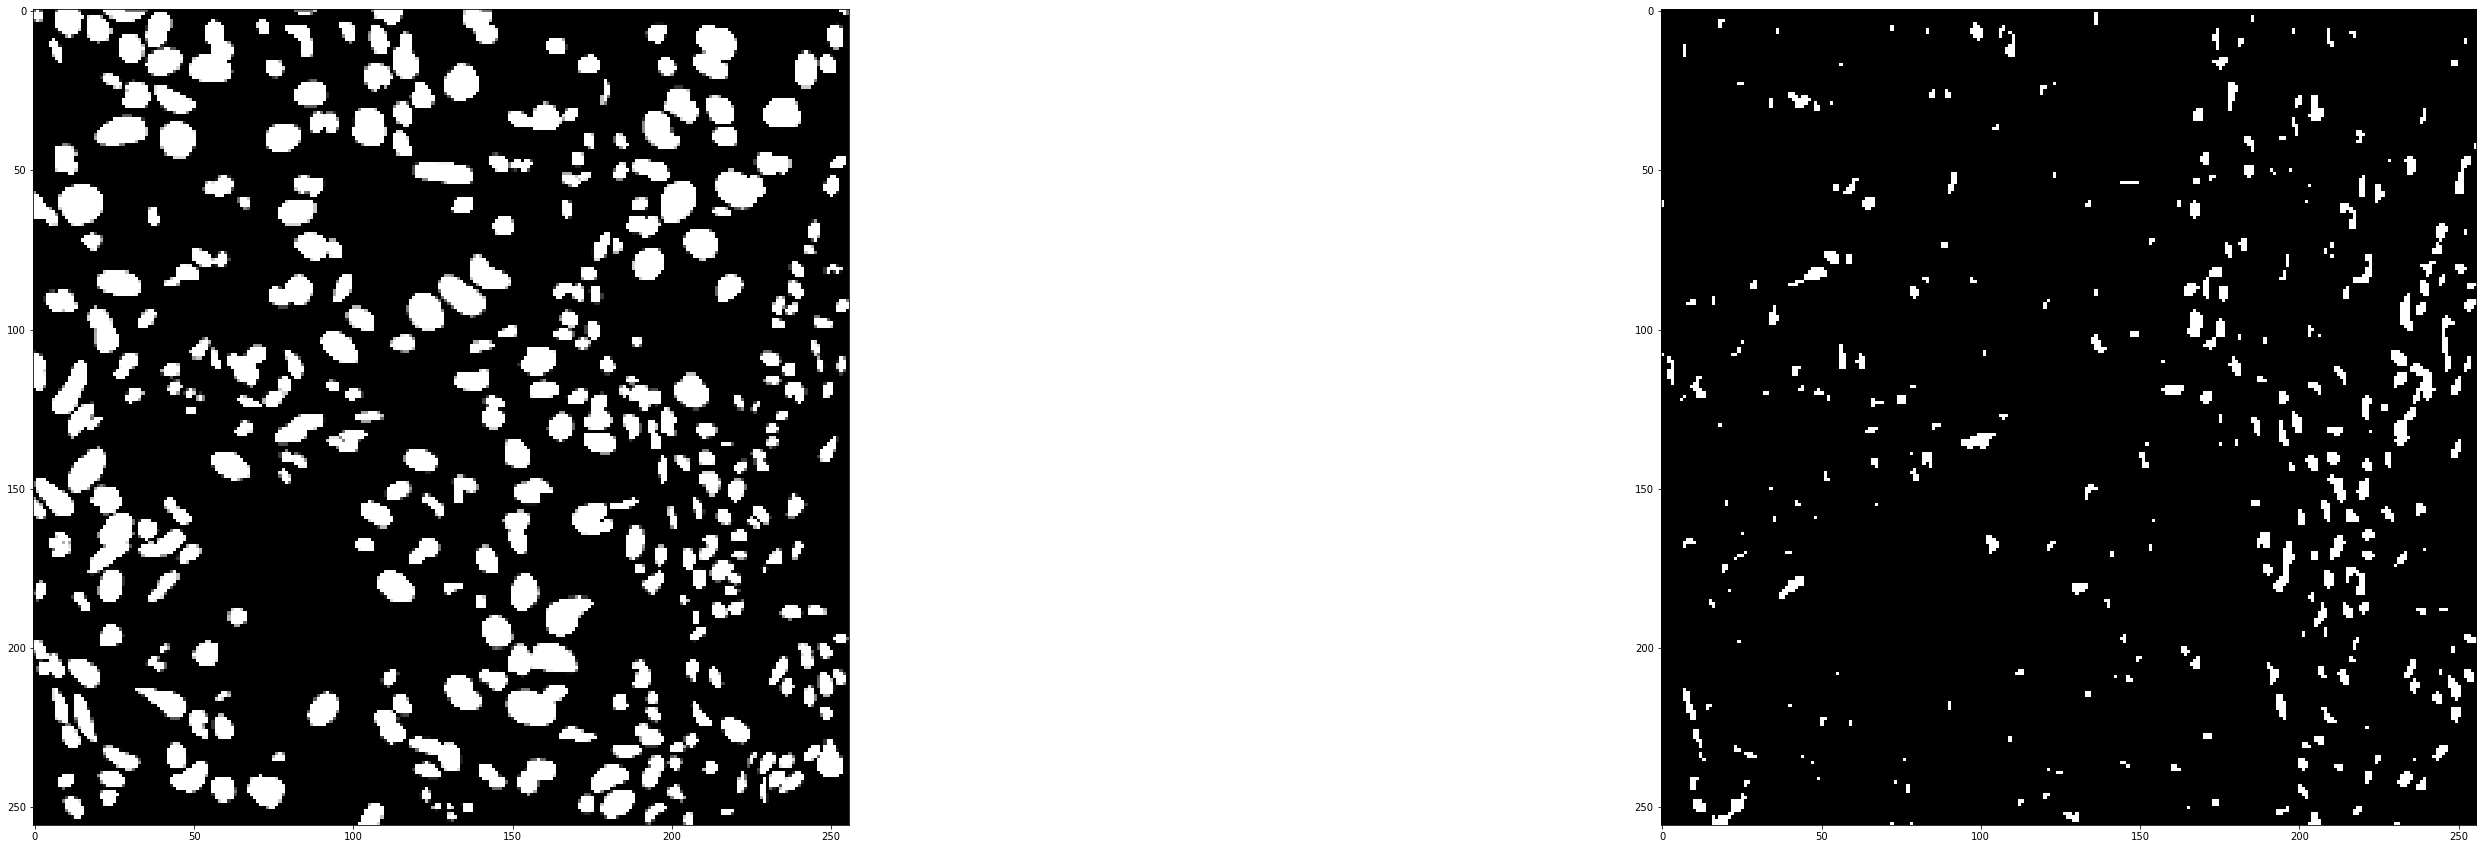

In [ ]:
# Example 2: the second mask corresponds to the resultant mask of our trained UNet model
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

### With the Binary-crossentropy loss, the results are rather underwhelming, we shall now proceed to define our own DiceLoss in hopes of deriving better results.

## 3. Train the UNet using Dice loss, and show Dice score on validation and test data.

## Implementing the Dice Loss Class to train the model

In [ ]:
class DiceLoss(tf.keras.losses.Loss): #Defining the Diceloss class to wrap our Diceloss function
    def __init__(self): #Constructor of Class
        super().__init__()
    def call(self, y_true, y_pred): #Function which is called to compute the loss

        #flatten label and prediction tensors
        y_pred = tf.reshape(y_pred, [-1])
        y_true = tf.reshape(y_true, [-1])
        intersection = tf.reduce_sum(y_true*y_pred)

        dice = (2*intersection)/(tf.reduce_sum(tf.math.square(y_true)) + tf.reduce_sum(tf.math.square(y_pred)))
        # The dice coeficient is calculated by:
        # Dice=2|A∩B|/|A|+|B| where numerator can be approximated as 2 times the element-wise multiplication between the prediction and true masks, then summing the resulting matrix and |A| is the squared sum of elements of A.

        return 1 - dice # Returning dice loss = 1 - dice coefficient

def DiceScore_f(y_true, y_pred): #Function to calculate Dice score

    #flatten label and prediction tensors
    y_pred = tf.reshape(y_pred, [-1])
    y_true = tf.reshape(y_true, [-1])
    intersection = tf.reduce_sum(y_true*y_pred)

    dice = (2*intersection)/(tf.reduce_sum(tf.math.square(y_true)) + tf.reduce_sum(tf.math.square(y_pred)))

    return dice

In [ ]:
model2 = UNet()
model2.compile(optimizer="adam", loss=DiceLoss(), metrics=["acc"]) # Configuring the model for training using dice loss and optimizing using Adam algorithm
model2.summary() #Summary of the UNet model

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_266 (Conv2D)            (None, 256, 256, 32  896         ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_267 (Conv2D)            (None, 256, 256, 32  9248        ['conv2d_266[0][0]']             
                                )                                                          

In [ ]:
train_gen_dice = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Training Dataset
valid_gen_dice = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Validation Dataset

train_steps = len(train_ids)//batch_size #Number of steps in training
valid_steps = len(valid_ids)//batch_size #Number of steps fin validating

#We invoke the UNet model defined with DiceLoss to be trained on the generated Dataset
model2.fit(train_gen_dice, validation_data=valid_gen_dice, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/5
24/24 [==============================] - 69s 3s/step - loss: 0.4352 - acc: 0.7064 - val_loss: 0.3542 - val_acc: 0.7315
Epoch 2/5
24/24 [==============================] - 68s 3s/step - loss: 0.3573 - acc: 0.7044 - val_loss: 0.4339 - val_acc: 0.7177
Epoch 3/5
24/24 [==============================] - 66s 3s/step - loss: 0.3308 - acc: 0.7587 - val_loss: 0.3360 - val_acc: 0.7407
Epoch 4/5
24/24 [==============================] - 68s 3s/step - loss: 0.3044 - acc: 0.7874 - val_loss: 0.2694 - val_acc: 0.6823
Epoch 5/5
24/24 [==============================] - 66s 3s/step - loss: 0.2666 - acc: 0.7857 - val_loss: 0.2507 - val_acc: 0.7454


## 4. Show a few output maps.

In [ ]:
# Saving the Weights
model2.save_weights("/content/drive/MyDrive/UNetW_dice.h5")

# Dataset for validation
x, y = valid_gen_dice.__getitem__(1)
result = model2.predict(x)

result = result > 0.5 # Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 1s 993ms/step


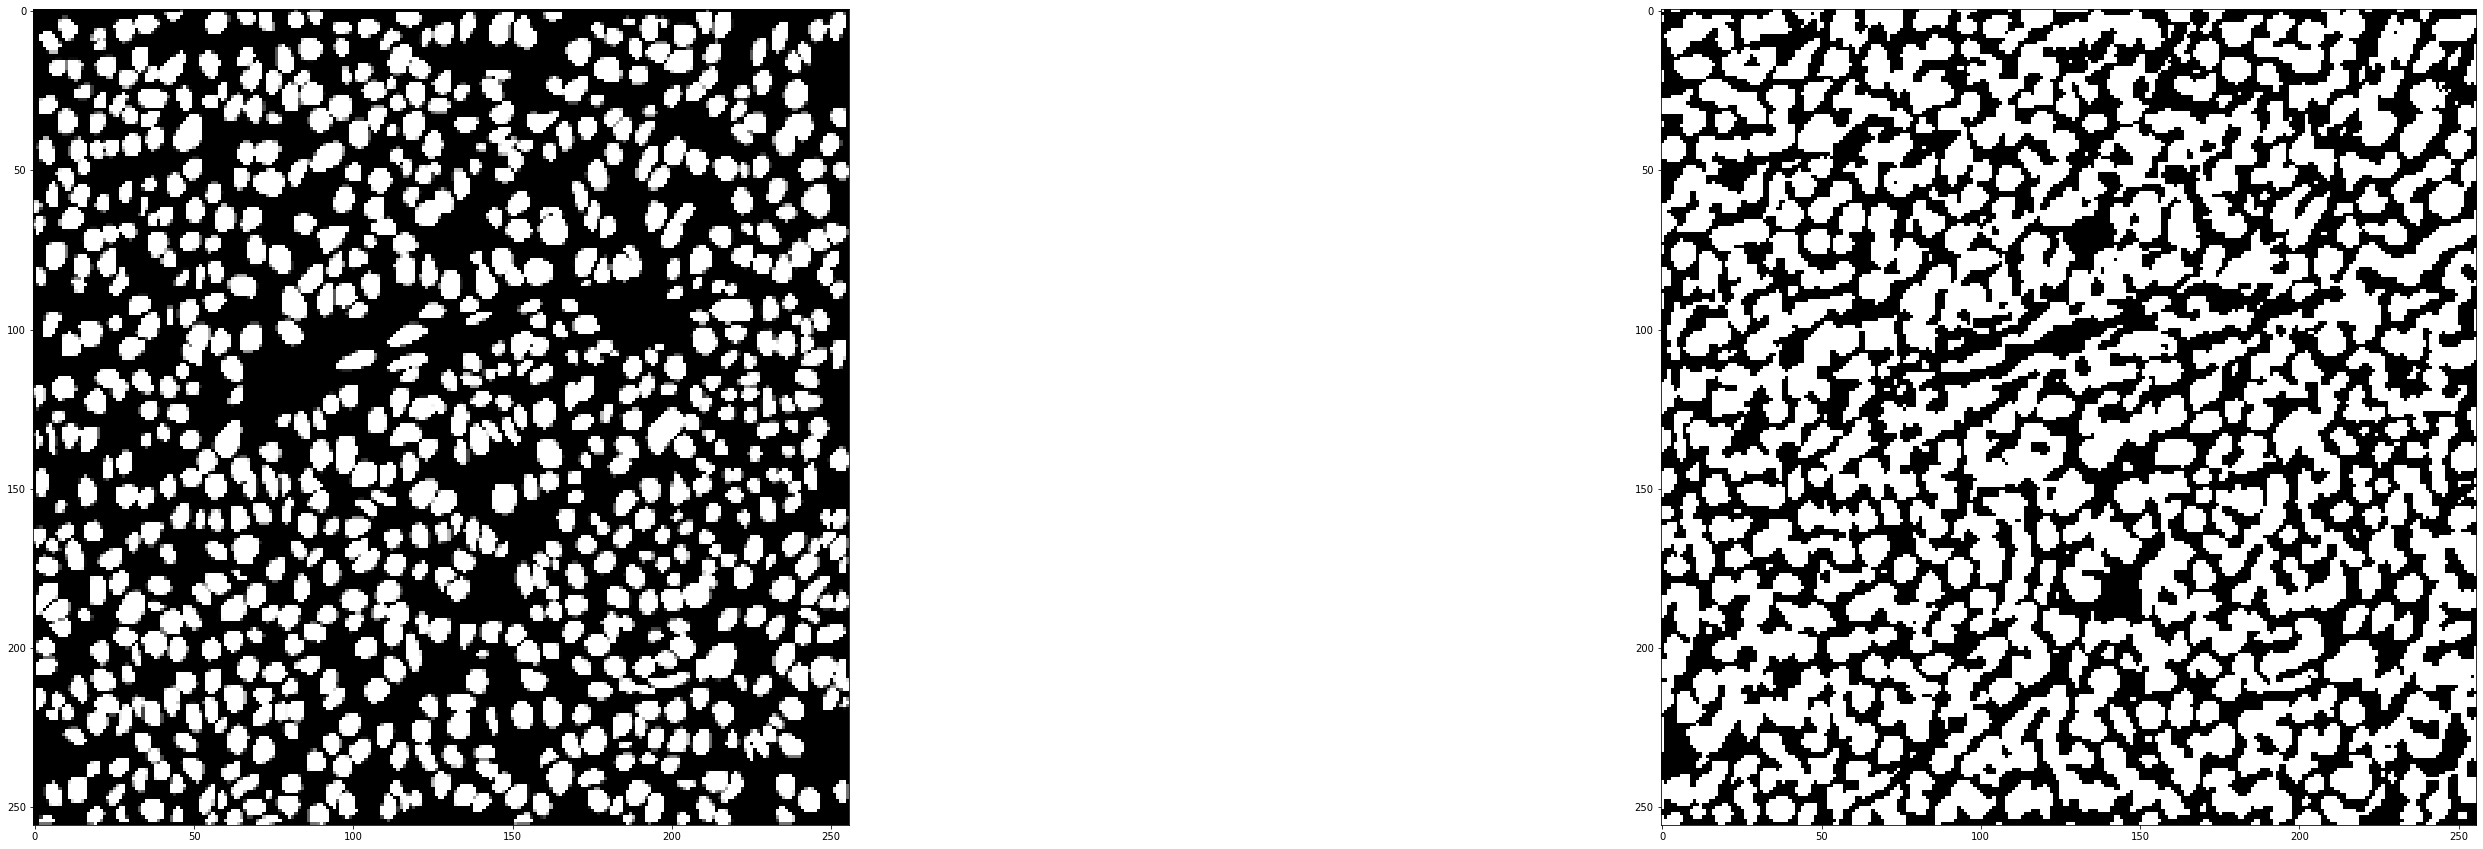

In [ ]:
# Example 1: The second mask corresponds to the resultant of Unet model trained using Dice loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.766

tf.Tensor(0.7660639819150883, shape=(), dtype=float64)


In [ ]:
# Dataset for validation
x, y = valid_gen_dice.__getitem__(3)
result = model2.predict(x)

result = result > 0.5 # Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 1s 1s/step


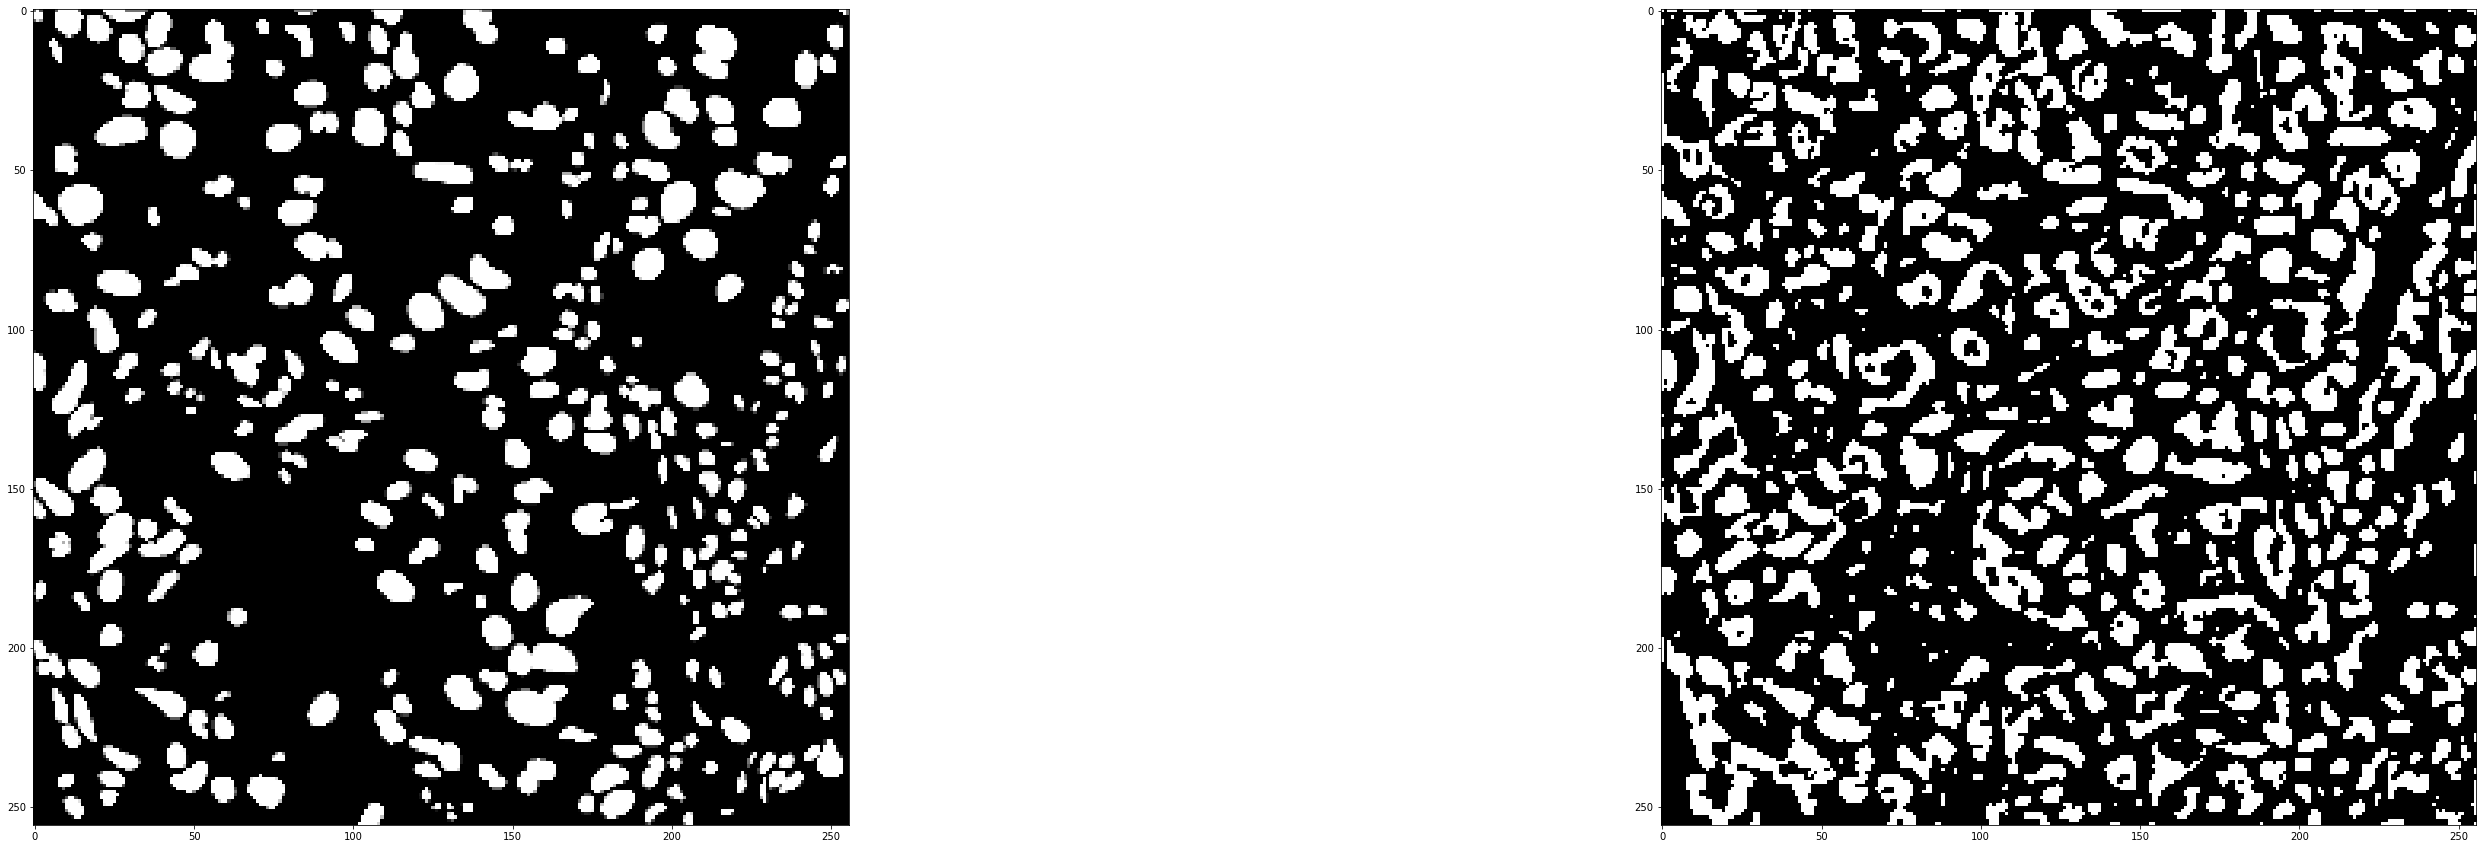

In [ ]:
# Example 2: resultant mask of UNet model trained on Dice loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.627

tf.Tensor(0.6275332839580499, shape=(), dtype=float64)


## Testing the model using Dice Loss

In [ ]:
testing_gen_dice = DataGen(test_ids, test_path, image_size=image_size, batch_size=batch_size) #Generating the dataset for testing

In [ ]:
# Dataset for prediction
x, y = testing_gen_dice.__getitem__(0)
result = model2.predict(x)

result = result > 0.5 # Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 1s 778ms/step


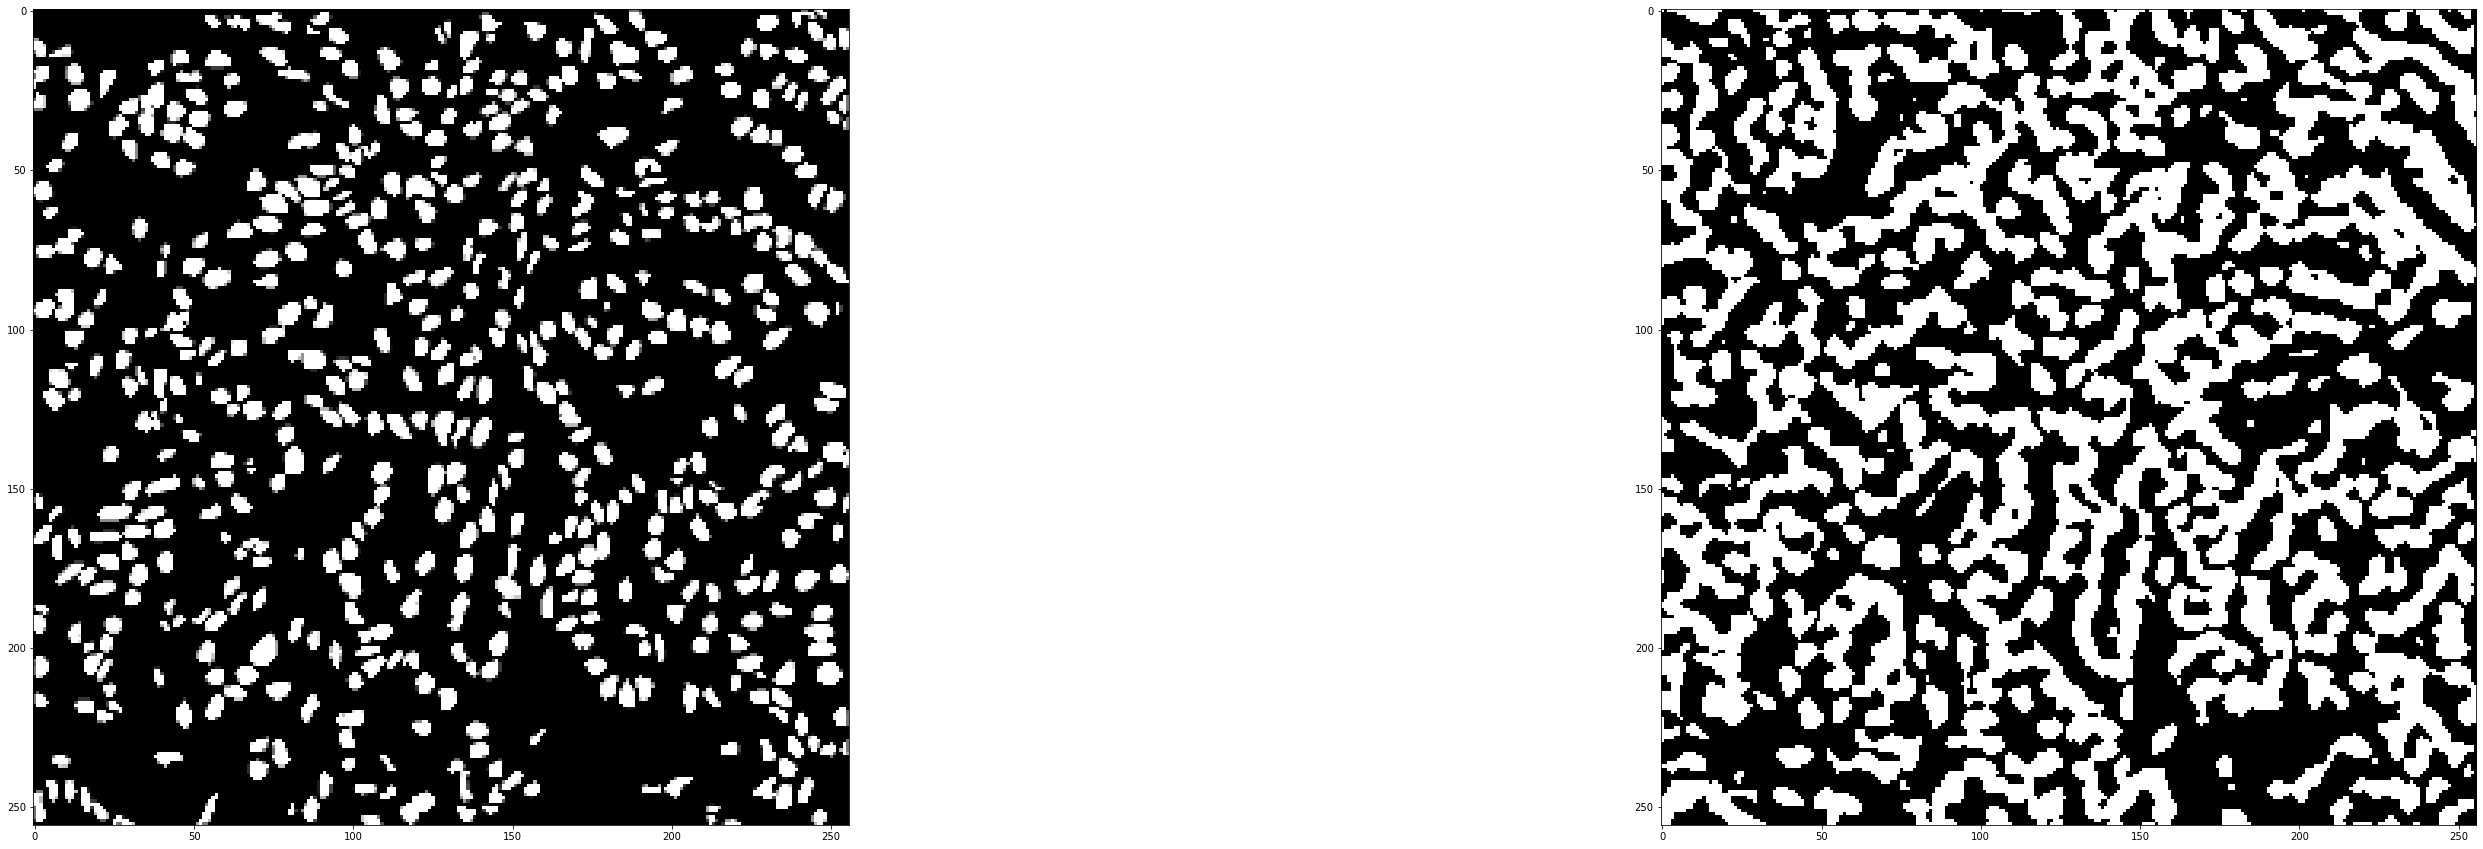

In [ ]:
# Example 1: resultant mask from UNet model trained using dice loss, on image from testing dataset
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above test image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.610

tf.Tensor(0.610267024925974, shape=(), dtype=float64)


In [ ]:
## Dataset for prediction
x, y = testing_gen_dice.__getitem__(1)
result = model2.predict(x)

result = result > 0.5

1/1 [==============================] - 1s 1s/step


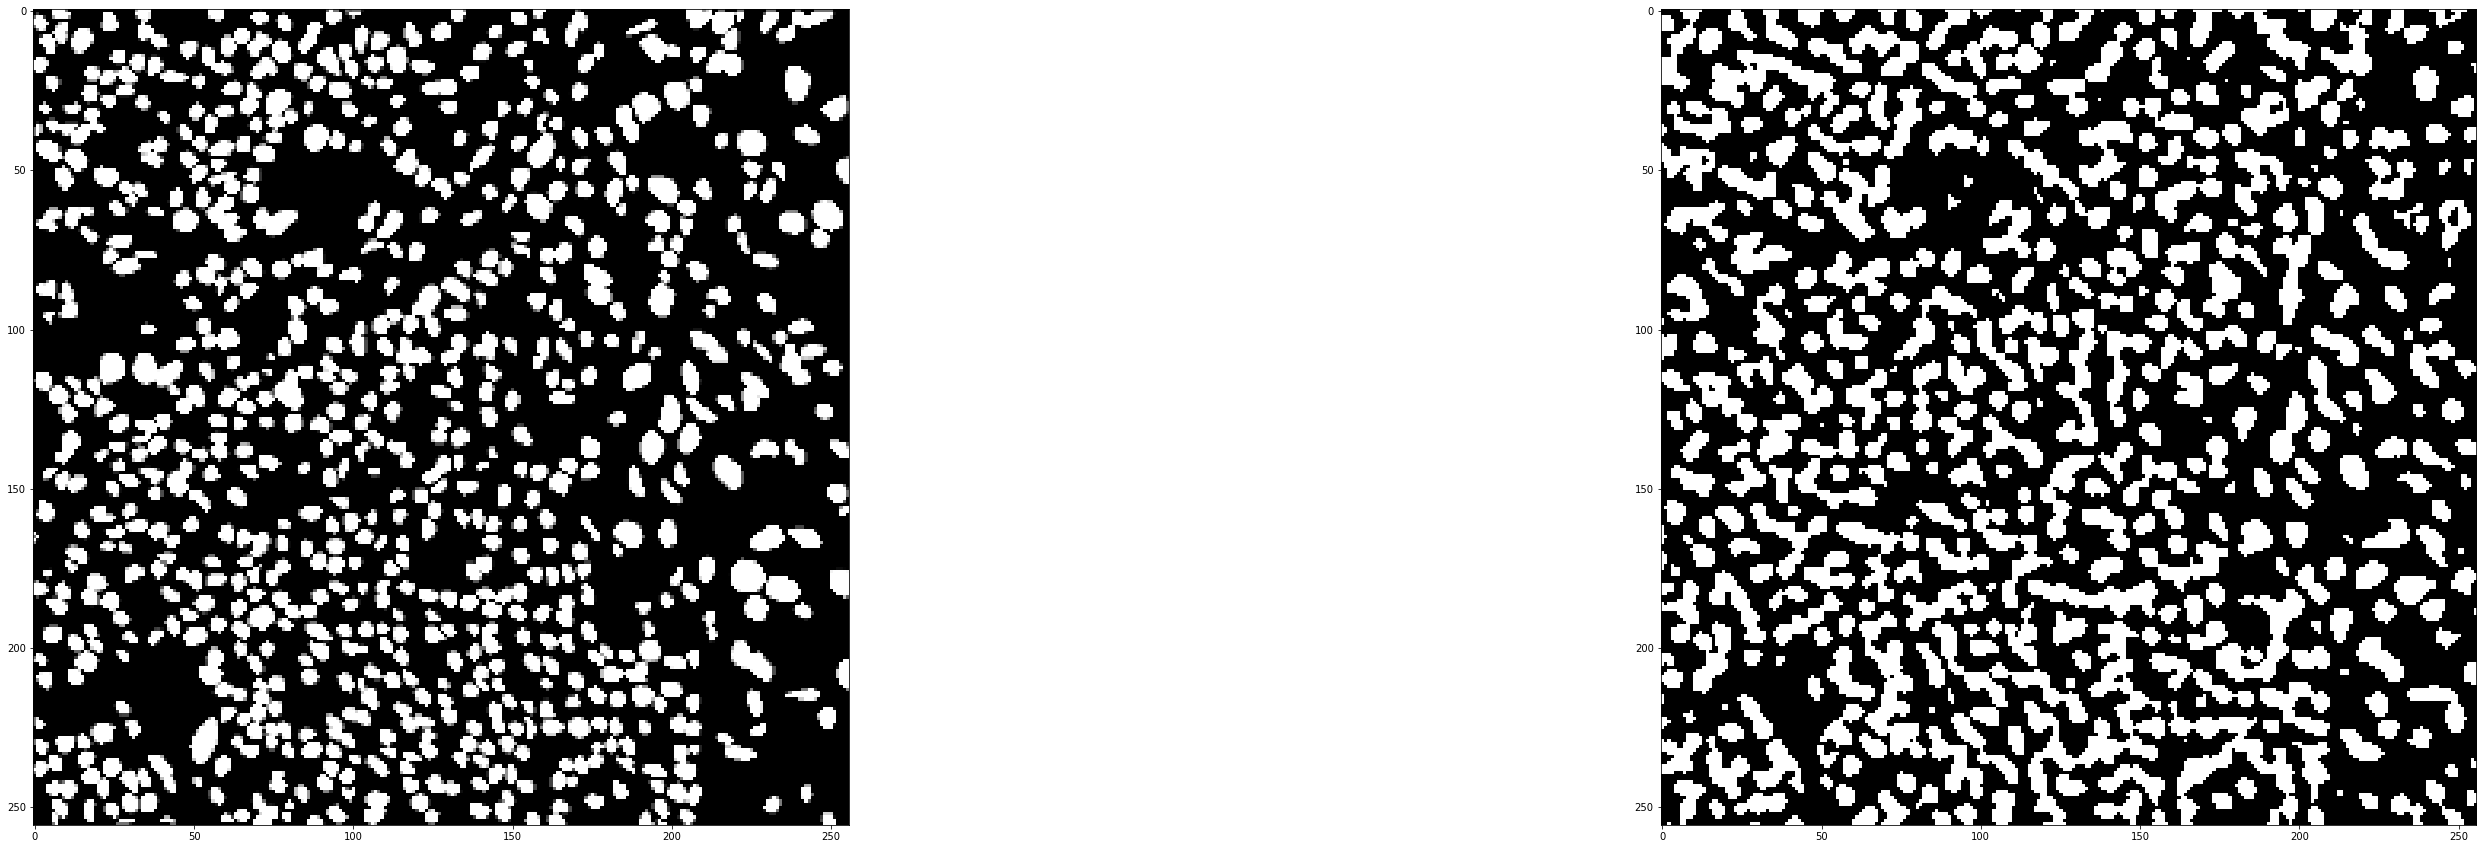

In [ ]:
# Example 2: resultant mask from UNet model trained using dice loss, on image from testing dataset
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above test image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.777

tf.Tensor(0.7777115218423422, shape=(), dtype=float64)


### As expected, we see much better results visually when our model is trained with DiceLoss instead of Binary Cross Entropy loss

## 5. Modify this baseline architecture to study the impact of changing:
##a. Number of blocks in the UNet architecture [1]

In [ ]:
# First let's see the impact of decreasing one upsampling and one downsampling block in the UNet model
def UNet_decrease():
    f = [64, 128, 256, 512] # Array corresponding to the number of filters
    inputs = keras.layers.Input((image_size, image_size, 3))

    # Contraction path with 3 downsampling blocks
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #256 -> 128
    c2, p2 = down_block(p1, f[1]) #128 -> 64
    c3, p3 = down_block(p2, f[2]) #64 -> 32

    bn = bottleneck(p3, f[3])

    # Expansion path with 3 upsampling blocks
    u1 = up_block(bn, c3, f[2]) #32 -> 64
    u2 = up_block(u1, c2, f[1]) #64 -> 128
    u3 = up_block(u2, c1, f[0]) #128 -> 256

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u3)  # Final output 256x256x1
    model = keras.models.Model(inputs, outputs) # To group layers into an object
    return model

In [ ]:
model3 = UNet_decrease()
model3.compile(optimizer="adam", loss=DiceLoss(), metrics=["acc"]) # Configuring the model for training using Dice loss and optimizing using Adam algorithm
model3.summary() # Model summary

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_57[0][0]']              
                                )                                                           

In [ ]:
train_gen_dice = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Training Dataset
valid_gen_dice = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Validation Dataset

train_steps = len(train_ids)//batch_size #Number of steps in training
valid_steps = len(valid_ids)//batch_size #Number of steps fin validating

#We invoke the UNet model defined with decreased blocks to be trained on the generated Dataset
model3.fit(train_gen_dice, validation_data=valid_gen_dice, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/5
24/24 [==============================] - 169s 7s/step - loss: 0.4621 - acc: 0.6619 - val_loss: 0.3373 - val_acc: 0.6745
Epoch 2/5
24/24 [==============================] - 178s 7s/step - loss: 0.3316 - acc: 0.7832 - val_loss: 0.2799 - val_acc: 0.7406
Epoch 3/5
24/24 [==============================] - 197s 8s/step - loss: 0.3313 - acc: 0.7281 - val_loss: 0.2839 - val_acc: 0.7314
Epoch 4/5
24/24 [==============================] - 216s 9s/step - loss: 0.2751 - acc: 0.7956 - val_loss: 0.2852 - val_acc: 0.7562
Epoch 5/5
24/24 [==============================] - 165s 7s/step - loss: 0.2621 - acc: 0.8030 - val_loss: 0.2649 - val_acc: 0.7705


We see here that the value of loss is higher for the model with lesser number of blocks. Let's look at some validation images and their predictions.

In [ ]:
## Save the Weights
model3.save_weights("/content/drive/MyDrive/UNetW_decrease_dice.h5")

## Dataset for validation
x, y = valid_gen_dice.__getitem__(1)
result = model3.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 2s 2s/step


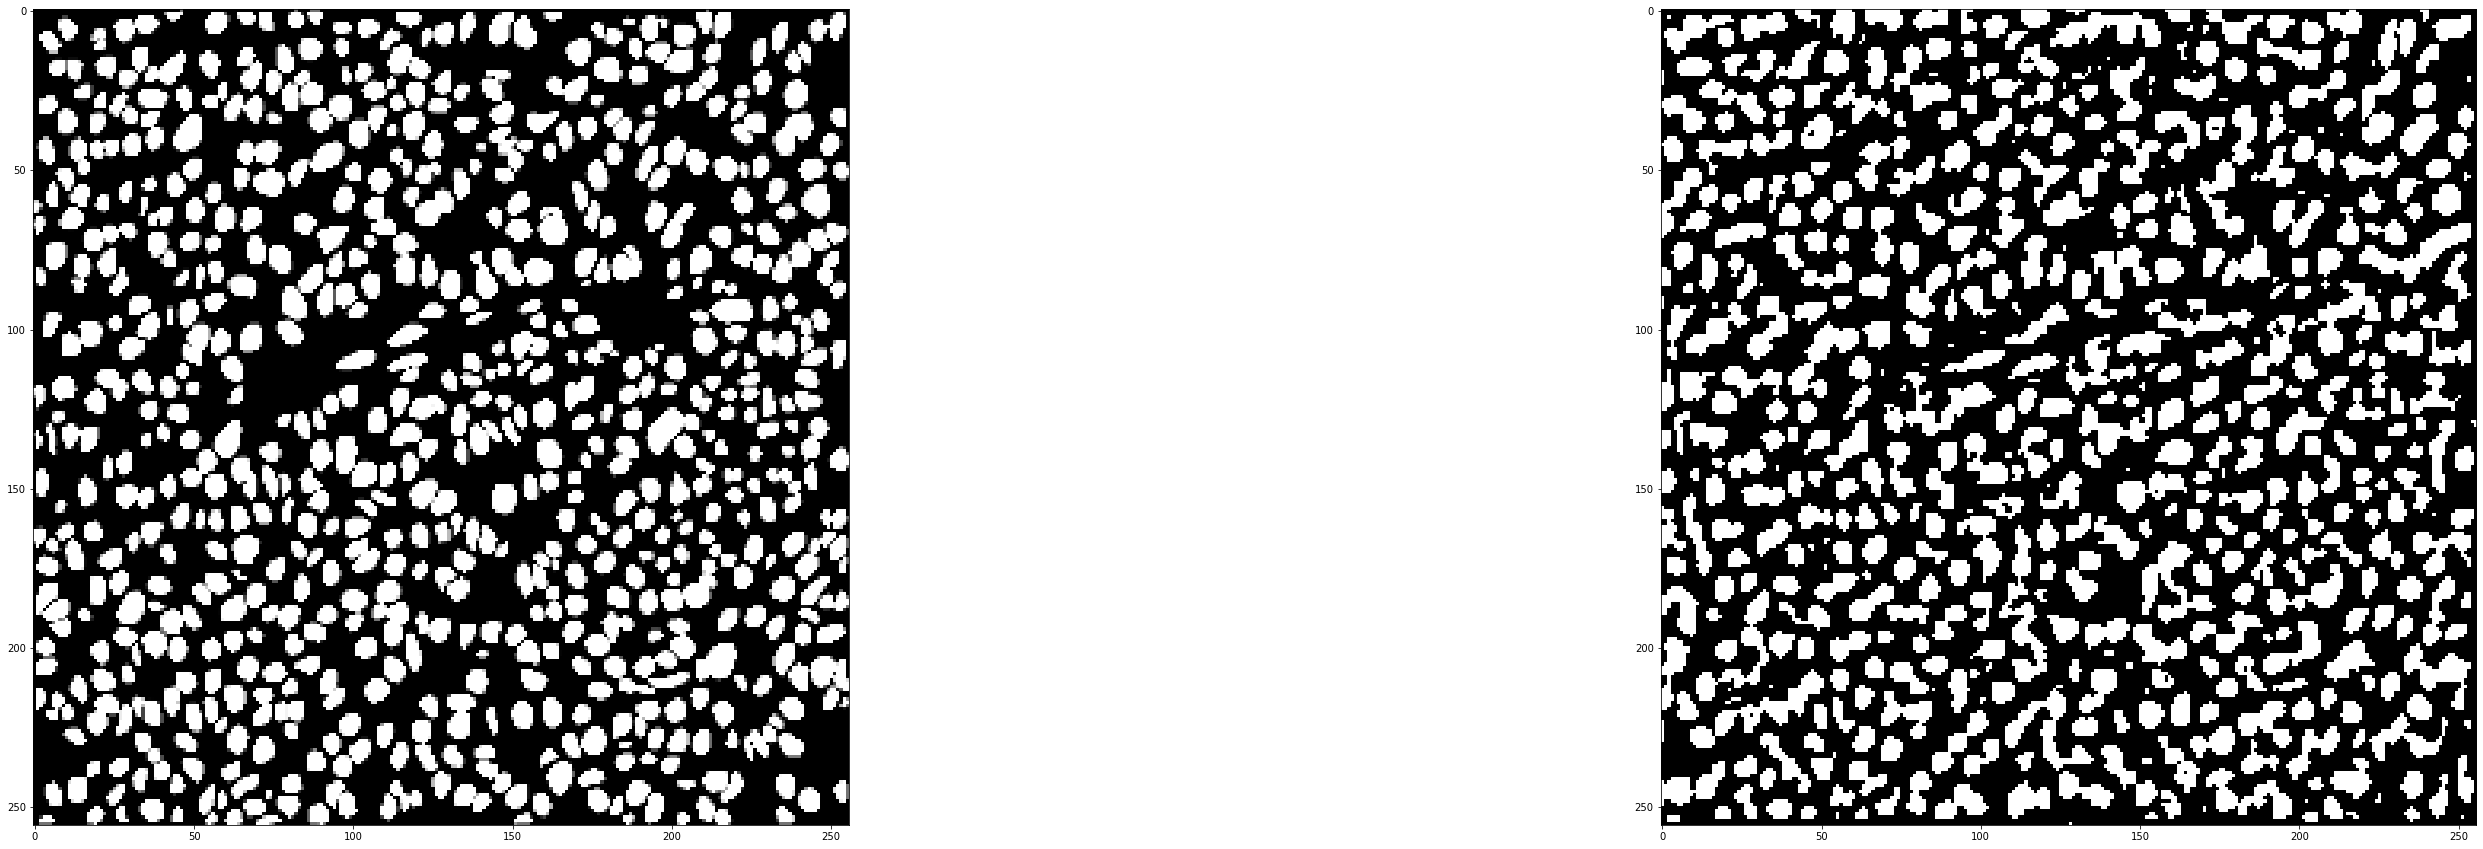

In [ ]:
# Example 1: resultant mask from reduced UNet model trained using dice loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

The prediction on this image using the UNet with decreased number of blocks is better than the original one

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.826

tf.Tensor(0.8267344415776094, shape=(), dtype=float64)


The Dice score with the previous model was 0.766 which is lesser than 0.826

In [ ]:
## Dataset for validation
x, y = valid_gen_dice.__getitem__(3)
result = model3.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 2s 2s/step


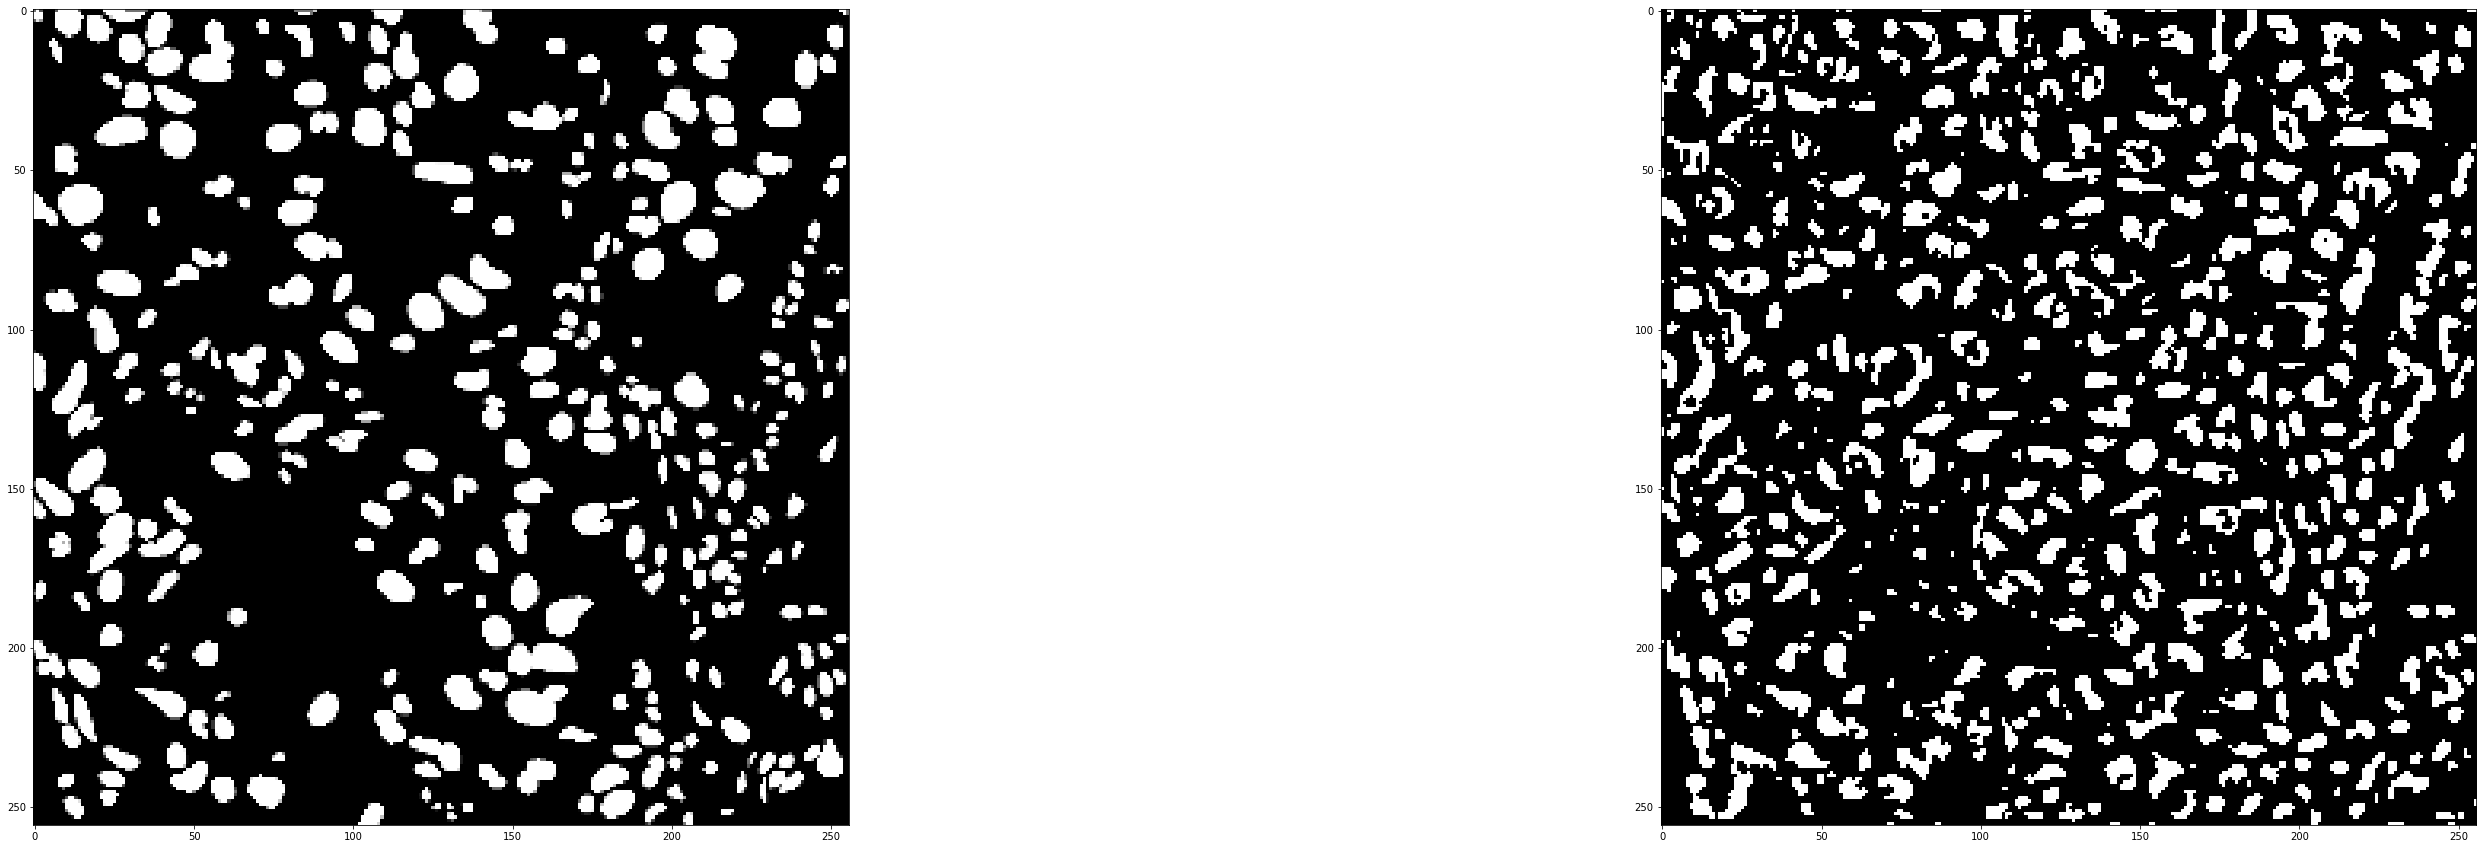

In [ ]:
# Example 2: resultant mask from reduced UNet model trained using dice loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image

print(DiceScore_f(y[0].astype(float),result[0].astype(float)))

# Dice Score is 0.632

tf.Tensor(0.6334121667397753, shape=(), dtype=float64)


The Dice score with the previous model was 0.627 which is almost equal to 0.632

In [ ]:
# Now let's see the impact of increasing one upsampling and one downsampling block in the UNet model
def UNet_increase():
    f = [16,32,64, 128, 256, 512] # Array corresponding to the number of filters
    inputs = keras.layers.Input((image_size, image_size, 3))

    # Contraction path with 5 downsampling blocks
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #256 -> 128
    c2, p2 = down_block(p1, f[1]) #128 -> 64
    c3, p3 = down_block(p2, f[2]) #64 -> 32
    c4, p4 = down_block(p3, f[3]) #32 -> 16
    c5, p5 = down_block(p4, f[4]) #16 -> 8

    bn = bottleneck(p5, f[5])

    # Expansion path with 5 upsampling blocks
    u1 = up_block(bn, c5, f[4]) #8 -> 16
    u2 = up_block(u1, c4, f[3]) #16 -> 32
    u3 = up_block(u2, c3, f[2]) #32 -> 64
    u4 = up_block(u3, c2, f[1]) #64 -> 128
    u5 = up_block(u4, c1, f[0]) #128 -> 256

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u5) # Final output 256x256x1
    model = keras.models.Model(inputs, outputs) # To group layers into an object
    return model

In [ ]:
model4 = UNet_increase()
model4.compile(optimizer="adam", loss=DiceLoss(), metrics=["acc"]) # Configuring the model for training using Dice loss and optimizing using Adam algorithm
model4.summary() # Model summary

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_72 (Conv2D)             (None, 256, 256, 16  448         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_73 (Conv2D)             (None, 256, 256, 16  2320        ['conv2d_72[0][0]']              
                                )                                                           

In [ ]:
train_gen_dice = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Training Dataset
valid_gen_dice = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Validation Dataset

train_steps = len(train_ids)//batch_size #Number of steps in training
valid_steps = len(valid_ids)//batch_size #Number of steps fin validating

#We invoke the UNet model defined with one increased block to be trained on the generated Dataset
model4.fit(train_gen_dice, validation_data=valid_gen_dice, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/5
24/24 [==============================] - 33s 1s/step - loss: 0.4929 - acc: 0.6997 - val_loss: 0.3966 - val_acc: 0.7265
Epoch 2/5
24/24 [==============================] - 37s 2s/step - loss: 0.3680 - acc: 0.7544 - val_loss: 0.3191 - val_acc: 0.7350
Epoch 3/5
24/24 [==============================] - 33s 1s/step - loss: 0.3225 - acc: 0.7368 - val_loss: 0.3003 - val_acc: 0.7479
Epoch 4/5
24/24 [==============================] - 34s 1s/step - loss: 0.2922 - acc: 0.7680 - val_loss: 0.7433 - val_acc: 0.6537
Epoch 5/5
24/24 [==============================] - 33s 1s/step - loss: 0.3192 - acc: 0.7766 - val_loss: 0.2524 - val_acc: 0.7453


We see here that the value of loss is higher for the model with greater number of blocks. Let's look at some validation images and their predictions.

In [ ]:
## Save the Weights
model4.save_weights("/content/drive/MyDrive/UNetW_increase_dice.h5")

## Dataset for validation
x, y = valid_gen_dice.__getitem__(1)
result = model4.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 1s 517ms/step


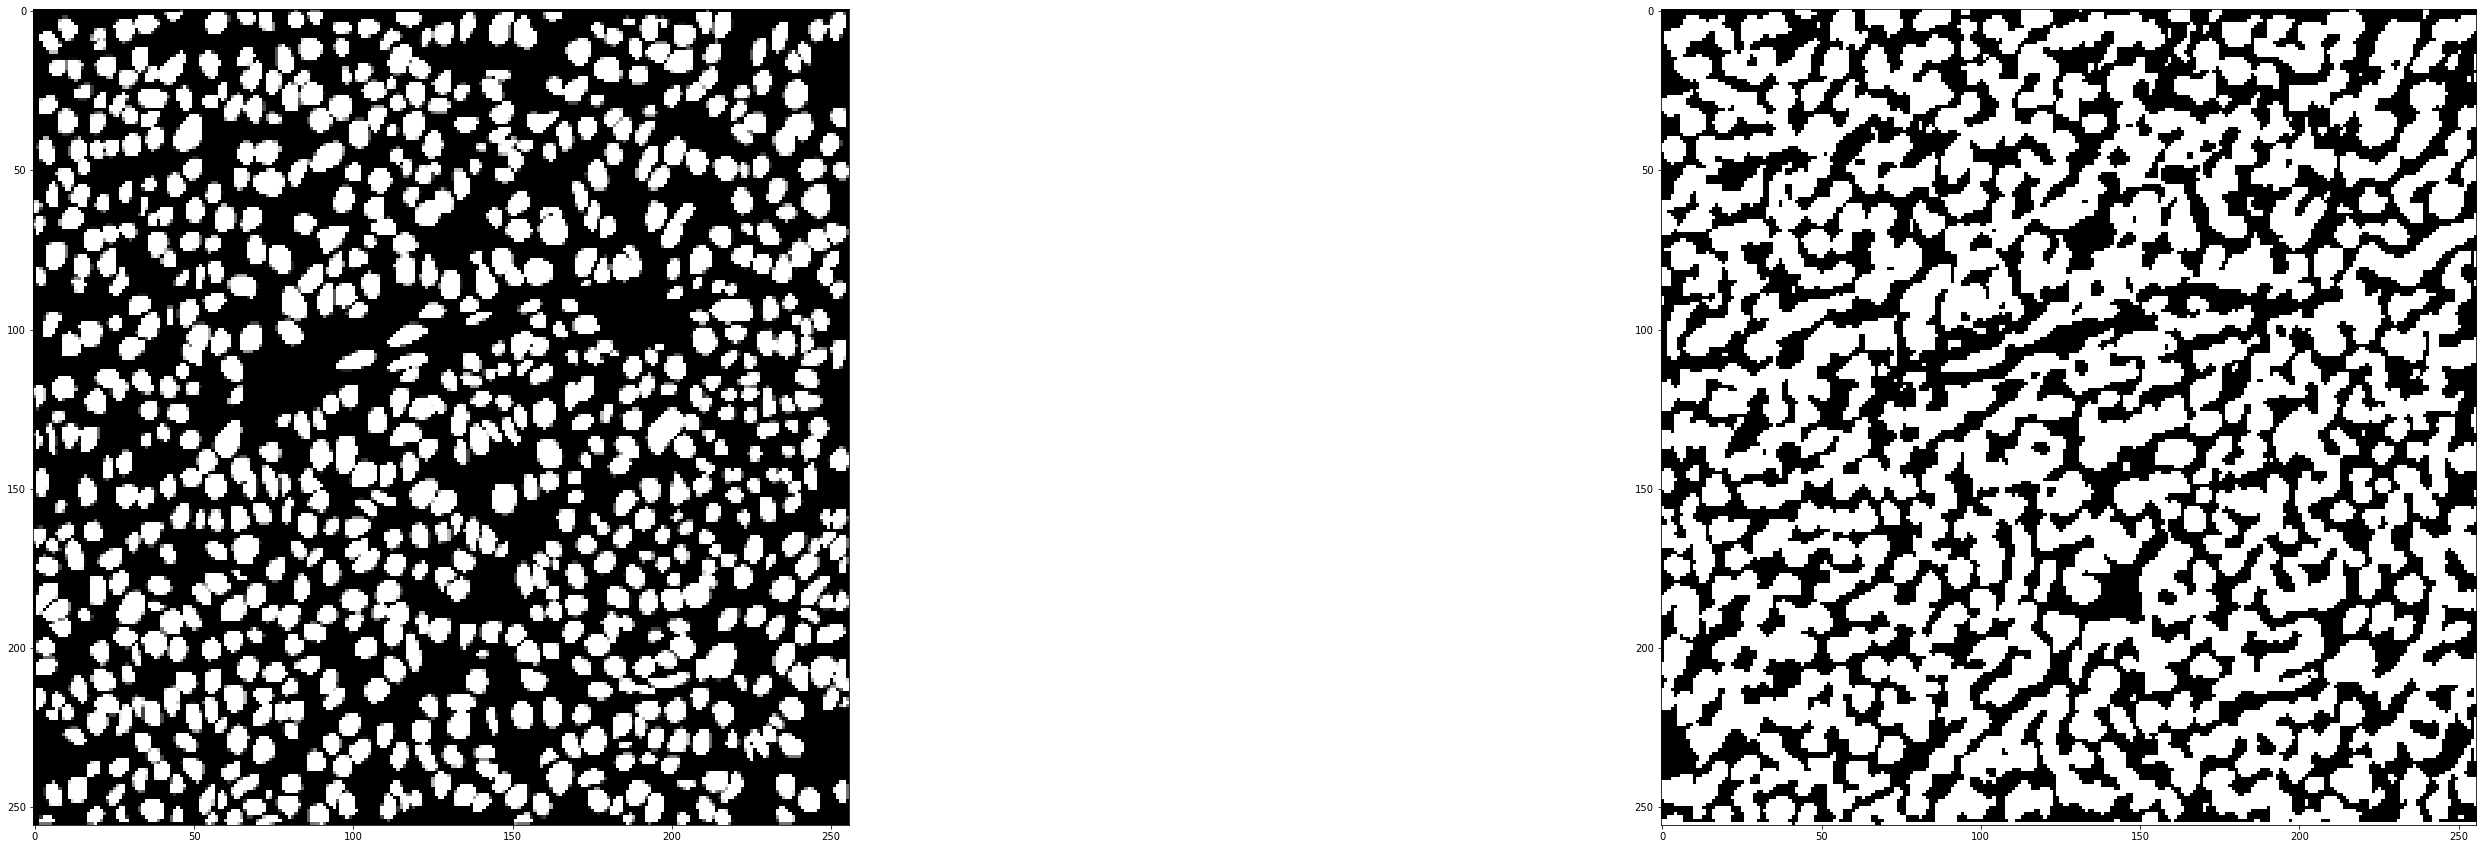

In [ ]:
# Example 1: resultant mask from UNet model increased by one block each in upsampling and downsampling and trained using dice loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

The prediction of this validation image is worse than the one obtained from our original UNet.

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.684

tf.Tensor(0.7526423361136582, shape=(), dtype=float64)


The Dice score with the original model was 0.766 which is significantly greater than 0.684

In [ ]:
## Dataset for validation
x, y = valid_gen_dice.__getitem__(3)
result = model4.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 0s 277ms/step


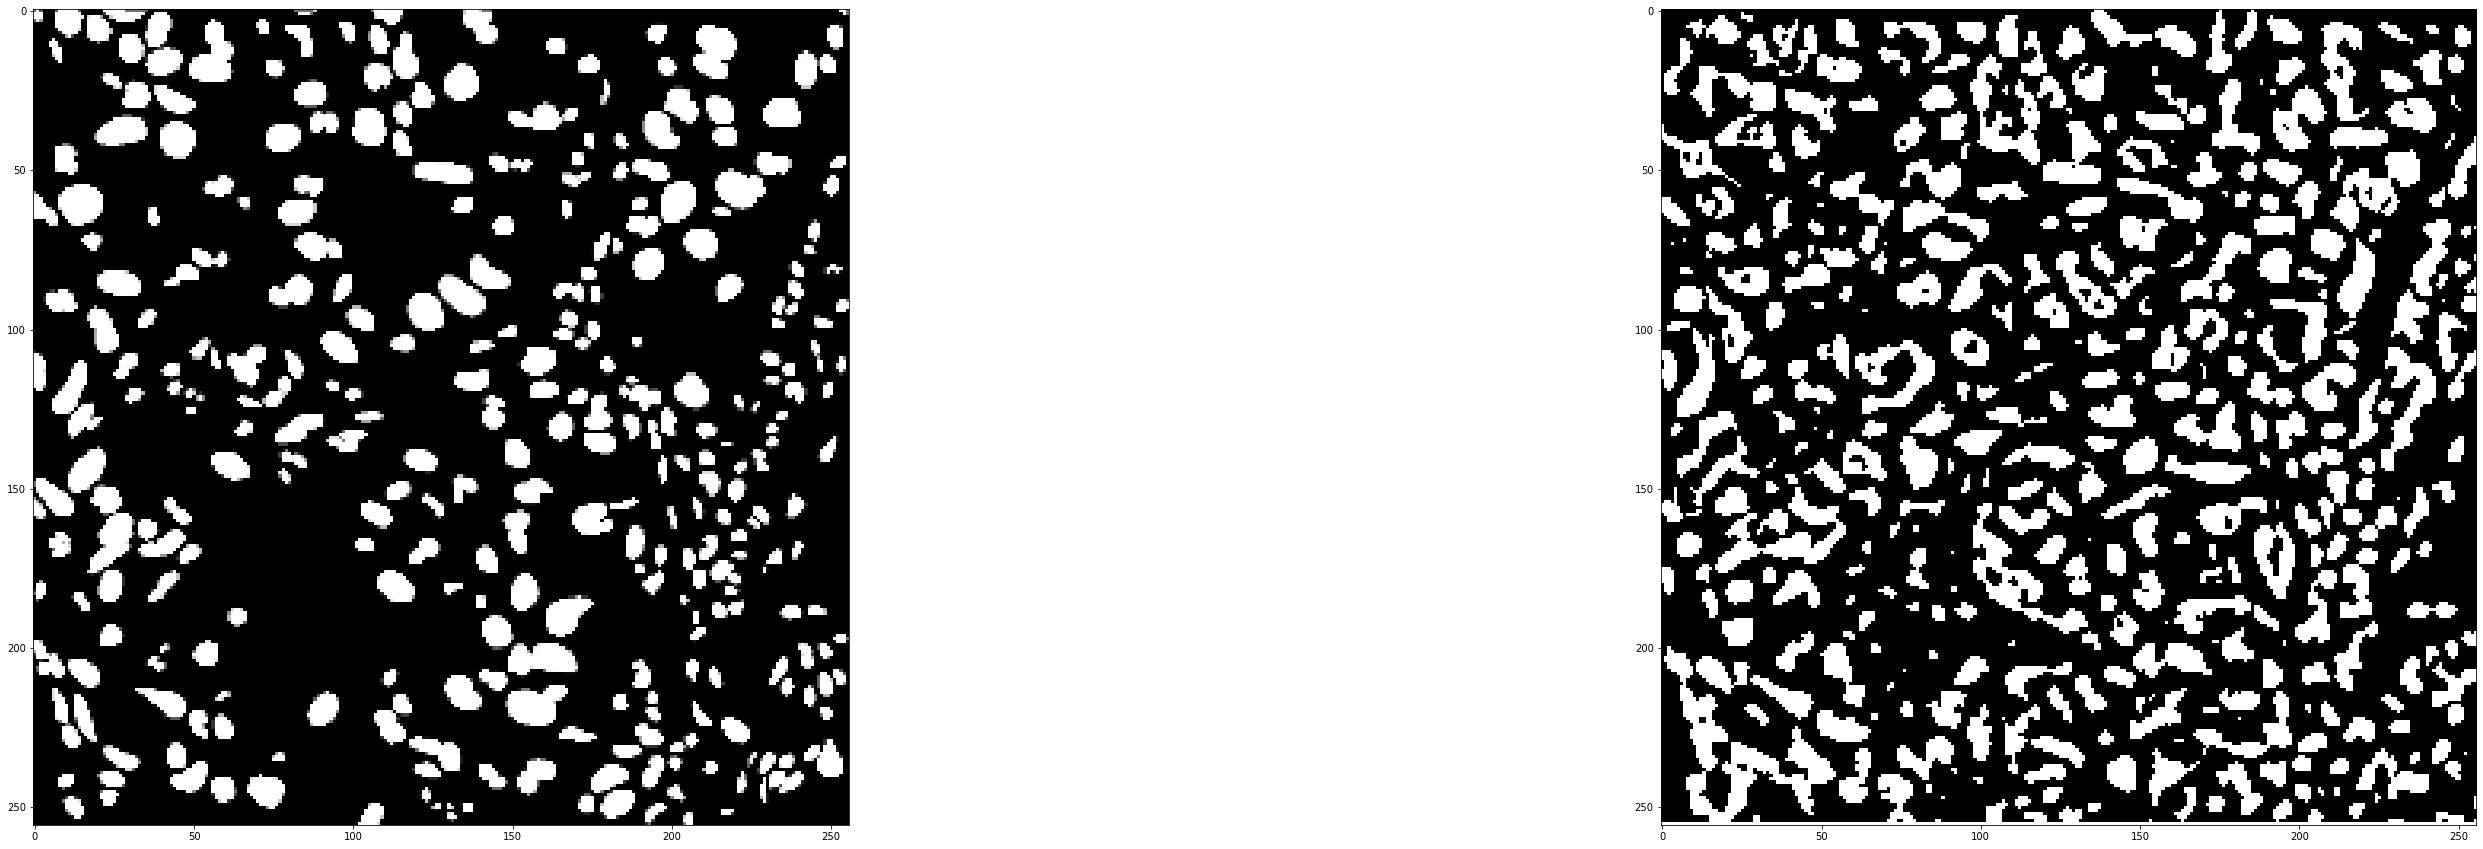

In [ ]:
# Example 2: resultant mask from UNet model increased by one block each in upsampling and downsampling and trained using dice loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.552

tf.Tensor(0.6317794707747644, shape=(), dtype=float64)


The Dice score with the original model was 0.627 which is significantly greater than 0.552

### It seems that a on decreasing the number of blocks by 1 slightly improves the results and on increasing the blocks in the model, it only worsens the fit on our data

### The UNet is considered ideal for segmentation as by downsampling and later upsampling, it is able to identify localized segments. If the image tensor is downsampled less than optimal, then the local segments and the boundary between them becomes hard to detect. If however, more than optimal downsampling is being done, segments become hard to define as even smaller edges might be considered as segments.

## b. Number of filters per layer in the UNet architecture [1]

In [ ]:
# Now let's see the impact of doubling the number of filters per layer in the UNet model

def UNet_filter_increase():
    f = [64, 128, 256, 512, 1024] # Array corresponding to the number of filters
    inputs = keras.layers.Input((image_size, image_size, 3))

    # Contraction path with 4 downsampling blocks
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #256 -> 128
    c2, p2 = down_block(p1, f[1]) #128 -> 64
    c3, p3 = down_block(p2, f[2]) #64 -> 32
    c4, p4 = down_block(p3, f[3]) #32 -> 16

    bn = bottleneck(p4, f[4])

    # Expansion path with 4 upsampling blocks
    u1 = up_block(bn, c4, f[3]) #16 -> 32
    u2 = up_block(u1, c3, f[2]) #32 -> 64
    u3 = up_block(u2, c2, f[1]) #64 -> 128
    u4 = up_block(u3, c1, f[0]) #128 -> 256

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4) # Final output 256x256x1
    model = keras.models.Model(inputs, outputs) # To group layers into an object
    return model

In [ ]:
model_fil_inc = UNet_filter_increase()
model_fil_inc.compile(optimizer="adam", loss=DiceLoss(), metrics=["acc"]) # Configuring the model for training using Dice loss and optimizing using Adam algorithm
model_fil_inc.summary() # Model summary

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 256, 256, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_96 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_95[0][0]']              
                                )                                                           

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Training Dataset
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Validation Dataset

train_steps = len(train_ids)//batch_size #Number of steps in training
valid_steps = len(valid_ids)//batch_size #Number of steps fin validating

#We invoke the UNet model defined above with doubled the number of filters to be trained on the generated Dataset
model_fil_inc.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/5
24/24 [==============================] - 223s 9s/step - loss: 0.4691 - acc: 0.6490 - val_loss: 0.3407 - val_acc: 0.7321
Epoch 2/5
24/24 [==============================] - 202s 8s/step - loss: 0.3324 - acc: 0.7832 - val_loss: 0.2861 - val_acc: 0.6722
Epoch 3/5
24/24 [==============================] - 204s 9s/step - loss: 0.2884 - acc: 0.7867 - val_loss: 0.3572 - val_acc: 0.7390
Epoch 4/5
24/24 [==============================] - 220s 9s/step - loss: 0.2768 - acc: 0.8052 - val_loss: 0.2674 - val_acc: 0.7187
Epoch 5/5
24/24 [==============================] - 246s 10s/step - loss: 0.2746 - acc: 0.7962 - val_loss: 0.2743 - val_acc: 0.7371


In [ ]:
## Save the Weights
model_fil_inc.save_weights("/content/drive/MyDrive/UNet_fil_inc_dice.h5")

## Dataset for validation
x, y = valid_gen.__getitem__(1)
result = model_fil_inc.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 2s 2s/step


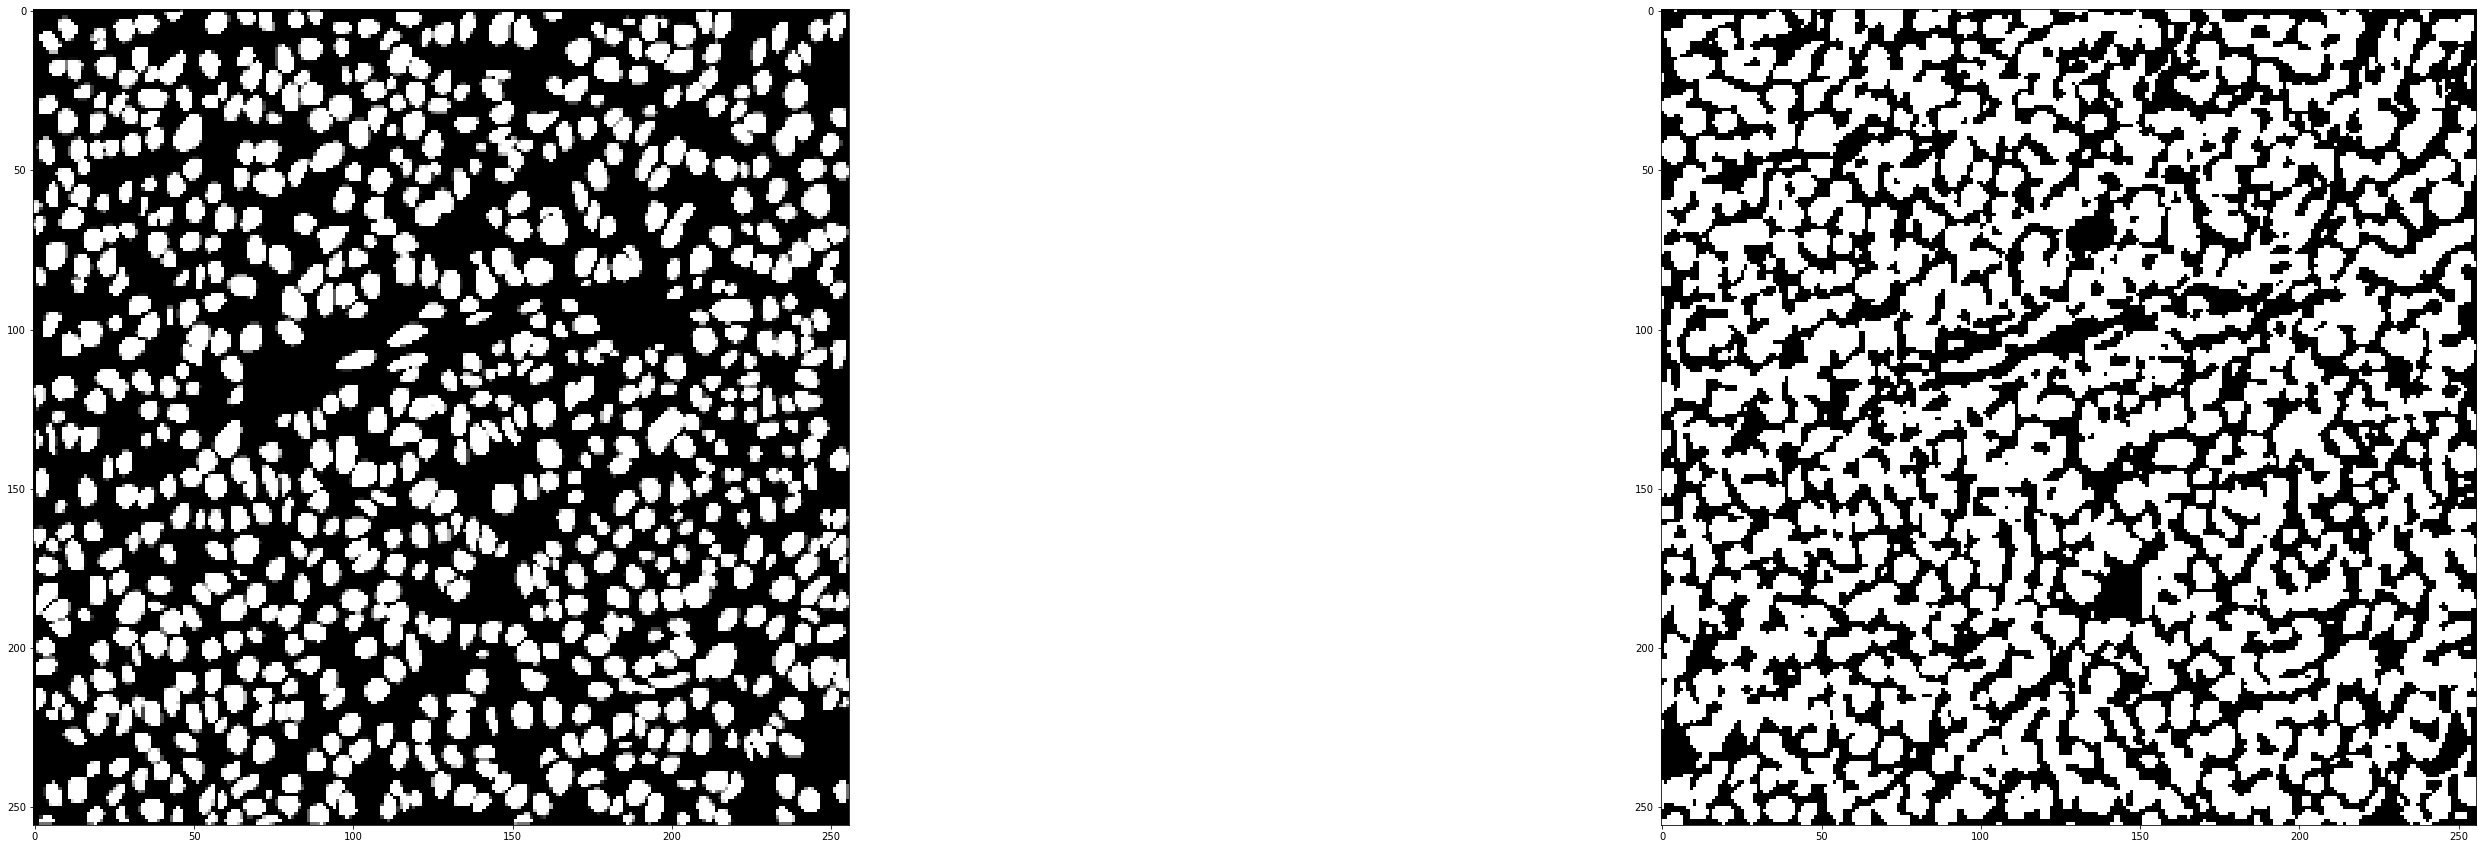

In [ ]:
# Example 1: resultant mask UNet model after doubling the number of filters per layer, trained using dice loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.749

tf.Tensor(0.7493140216762945, shape=(), dtype=float64)


The Dice score with the original model was 0.766 which is slightly greater than 0.749

In [ ]:
## Dataset for validation
x, y = valid_gen_dice.__getitem__(3)
result = model3.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 2s 2s/step


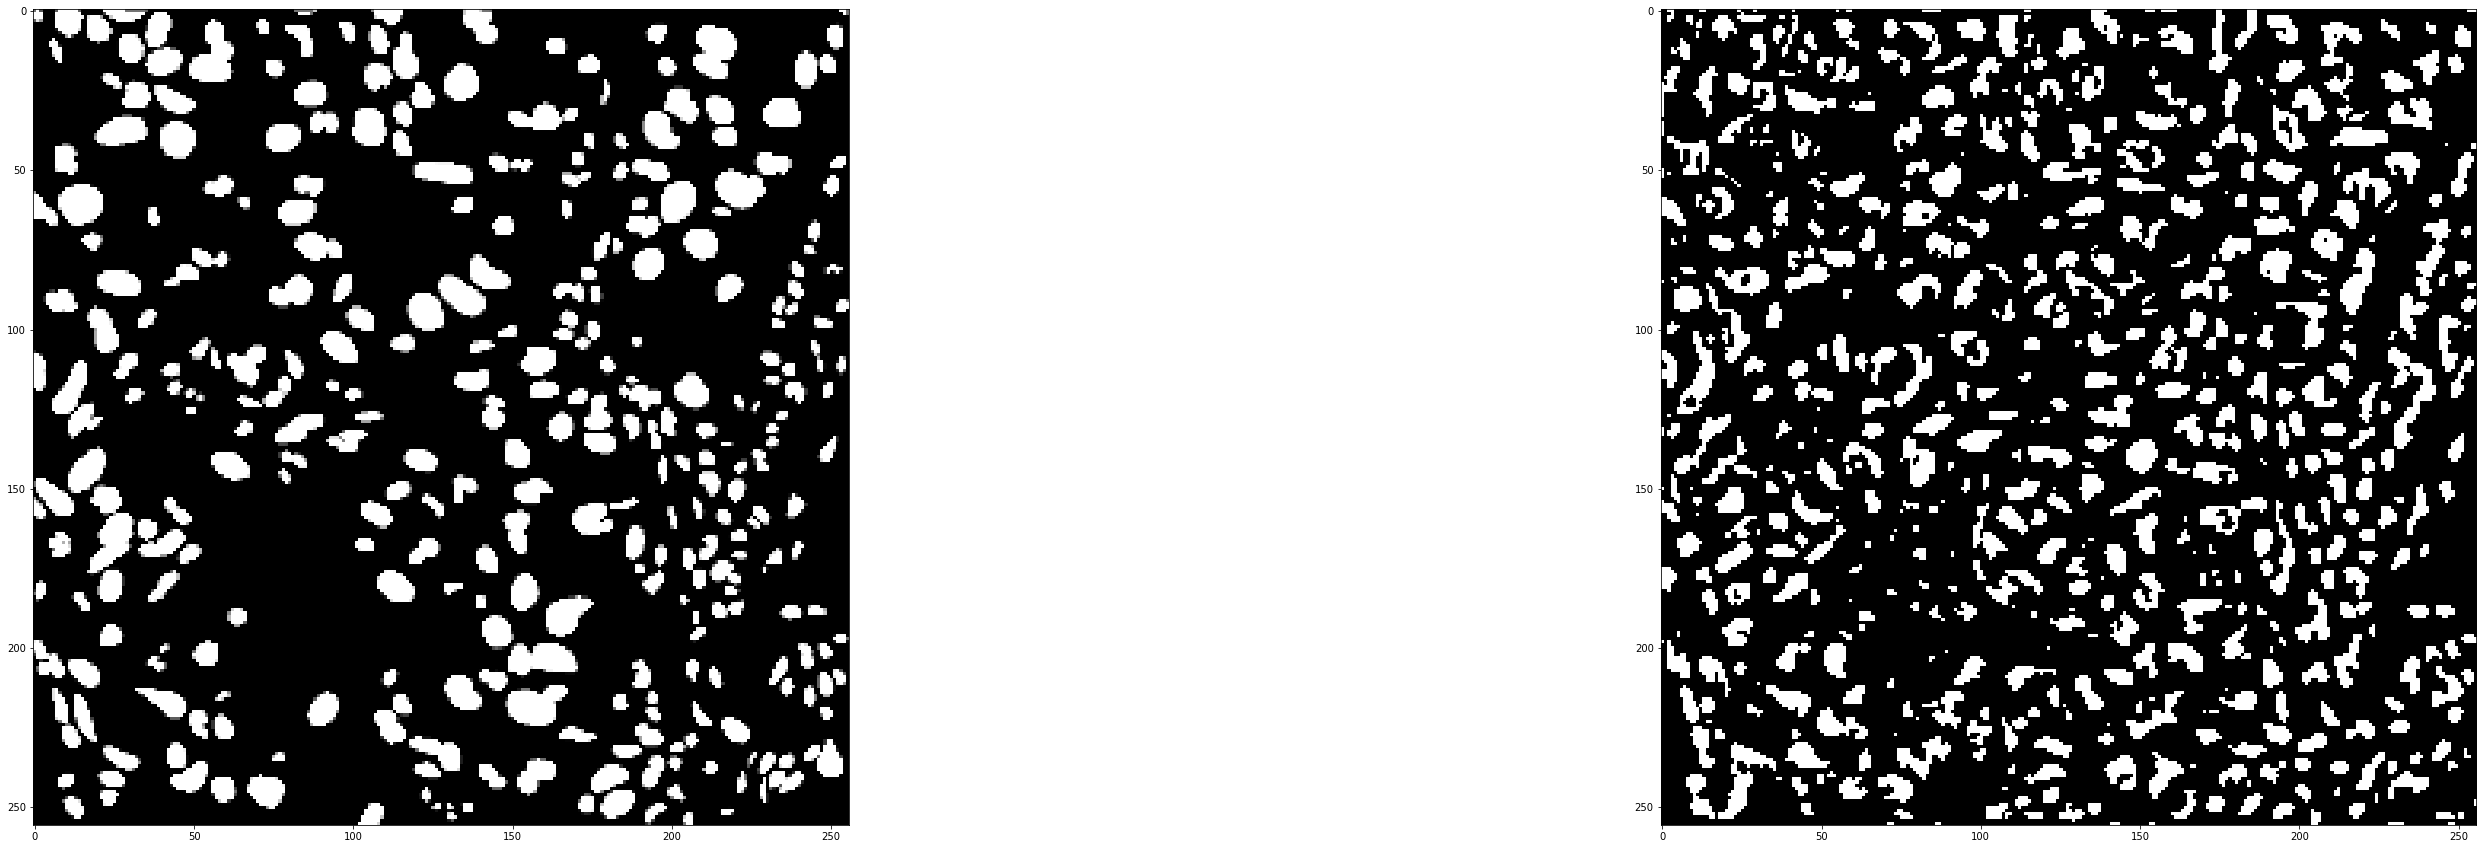

In [ ]:
# Example 2: resultant mask UNet model after doubling the number of filters per layer trained using dice loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.633

tf.Tensor(0.6334121667397753, shape=(), dtype=float64)


The Dice score with the original model was 0.627 which is almost equal to 0.633

In [ ]:
# Now let's see the impact of halfing the number of filters per layer in the UNet model

def UNet_filter_deccrease():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    # Contraction path with 4 downsampling blocks
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #256 -> 128
    c2, p2 = down_block(p1, f[1]) #128 -> 64
    c3, p3 = down_block(p2, f[2]) #64 -> 32
    c4, p4 = down_block(p3, f[3]) #32 -> 16

    bn = bottleneck(p4, f[4])

    # Expansion path with 4 upsampling blocks
    u1 = up_block(bn, c4, f[3]) #16 -> 32
    u2 = up_block(u1, c3, f[2]) #32 -> 64
    u3 = up_block(u2, c2, f[1]) #64 -> 128
    u4 = up_block(u3, c1, f[0]) #128 -> 256

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4) # Final output 256x256x1
    model = keras.models.Model(inputs, outputs) # To group layers into an object
    return model

In [ ]:
model_fil_dec = UNet_filter_deccrease()
model_fil_dec.compile(optimizer="adam", loss=DiceLoss(), metrics=["acc"]) # Configuring the model for training using Dice loss and optimizing using Adam algorithm
model_fil_dec.summary() # Model summary

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_133 (Conv2D)            (None, 256, 256, 16  448         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_134 (Conv2D)            (None, 256, 256, 16  2320        ['conv2d_133[0][0]']             
                                )                                                           

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)#Gerating the Training Dataset
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Validation Dataset

train_steps = len(train_ids)//batch_size #Number of steps in training
valid_steps = len(valid_ids)//batch_size #Number of steps fin validating

#We invoke the UNet model defined with halved number of filters to be trained on the generated Dataset

model_fil_dec.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/5
24/24 [==============================] - 27s 1s/step - loss: 0.4915 - acc: 0.7324 - val_loss: 0.4014 - val_acc: 0.7173
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.4131 - acc: 0.7489 - val_loss: 0.3793 - val_acc: 0.7251
Epoch 3/5
24/24 [==============================] - 26s 1s/step - loss: 0.3677 - acc: 0.7116 - val_loss: 0.2966 - val_acc: 0.6822
Epoch 4/5
24/24 [==============================] - 33s 1s/step - loss: 0.3125 - acc: 0.7508 - val_loss: 0.2947 - val_acc: 0.7490
Epoch 5/5
24/24 [==============================] - 26s 1s/step - loss: 0.3157 - acc: 0.8039 - val_loss: 0.2555 - val_acc: 0.7484


In [ ]:
## Save the Weights
model_fil_dec.save_weights("/content/drive/MyDrive/UNet_fil_dec_dice.h5")

## Dataset for validation
x, y = valid_gen.__getitem__(1)
result = model_fil_dec.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 0s 403ms/step


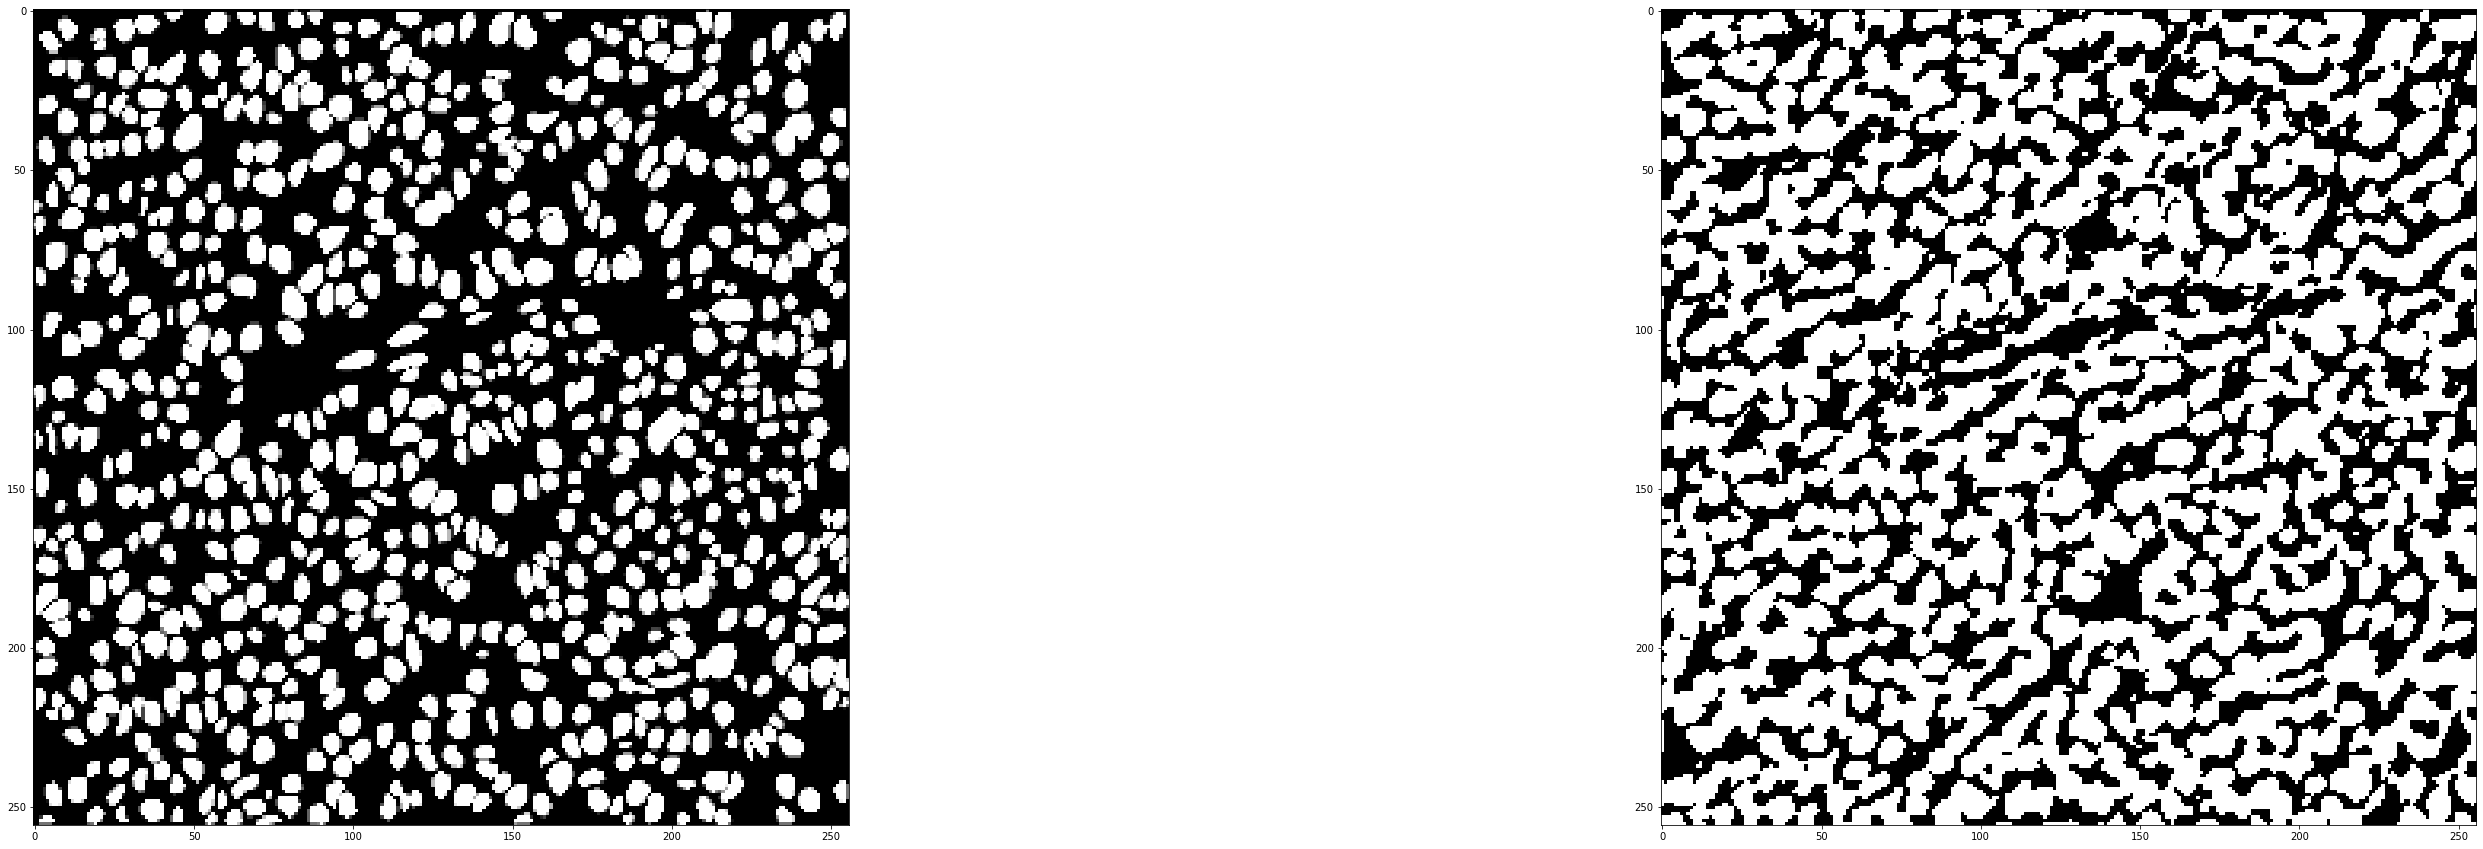

In [ ]:
# Example 1: resultant mask UNet model after halving the number of filters per layer trained using dice loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.741

tf.Tensor(0.7418804014933889, shape=(), dtype=float64)


The Dice score with the original model was 0.766 which is slightly greater than 0.741

In [ ]:
## Dataset for validation
x, y = valid_gen.__getitem__(3)
result = model3.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 2s 2s/step


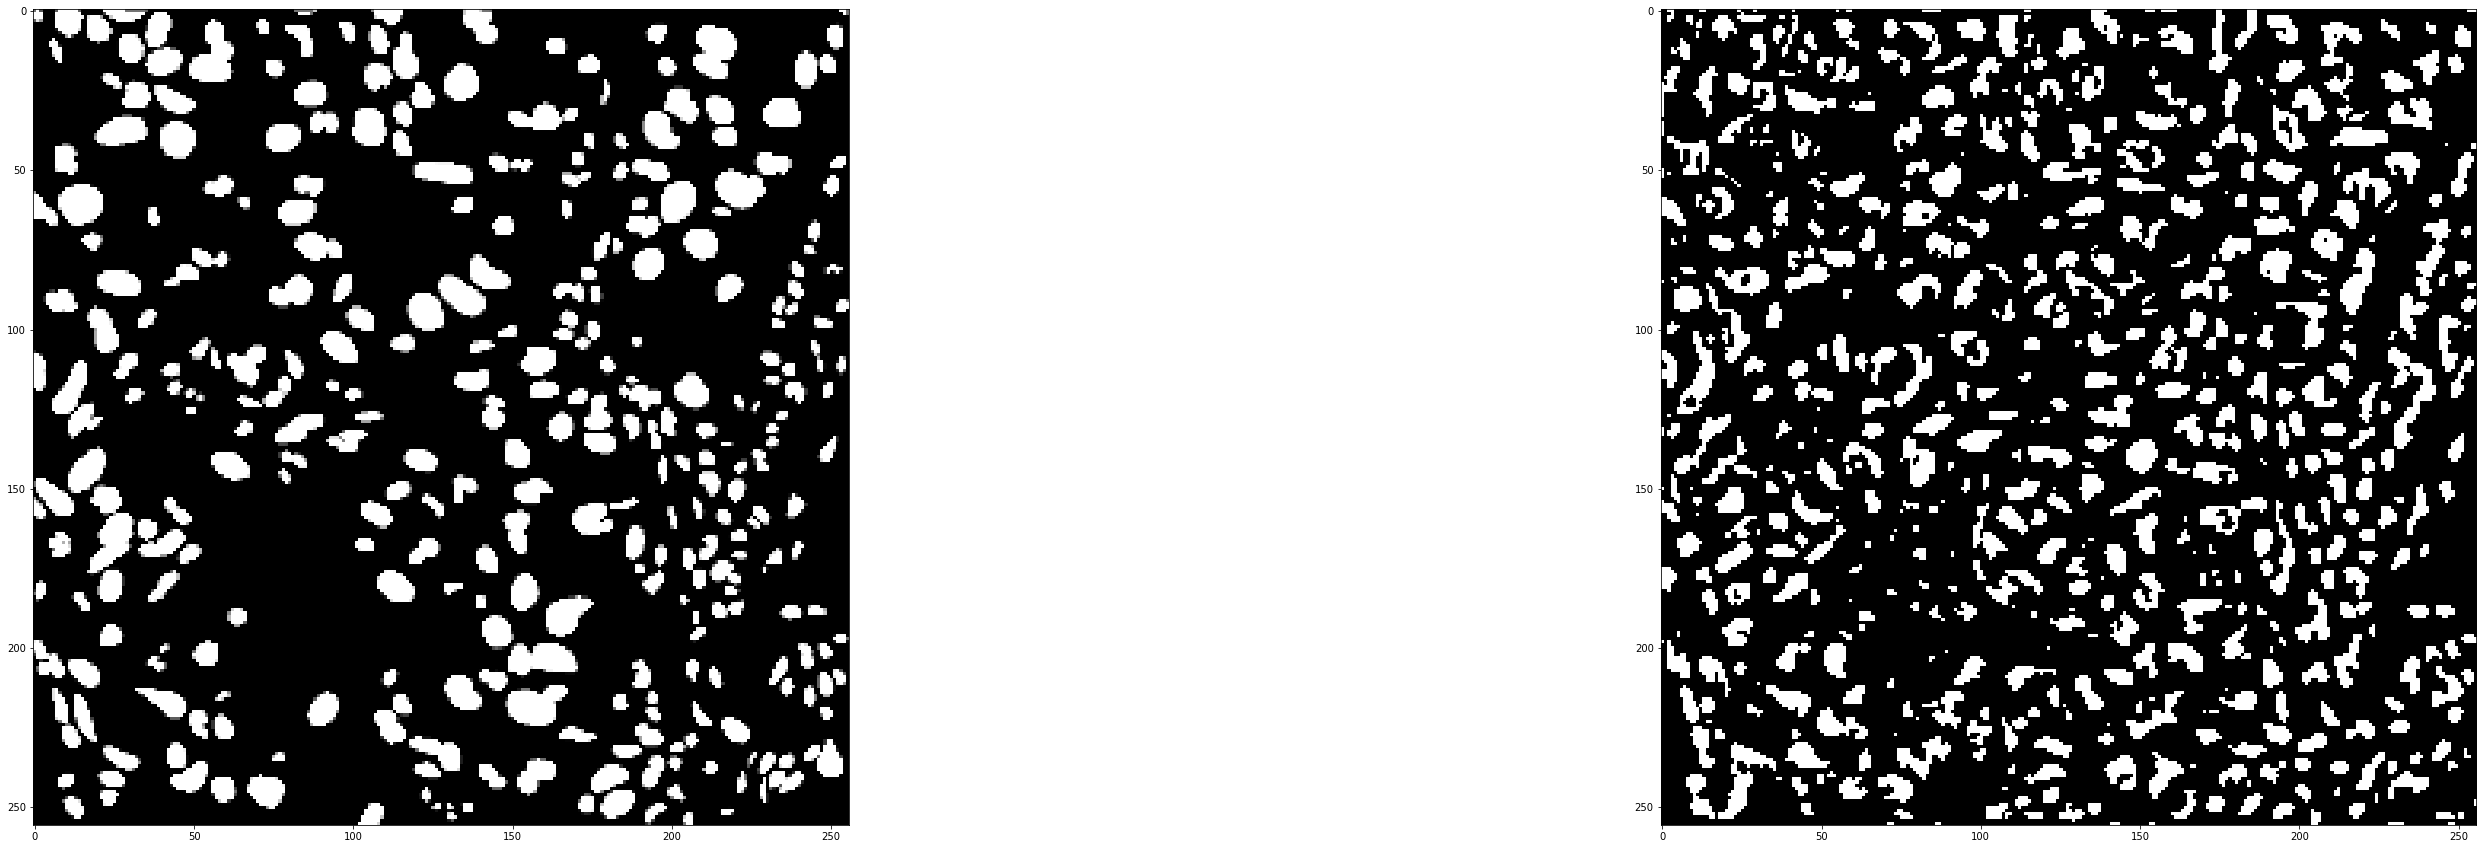

In [ ]:
# Example 2: resultant mask UNet model after halving the number of filters per layer trained using dice loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.633

tf.Tensor(0.6334121667397753, shape=(), dtype=float64)


The Dice score with the original model was 0.627 which is almost equal to 0.633

### It seems that a UNet model works best for a certain number filters per layer which can effectively downsample and upsample our image tensor. Increasing or Deacreasing the the filters in the model only worsens the fit on our data

## c. Loss function as a combination of Dice and MS-SSIM with a trade-off parameter

###Credits to https://www.tensorflow.org/api_docs/python/tf/image/ssim_multiscale

In [ ]:
# Defining a function for loss which combines dice and MS-SSIM with a trade-off parameter, alpha
def DiceSSIMLoss(alpha):
    def call(y_true, y_pred):
        #flatten label and prediction tensors
        y_1 = tf.expand_dims(y_true, axis=0) #Expanding dimensions of the image tensor to fit as an imput parameter to tf.image.ssim_multiscale()
        y_1 = tf.cast(y_1, tf.double) #Typecasting to a double tensor
        y_2 = tf.cast(y_pred,tf.double) #Typecasting to a double tensor


        ms_ssim = tf.image.ssim_multiscale(y_1, y_2,1,filter_size=1)  # Using function to find MS-SSIM loss
        y_pred = tf.reshape(y_pred, [-1])
        y_true = tf.reshape(y_true, [-1])
        intersection = tf.reduce_sum(y_true*y_pred)

        dice = (2*intersection)/(tf.reduce_sum(tf.math.square(y_true)) + tf.reduce_sum(tf.math.square(y_pred)))
        # The dice coeficient is calculated by:
        # Dice=2|A∩B|/|A|+|B| where numerator can be approximated as the element-wise multiplication between the prediction and true masks, then summing the resulting matrix and |A| is the squared sum of elements of A.
        return alpha*(1-dice) + (1-alpha)*(1-ms_ssim)  # Returning the loss value which is a combination of dice loss and MS-SSIM
    return call


### Taking alpha=0.2

In [ ]:
model_dice_ssim = UNet()
model_dice_ssim.compile(optimizer="adam", loss=DiceSSIMLoss(alpha=0.2), metrics=["acc"]) # Configuring the model for training using dice loss and optimizing using Adam algorithm
model_dice_ssim.summary() #Summary of the UNet model

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_209 (Conv2D)            (None, 256, 256, 32  896         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_210 (Conv2D)            (None, 256, 256, 32  9248        ['conv2d_209[0][0]']             
                                )                                                          

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)#Gerating the Training Dataset
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Validation Dataset

train_steps = len(train_ids)//batch_size #Number of steps in training
valid_steps = len(valid_ids)//batch_size #Number of steps fin validating

#We invoke the UNet model defined with aplha = 0.2 to be trained on the generated Dataset
model_dice_ssim.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)


Epoch 1/5
24/24 [==============================] - 79s 3s/step - loss: 0.1491 - acc: 0.7247 - val_loss: 0.1328 - val_acc: 0.6880
Epoch 2/5
24/24 [==============================] - 67s 3s/step - loss: 0.1635 - acc: 0.5150 - val_loss: 0.1260 - val_acc: 0.6388
Epoch 3/5
24/24 [==============================] - 68s 3s/step - loss: 0.1375 - acc: 0.7815 - val_loss: 0.1042 - val_acc: 0.7159
Epoch 4/5
24/24 [==============================] - 70s 3s/step - loss: 0.1497 - acc: 0.5980 - val_loss: 0.1120 - val_acc: 0.7104
Epoch 5/5
24/24 [==============================] - 71s 3s/step - loss: 0.1224 - acc: 0.7888 - val_loss: 0.1043 - val_acc: 0.7314


In [ ]:
## Dataset for validation
x, y = valid_gen.__getitem__(1)
result = model_dice_ssim.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 1s 924ms/step


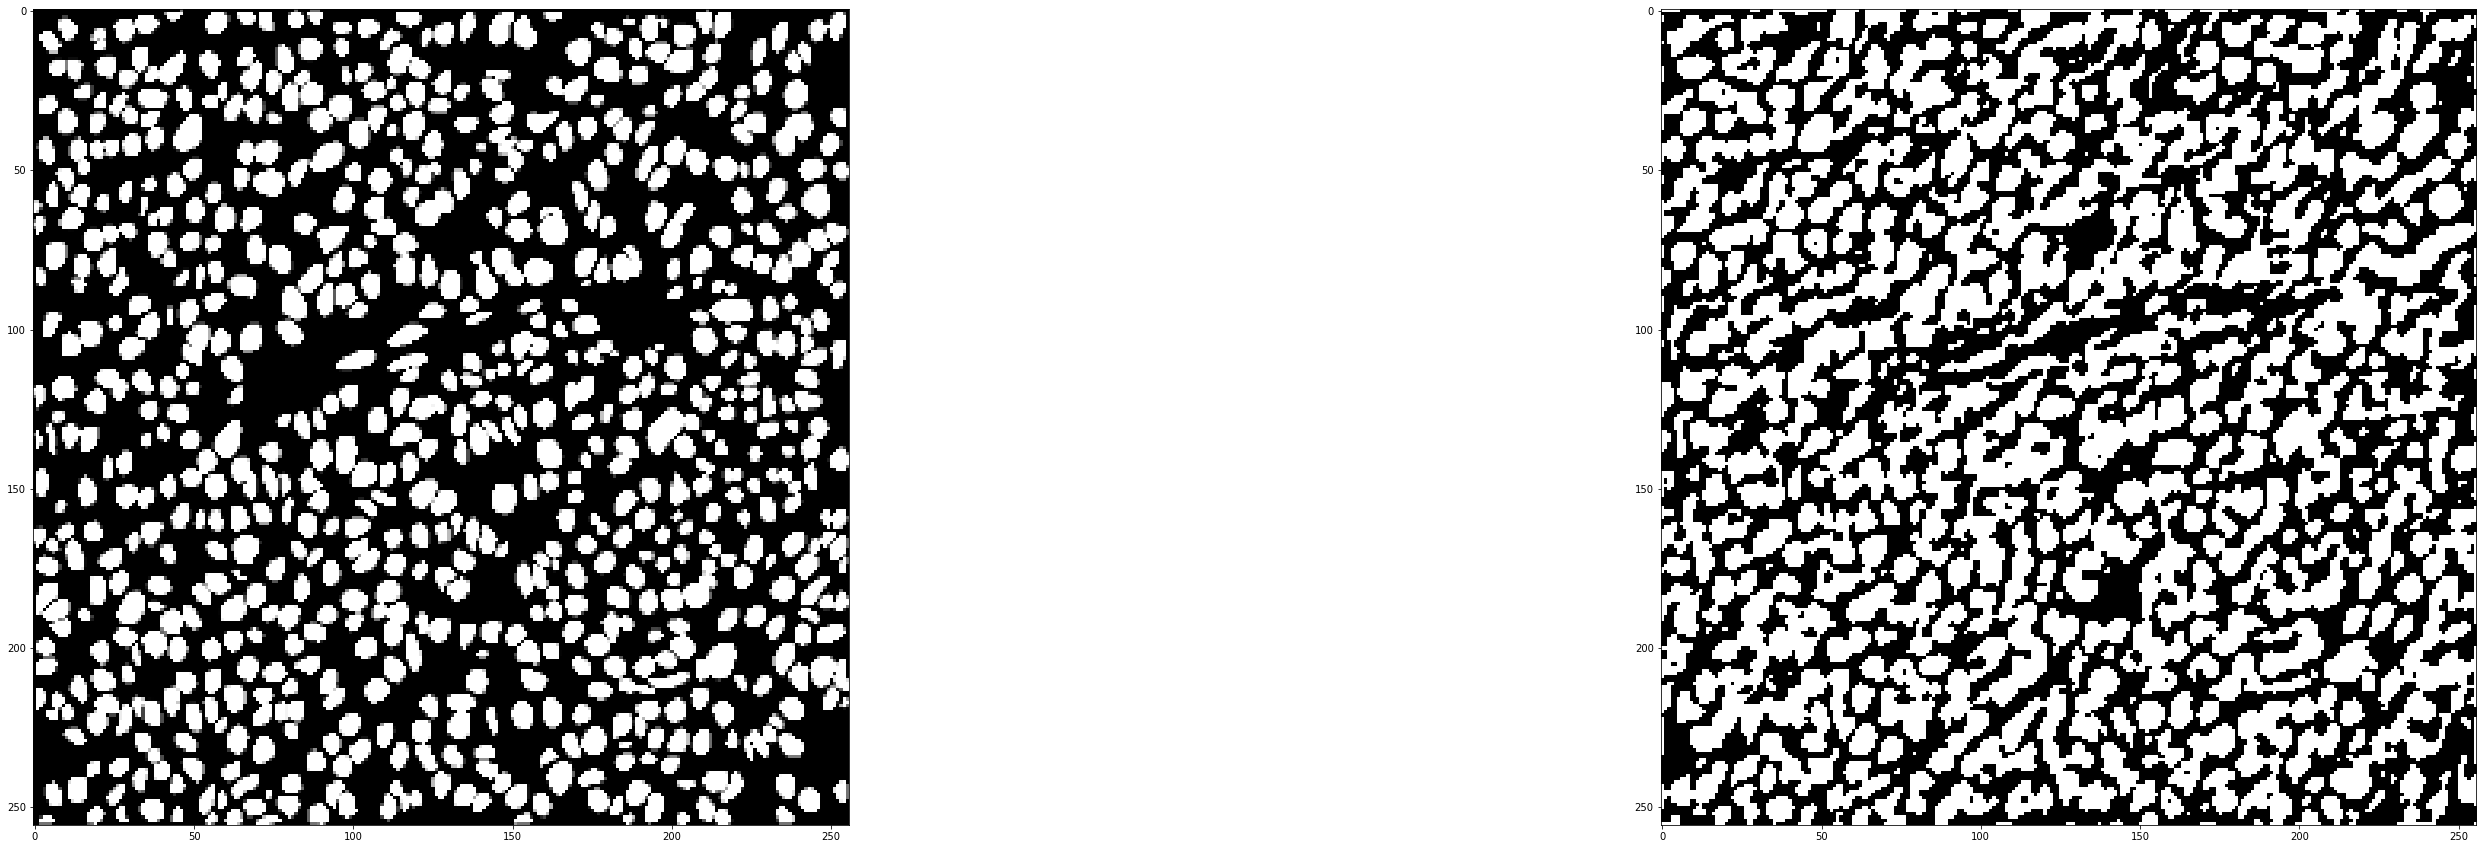

In [ ]:
# Example 1: resultant mask UNet model trained by combining dice and MS-SSIM loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.778

tf.Tensor(0.7785459592762909, shape=(), dtype=float64)


The Dice score with the original model was 0.766 which is slightly lesser than 0.778

In [ ]:
## Dataset for validation
x, y = valid_gen.__getitem__(3)
result = model_dice_ssim.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 1s 670ms/step


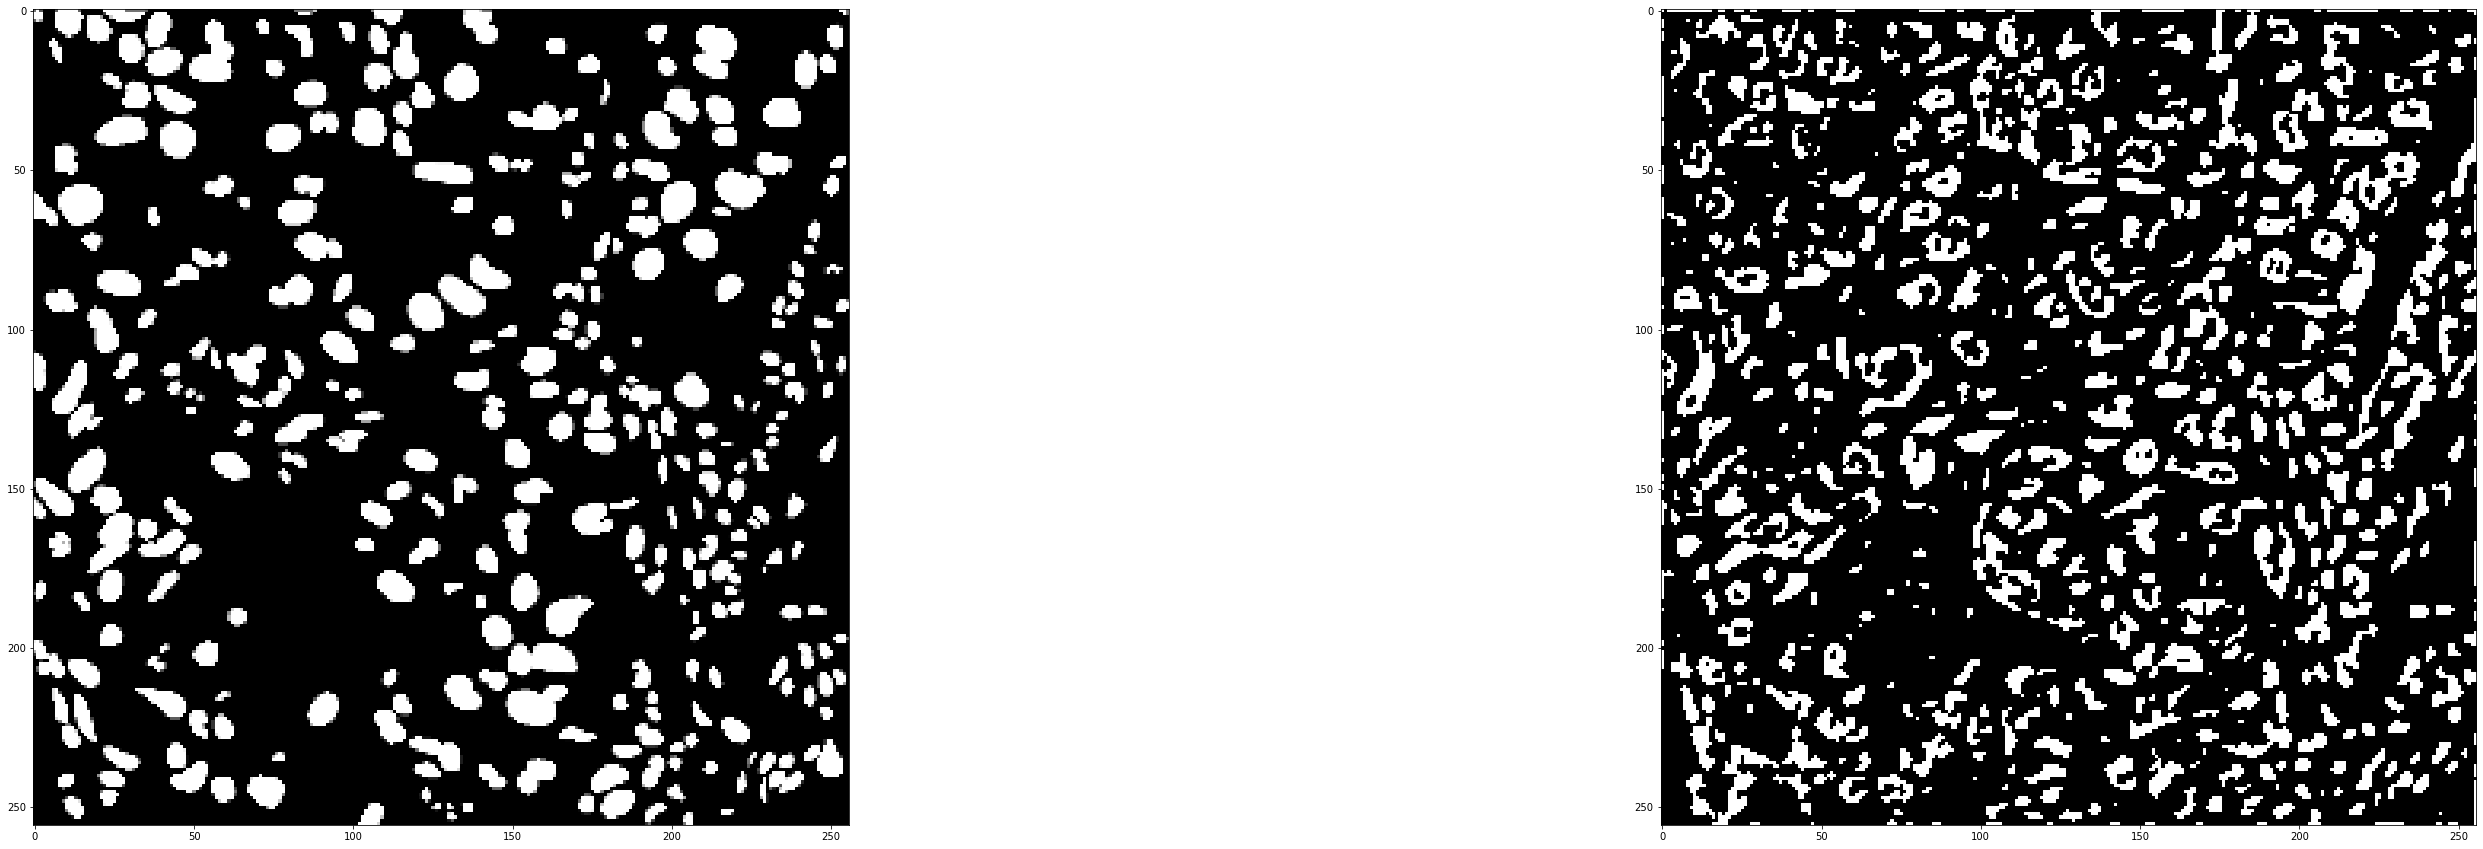

In [ ]:
# Example 2: resultant mask UNet model after halving the number of filters per layer trained using dice loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.611

tf.Tensor(0.6113504084910486, shape=(), dtype=float64)


The Dice score with the original model was 0.627 which is greater than 0.611

###Taking alpha=0.4

In [ ]:
model_dice_ssim = UNet()
model_dice_ssim.compile(optimizer="adam", loss=DiceSSIMLoss(alpha=0.4), metrics=["acc"]) # Configuring the model for training using dice loss and optimizing using Adam algorithm
model_dice_ssim.summary() #Summary of the UNet model

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 256, 256, 32  896         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_153 (Conv2D)            (None, 256, 256, 32  9248        ['conv2d_152[0][0]']             
                                )                                                           

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)#Gerating the Training Dataset
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Validation Dataset

train_steps = len(train_ids)//batch_size #Number of steps in training
valid_steps = len(valid_ids)//batch_size #Number of steps fin validating

#We invoke the UNet model defined with alpha = 0.4 to be trained on the generated Dataset
model_dice_ssim.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/5
24/24 [==============================] - 88s 3s/step - loss: 0.2300 - acc: 0.6902 - val_loss: 0.1786 - val_acc: 0.7287
Epoch 2/5
24/24 [==============================] - 80s 3s/step - loss: 0.1737 - acc: 0.7800 - val_loss: 0.1344 - val_acc: 0.7492
Epoch 3/5
24/24 [==============================] - 67s 3s/step - loss: 0.1873 - acc: 0.7192 - val_loss: 0.1818 - val_acc: 0.7320
Epoch 4/5
24/24 [==============================] - 77s 3s/step - loss: 0.1654 - acc: 0.7968 - val_loss: 0.1363 - val_acc: 0.7681
Epoch 5/5
24/24 [==============================] - 77s 3s/step - loss: 0.1420 - acc: 0.7958 - val_loss: 0.1637 - val_acc: 0.7611


In [ ]:
## Dataset for validation
x, y = valid_gen.__getitem__(1)
result = model_dice_ssim.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 1s 1s/step


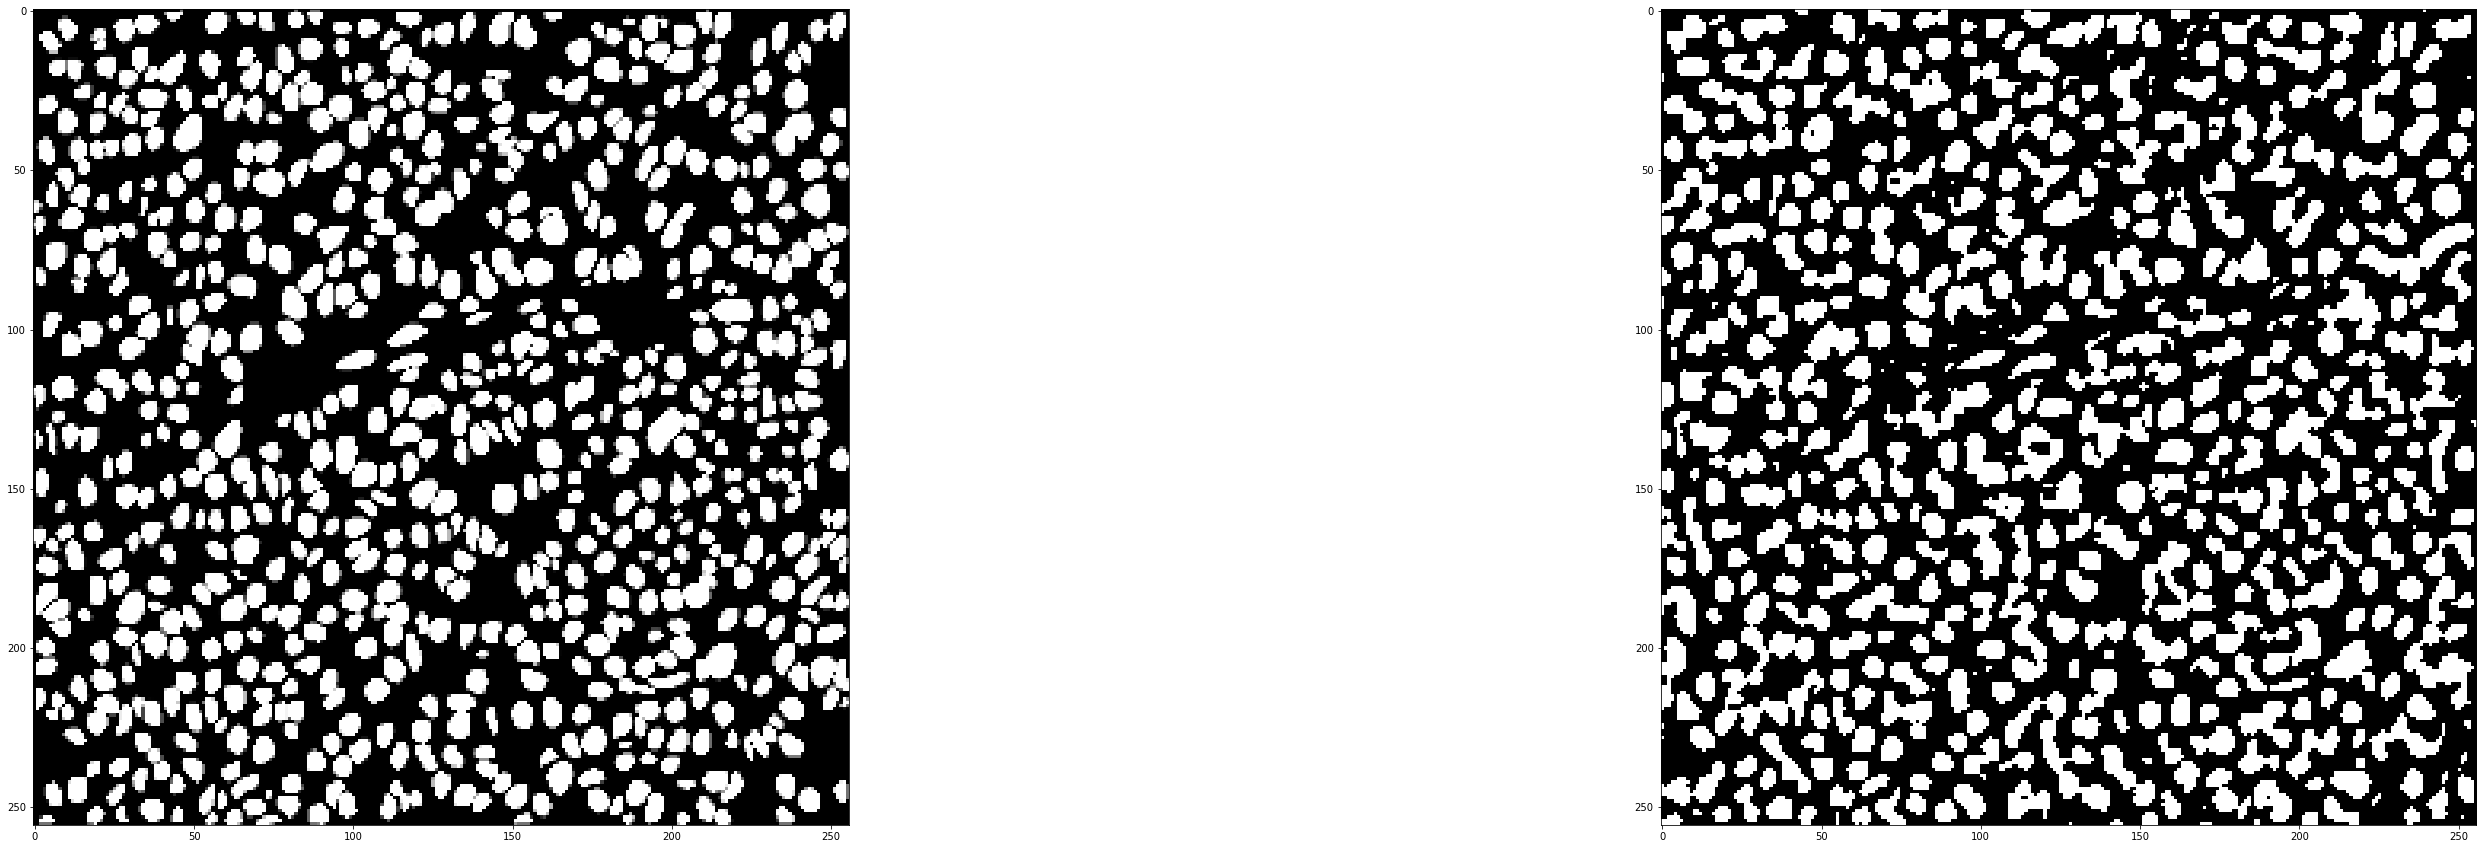

In [ ]:
# Example 1: resultant mask UNet model trained by combining dice and MS-SSIM loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.844

tf.Tensor(0.844756470426212, shape=(), dtype=float64)


The Dice score with the original model was 0.766 which is significantly lesser than 0.844

In [ ]:
## Dataset for validation
x, y = valid_gen.__getitem__(3)
result = model_dice_ssim.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 1s 623ms/step


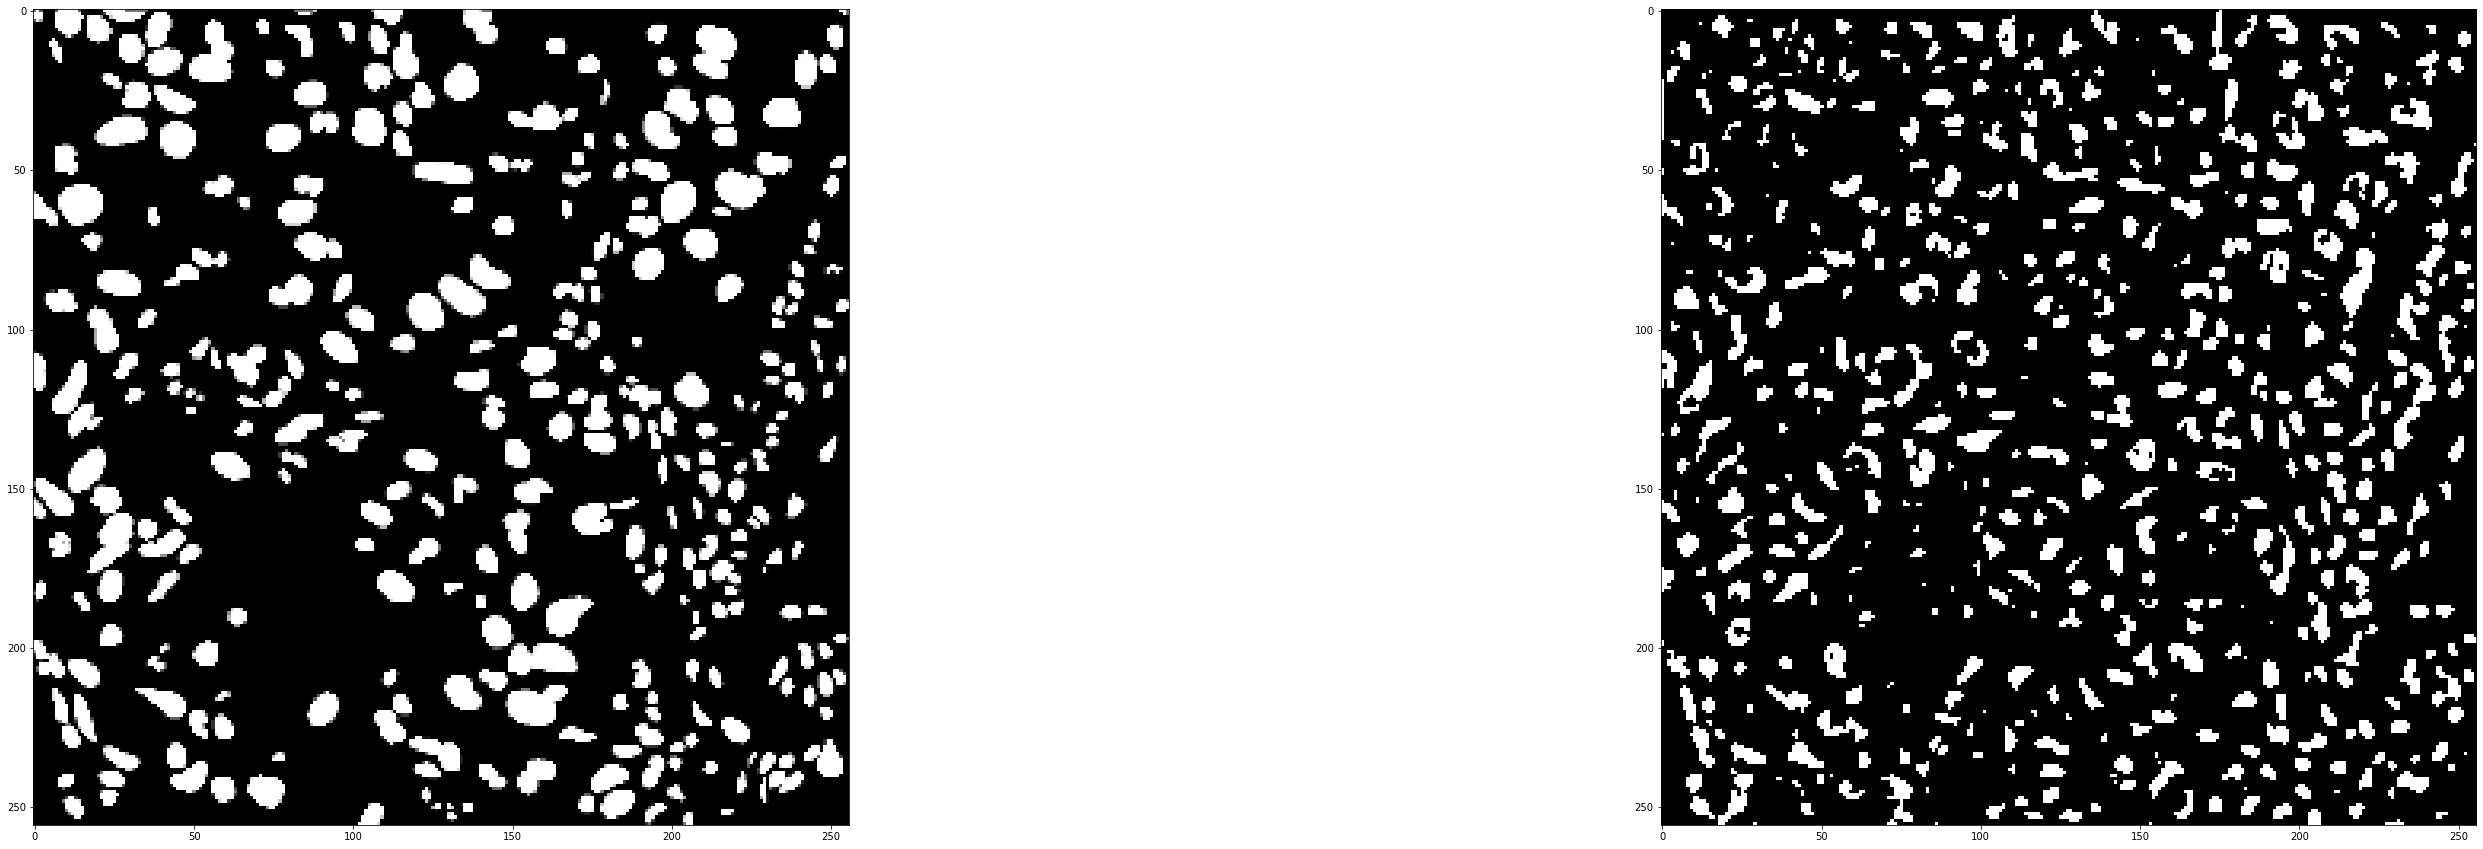

In [ ]:
# Example 2: resultant mask UNet model after halving the number of filters per layer trained using dice loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.599

tf.Tensor(0.5991977195866343, shape=(), dtype=float64)


The Dice score with the original model was 0.627 which is greater than 0.599

### Taking alpha=0.6

In [ ]:
model_dice_ssim = UNet()
model_dice_ssim.compile(optimizer="adam", loss=DiceSSIMLoss(alpha=0.6), metrics=["acc"]) # Configuring the model for training using dice loss and optimizing using Adam algorithm
model_dice_ssim.summary() #Summary of the UNet model

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_171 (Conv2D)            (None, 256, 256, 32  896         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_172 (Conv2D)            (None, 256, 256, 32  9248        ['conv2d_171[0][0]']             
                                )                                                           

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)#Gerating the Training Dataset
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Validation Dataset

train_steps = len(train_ids)//batch_size #Number of steps in training
valid_steps = len(valid_ids)//batch_size #Number of steps fin validating

#We invoke the UNet model defined with aplha = 0.6 to be trained on the generated Dataset
model_dice_ssim.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/5
24/24 [==============================] - 76s 3s/step - loss: 0.2953 - acc: 0.6697 - val_loss: 0.3104 - val_acc: 0.6979
Epoch 2/5
24/24 [==============================] - 67s 3s/step - loss: 0.2302 - acc: 0.7729 - val_loss: 0.2122 - val_acc: 0.7344
Epoch 3/5
24/24 [==============================] - 66s 3s/step - loss: 0.2239 - acc: 0.7739 - val_loss: 0.1938 - val_acc: 0.7393
Epoch 4/5
24/24 [==============================] - 87s 4s/step - loss: 0.1982 - acc: 0.7805 - val_loss: 0.1715 - val_acc: 0.7432
Epoch 5/5
24/24 [==============================] - 67s 3s/step - loss: 0.1968 - acc: 0.8065 - val_loss: 0.1756 - val_acc: 0.7524


In [ ]:
## Dataset for validation
x, y = valid_gen.__getitem__(1)
result = model_dice_ssim.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 1s 807ms/step


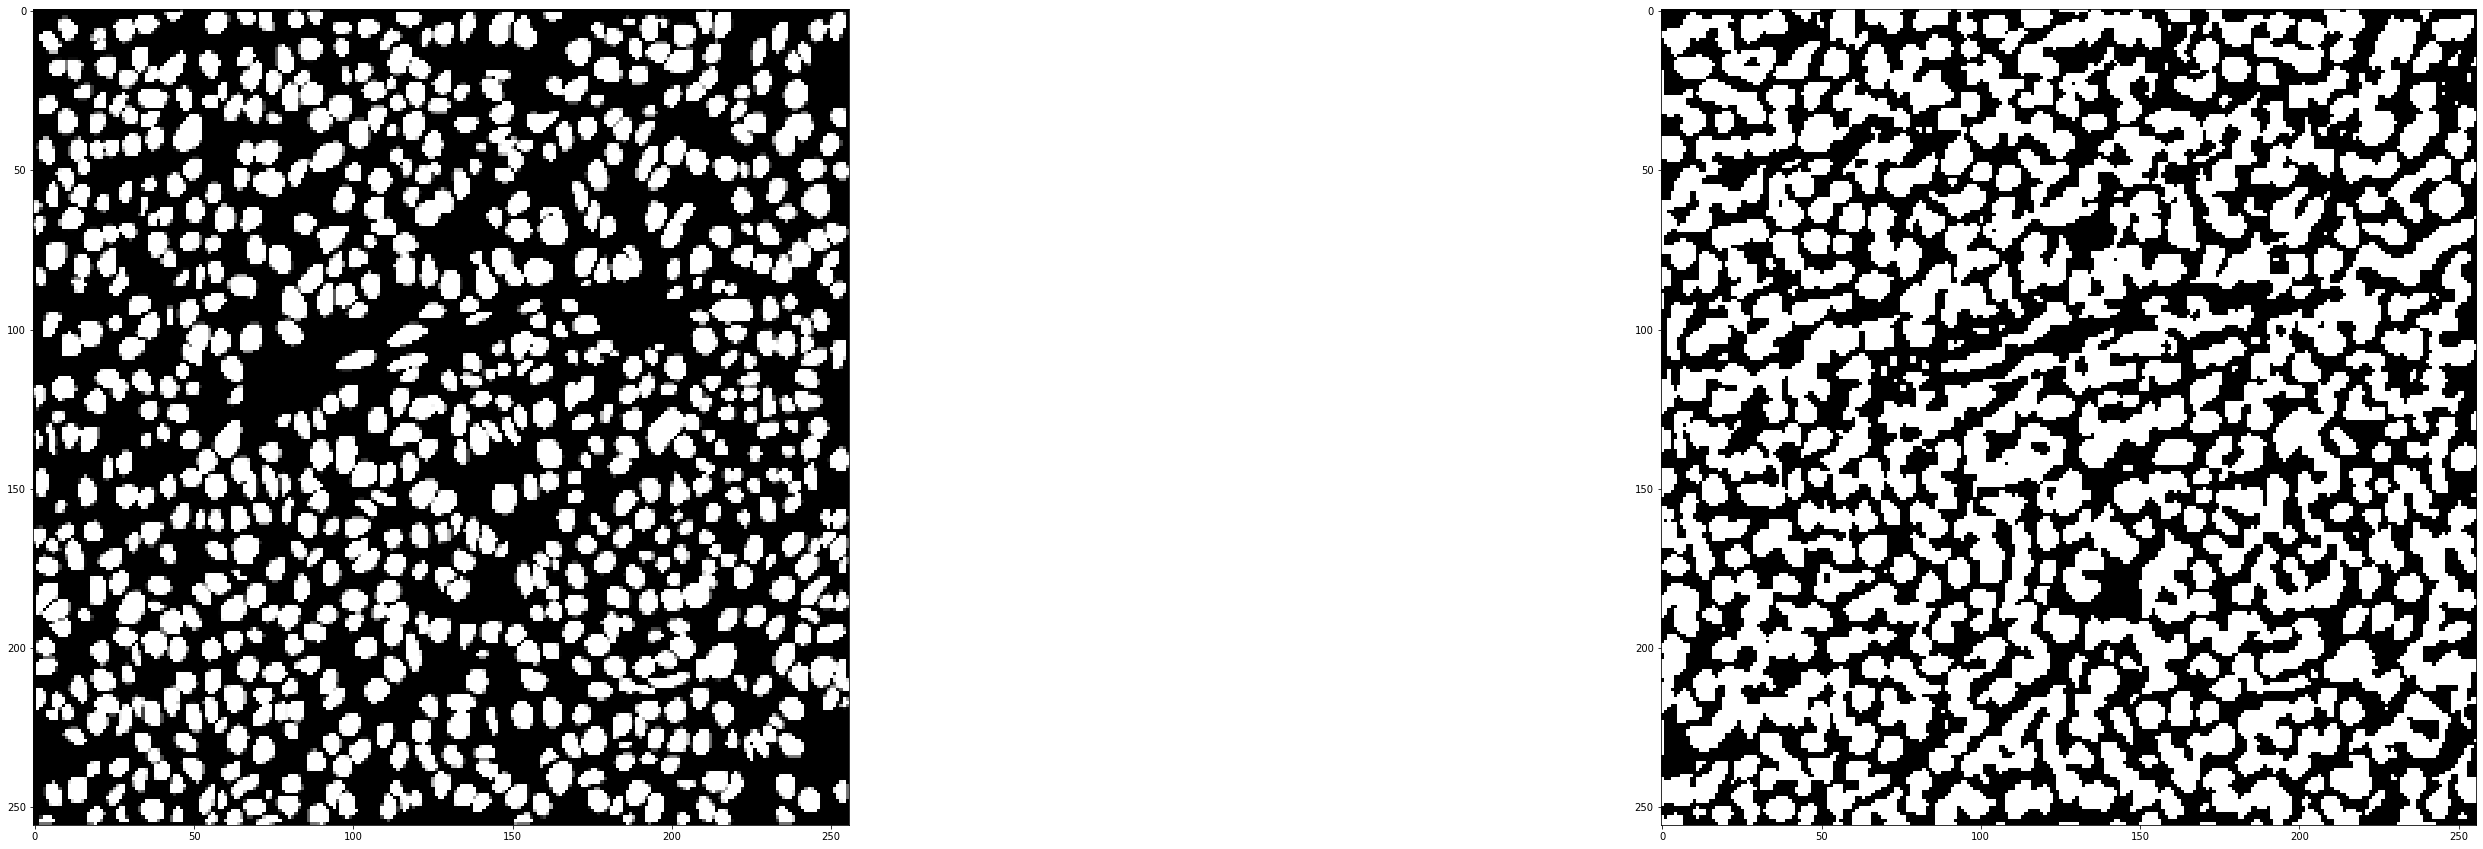

In [ ]:
# Example 1: resultant mask UNet model trained by combining dice and MS-SSIM loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.782

tf.Tensor(0.7821353601004889, shape=(), dtype=float64)


The Dice score with the original model was 0.766 which is slightly lesser than 0.782

In [ ]:
## Dataset for validation
x, y = valid_gen.__getitem__(3)
result = model_dice_ssim.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 1s 604ms/step


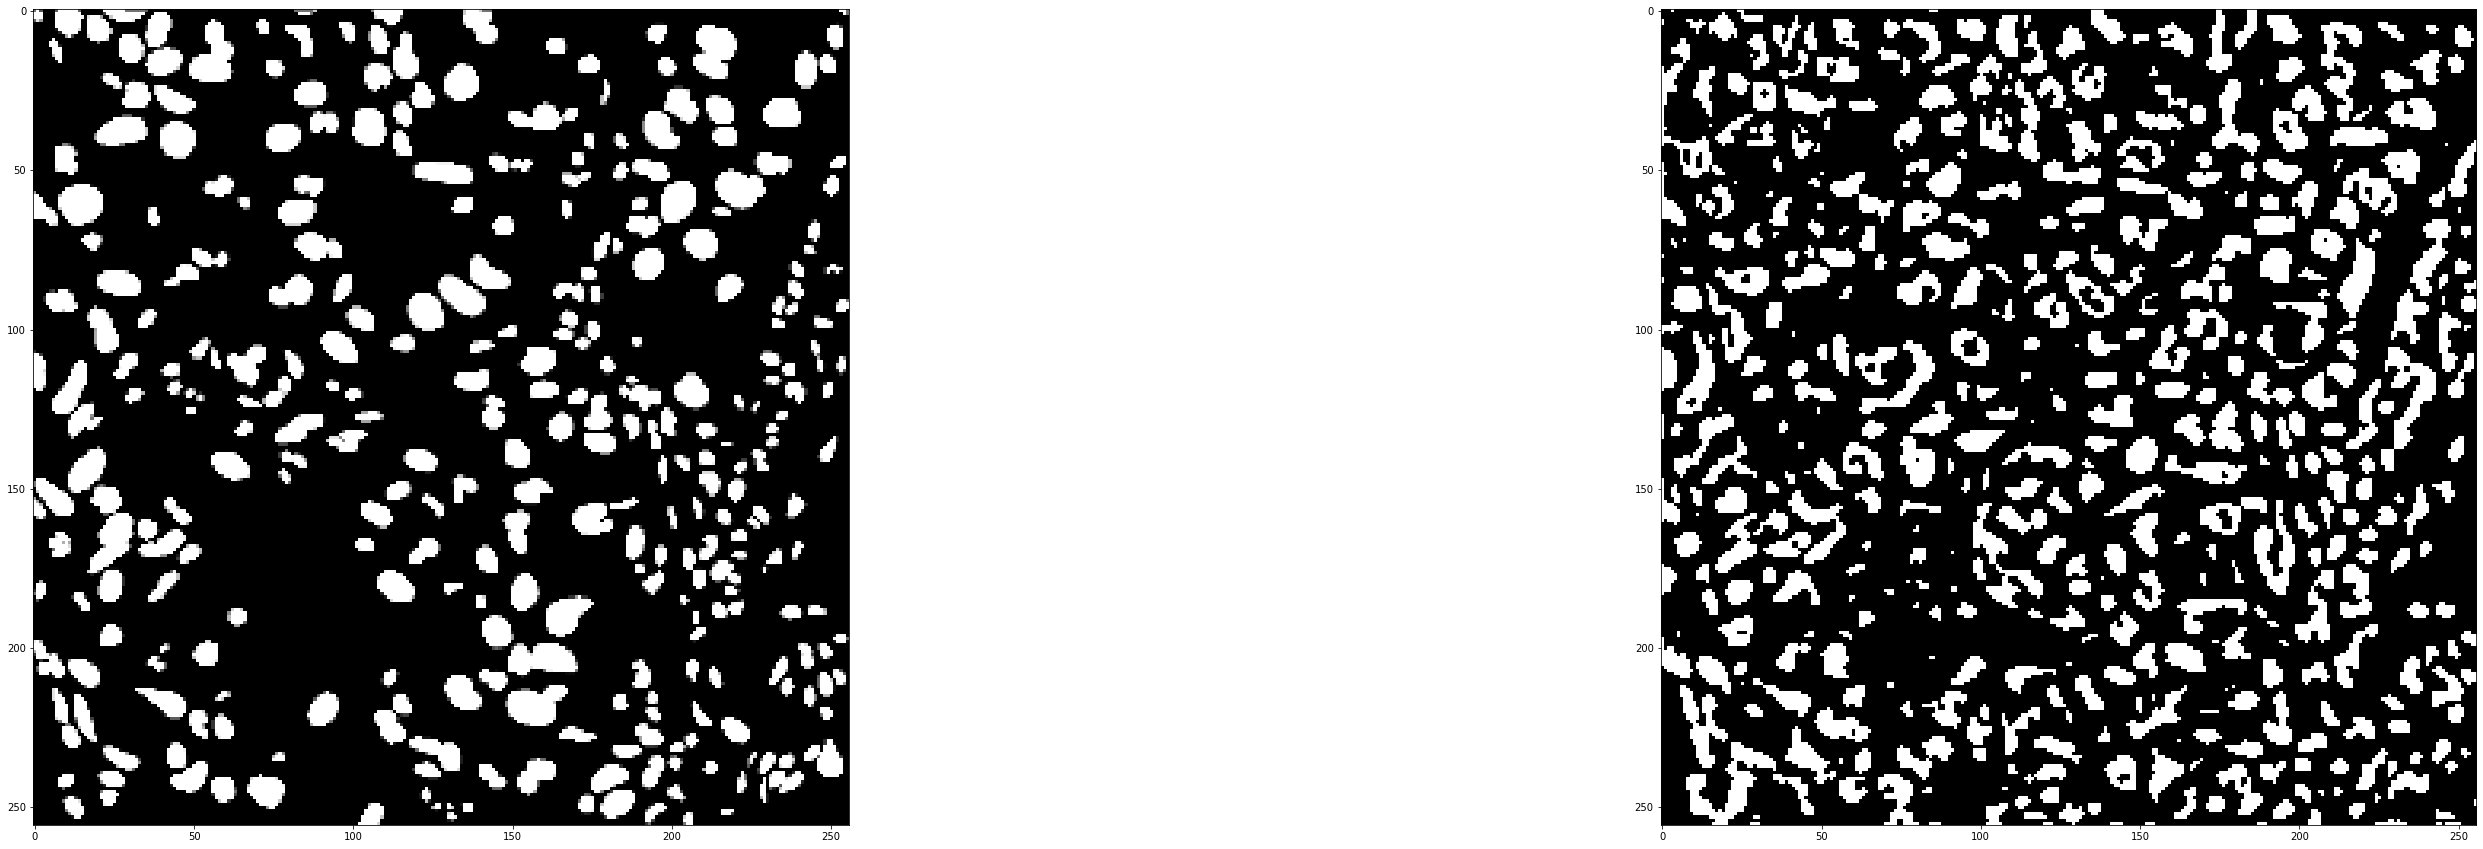

In [ ]:
# Example 2: resultant mask UNet model after halving the number of filters per layer trained using dice loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.641

tf.Tensor(0.6410793677881274, shape=(), dtype=float64)


The Dice score with the original model was 0.627 which is lesser than 0.641

### Taking alpha=0.8

In [ ]:
model_dice_ssim = UNet()
model_dice_ssim.compile(optimizer="adam", loss=DiceSSIMLoss(alpha=0.8), metrics=["acc"]) # Configuring the model for training using dice loss and optimizing using Adam algorithm
model_dice_ssim.summary() #Summary of the UNet model

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_247 (Conv2D)            (None, 256, 256, 32  896         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_248 (Conv2D)            (None, 256, 256, 32  9248        ['conv2d_247[0][0]']             
                                )                                                          

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)#Gerating the Training Dataset
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size) #Gerating the Validation Dataset

train_steps = len(train_ids)//batch_size #Number of steps in training
valid_steps = len(valid_ids)//batch_size #Number of steps fin validating

#We invoke the UNet model defined with alpha = 0.8 to be trained on the generated Dataset
model_dice_ssim.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/5
24/24 [==============================] - 78s 3s/step - loss: 0.4021 - acc: 0.6599 - val_loss: 0.3180 - val_acc: 0.7318
Epoch 2/5
24/24 [==============================] - 75s 3s/step - loss: 0.3163 - acc: 0.7318 - val_loss: 0.2392 - val_acc: 0.6602
Epoch 3/5
24/24 [==============================] - 67s 3s/step - loss: 0.2574 - acc: 0.7937 - val_loss: 0.2166 - val_acc: 0.7505
Epoch 4/5
24/24 [==============================] - 70s 3s/step - loss: 0.2511 - acc: 0.7856 - val_loss: 0.2299 - val_acc: 0.7569
Epoch 5/5
24/24 [==============================] - 89s 4s/step - loss: 0.2261 - acc: 0.8043 - val_loss: 0.2082 - val_acc: 0.7288


In [ ]:
## Dataset for validation
x, y = valid_gen.__getitem__(1)
result = model_dice_ssim.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 2s 2s/step


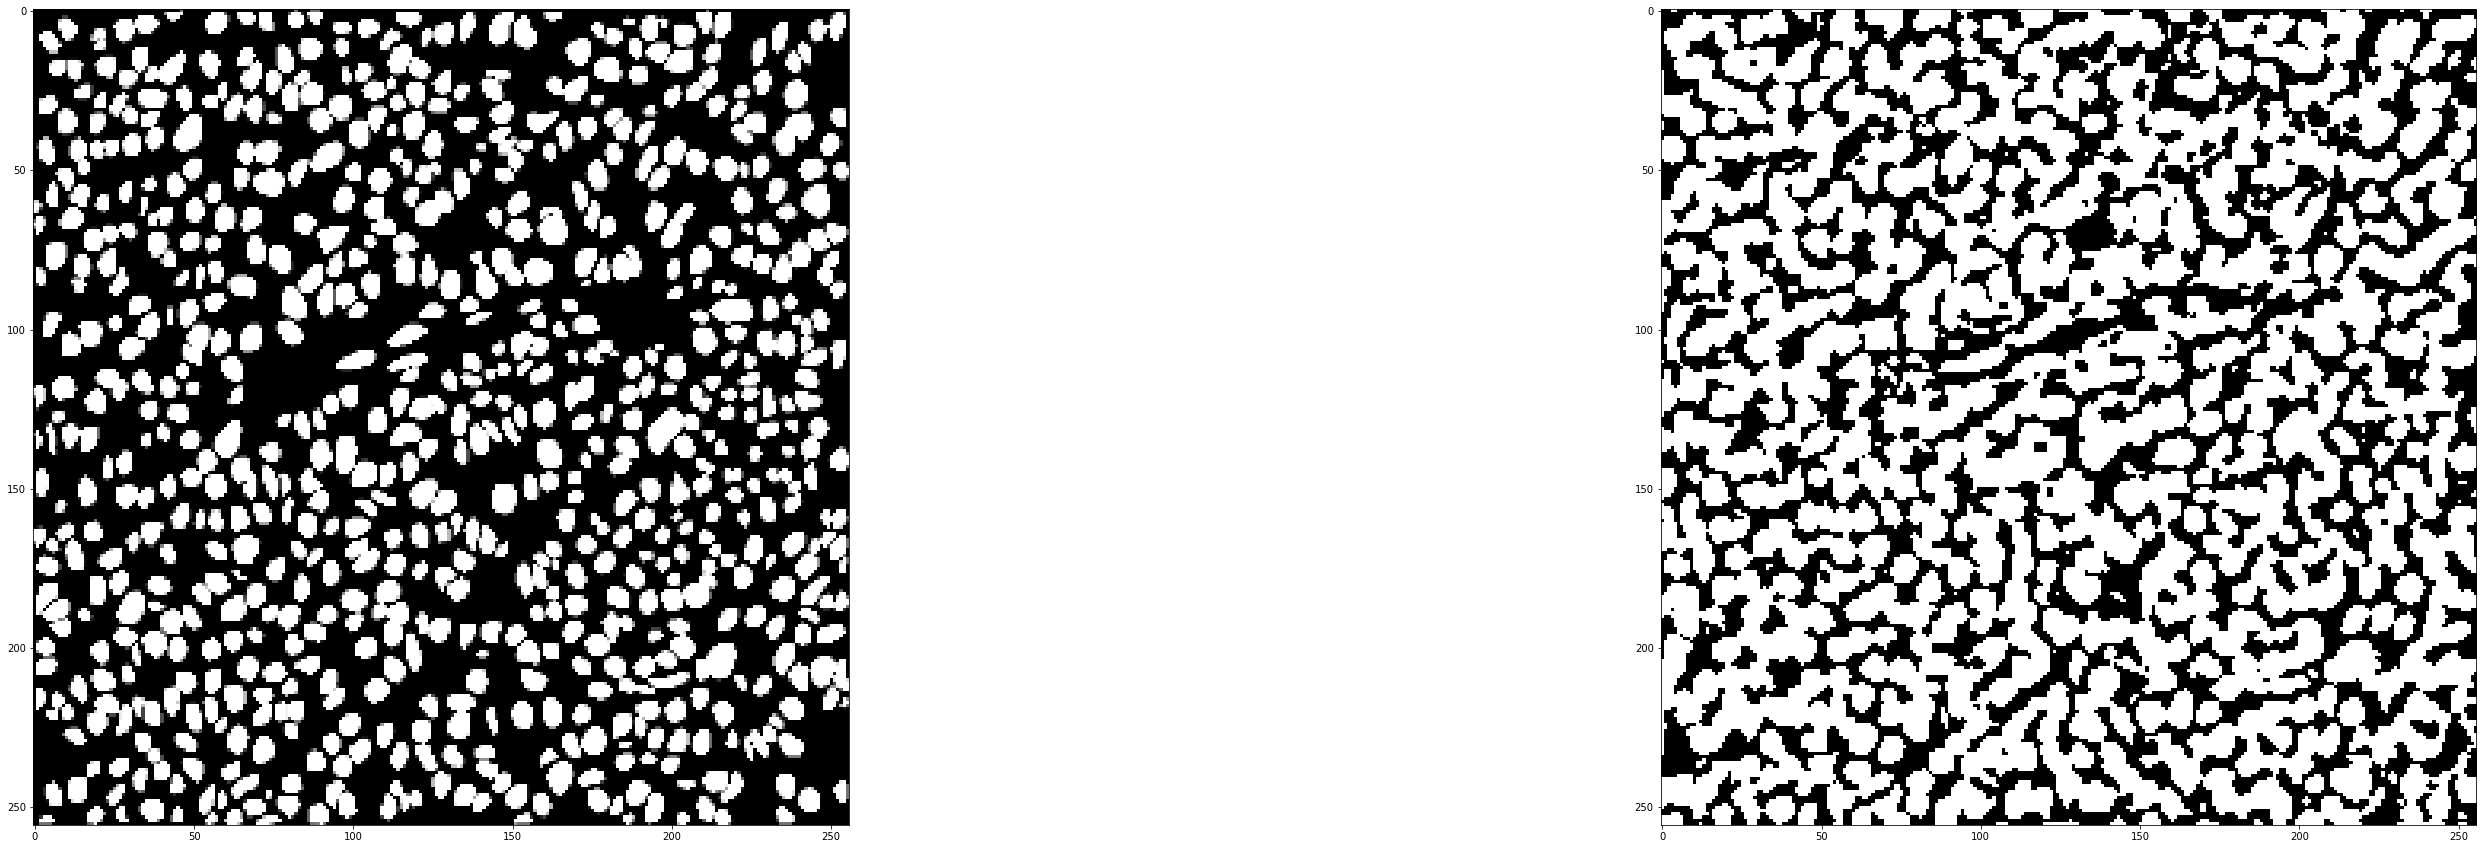

In [ ]:
# Example 1: resultant mask UNet model trained by combining dice and MS-SSIM loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.736

tf.Tensor(0.7363219980187461, shape=(), dtype=float64)


The Dice score with the original model was 0.766 which is greater than 0.736

In [ ]:
## Dataset for validation
x, y = valid_gen.__getitem__(3)
result = model_dice_ssim.predict(x)

result = result > 0.5 #Gives value 1 if result of model, i.e., probability of pixel of being a nucleas is greater than 0.5

1/1 [==============================] - 1s 965ms/step


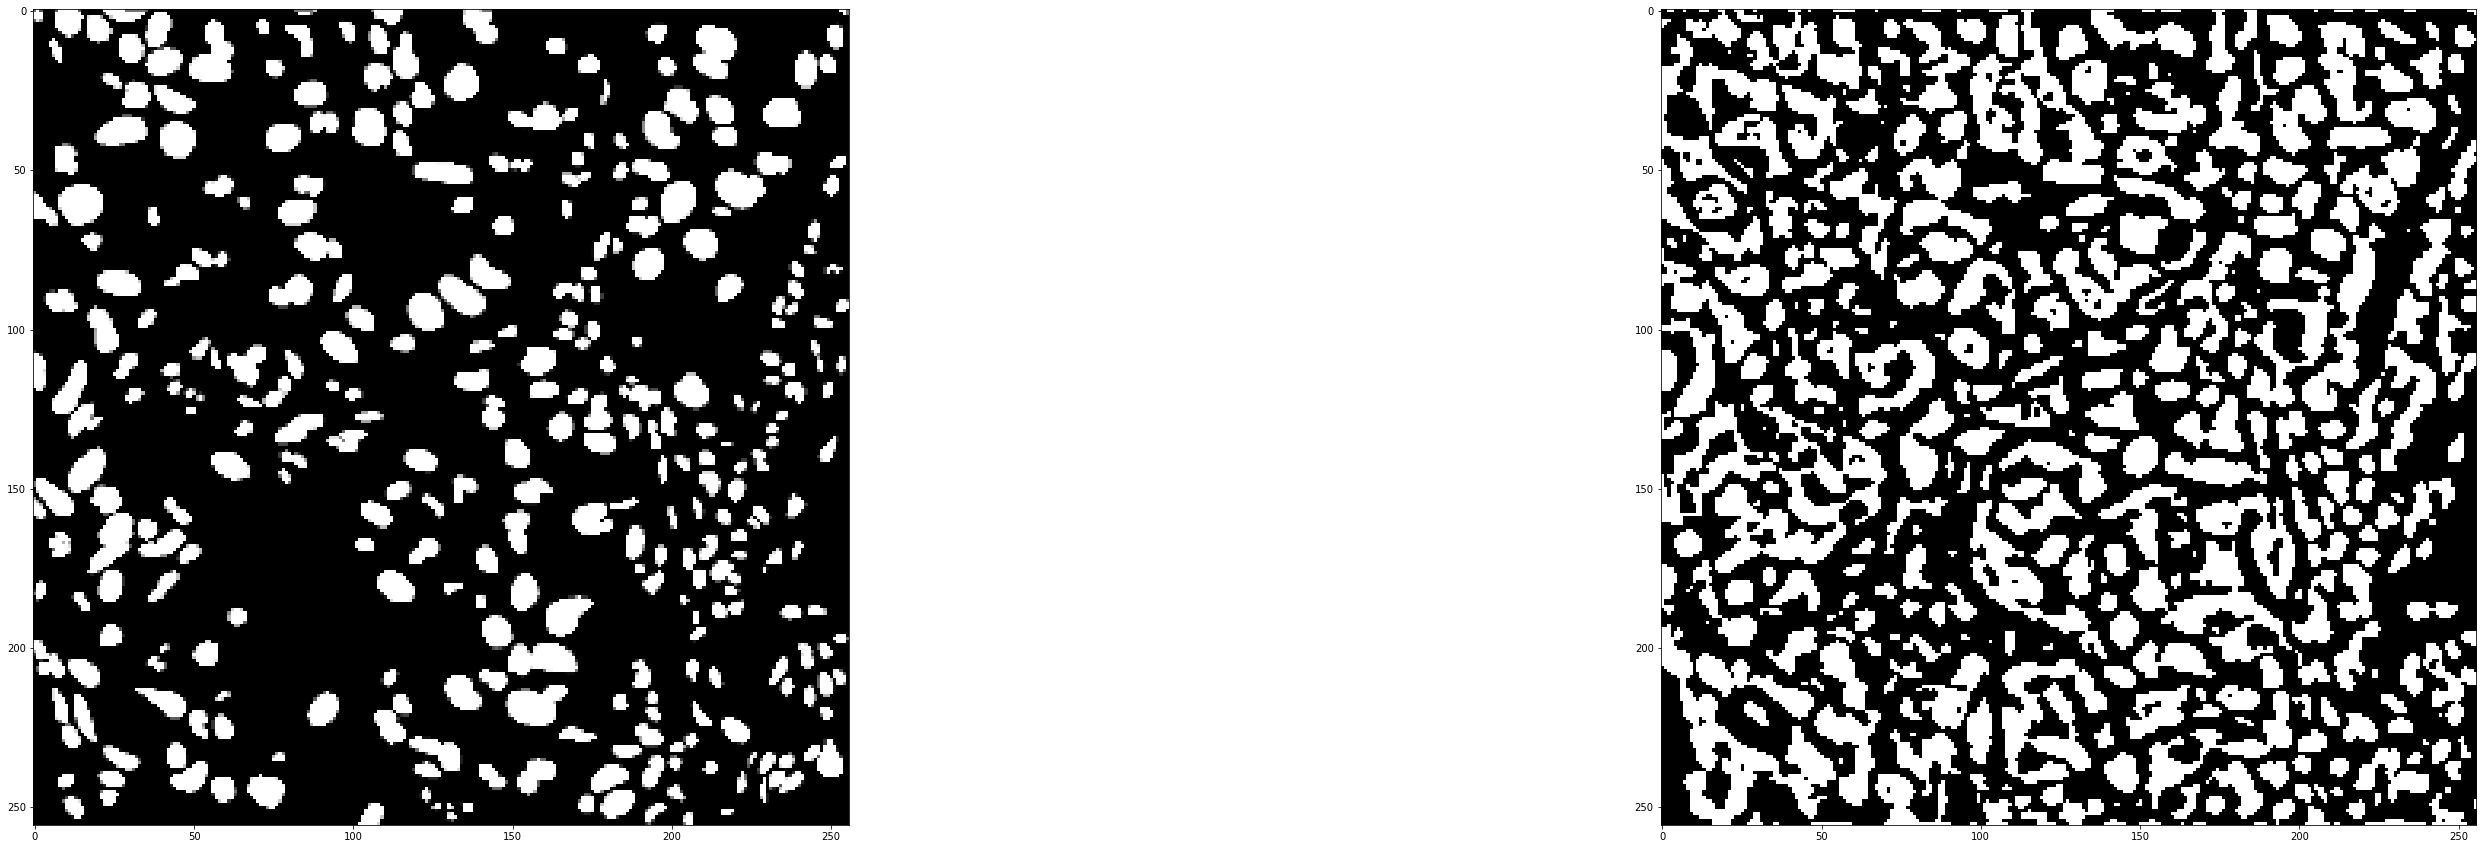

In [ ]:
# Example 2: resultant mask UNet model after halving the number of filters per layer trained using dice loss
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# Dice Score of the above validation image
print(DiceScore_f(y[0].astype(float),result[0].astype(float)))
# Dice Score is 0.649

tf.Tensor(0.5861493589063252, shape=(), dtype=float64)


The Dice score with the original model was 0.627 which is slightly lesser than 0.649

### A combination of Dice loss and Multi-Scale SSIM has introduced slight improvements in the dice score of our example validation images. Testing the model with alpha = 0.2, 0.4, 0.6 and 0.8 has given most better results at alpha = 0.6, i.e loss = 0.6*DiceLoss + 0.4*MS-SSIMLoss

# 6. Use watershed segmentation on the probability map produced by the UNet to segment individual nuclei, and show results on test images with touching or overlapping nuclei. Experiment with various parameters of watershed algorithms to try to improve the results [3]

### Reference for the section below https://www.aegissofttech.com/articles/watershed-algorithm-and-limitations.html

In [ ]:
x, y = valid_gen_dice.__getitem__(2) #Loading the Original Tisuue image and Binary-Mask
result = model2.predict(x) #Using Model2 to predict the resulting PMF

1/1 [==============================] - 1s 1s/step


In [ ]:
segmented = (model2.predict(x) > 0.5).astype(np.uint8) #Deriving the segmented image from the resulting PMF

1/1 [==============================] - 1s 552ms/step


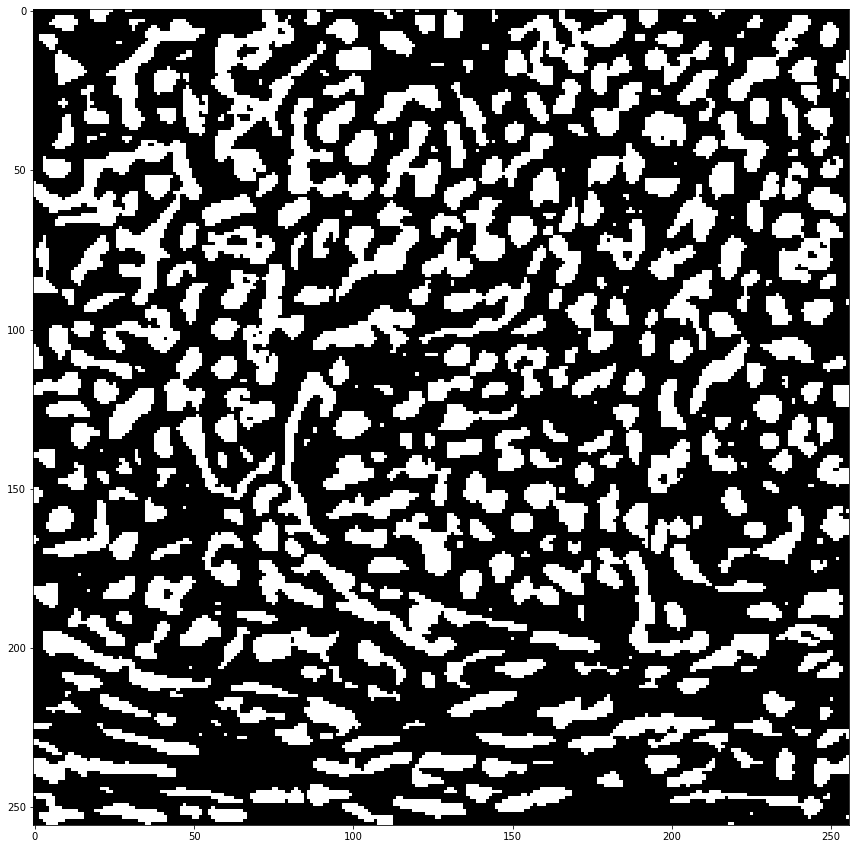

In [ ]:
#Plotting the obtained Segmented Image
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(segmented[0]*255, (image_size, image_size)), cmap="gray")
plt.show()

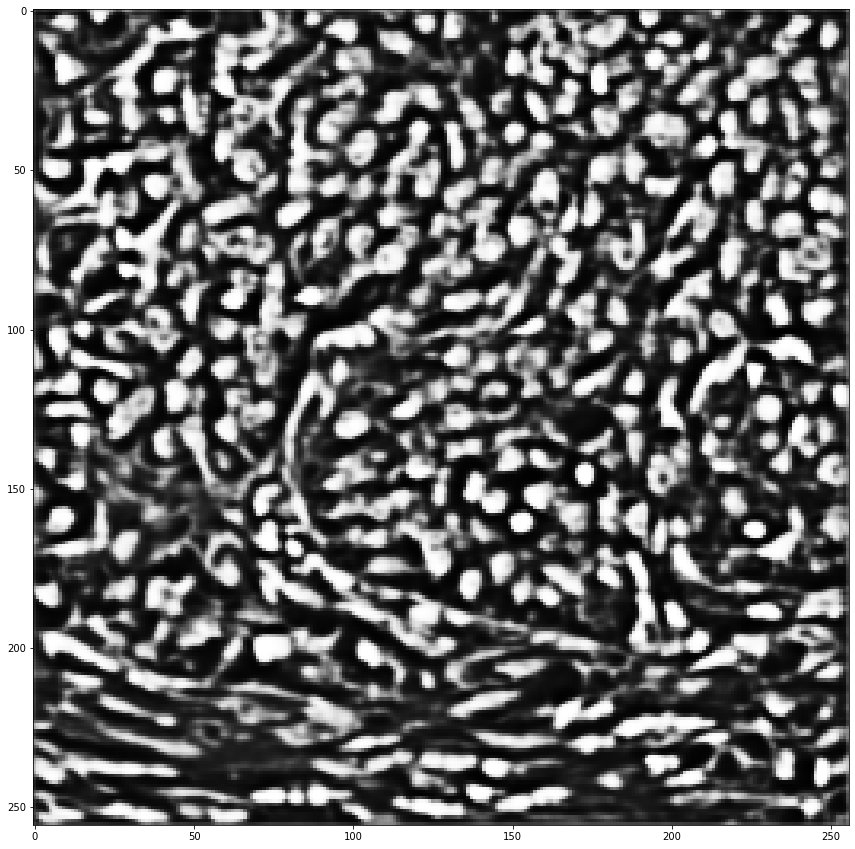

In [ ]:
img=result[0]*255 #Scaling the PMF to a dynamic range of 256

#Plotting the PMF
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(img, (image_size, image_size)), cmap="gray")
plt.show()

In [ ]:
#Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255, to transform the unet result to binary image
thresh_val, thresh = cv2.threshold(img.astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

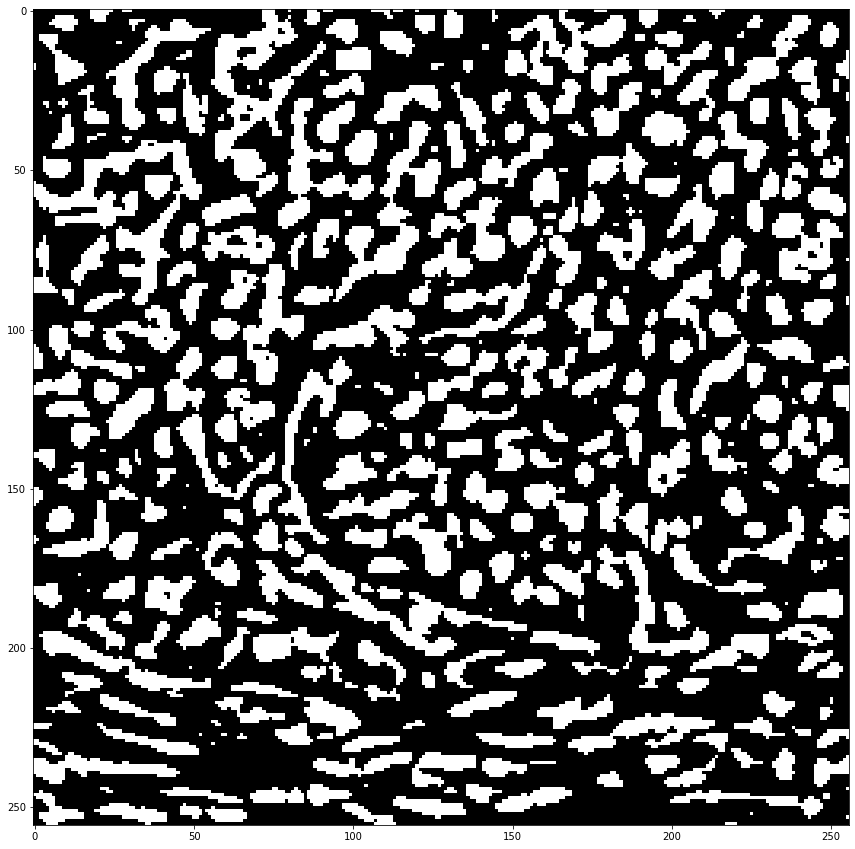

In [ ]:
#Plotting the thresholded image
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(thresh, (image_size, image_size)), cmap="gray")
plt.show()

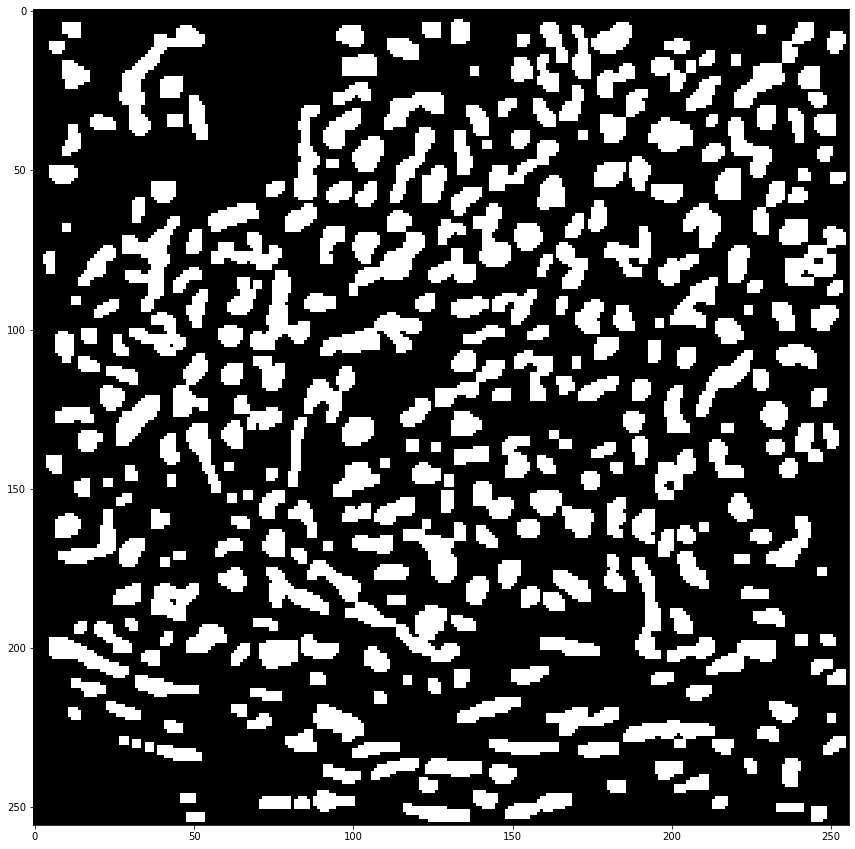

In [ ]:
# Morphological operations to remove small noise - opening | The Parameters used from here on are subject to change to derive better results

kernel = np.ones((2,2),np.uint8) #Using a 2x2 Kernel to create openings
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2) #Number of Itereations is set to 2

from skimage.segmentation import clear_border
opening = clear_border(opening) #Remove edge touching grains.

#Plotting image obtained after Opening
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(opening, (image_size, image_size)), cmap="gray")
plt.show()

Defining the region we are sure of as the background

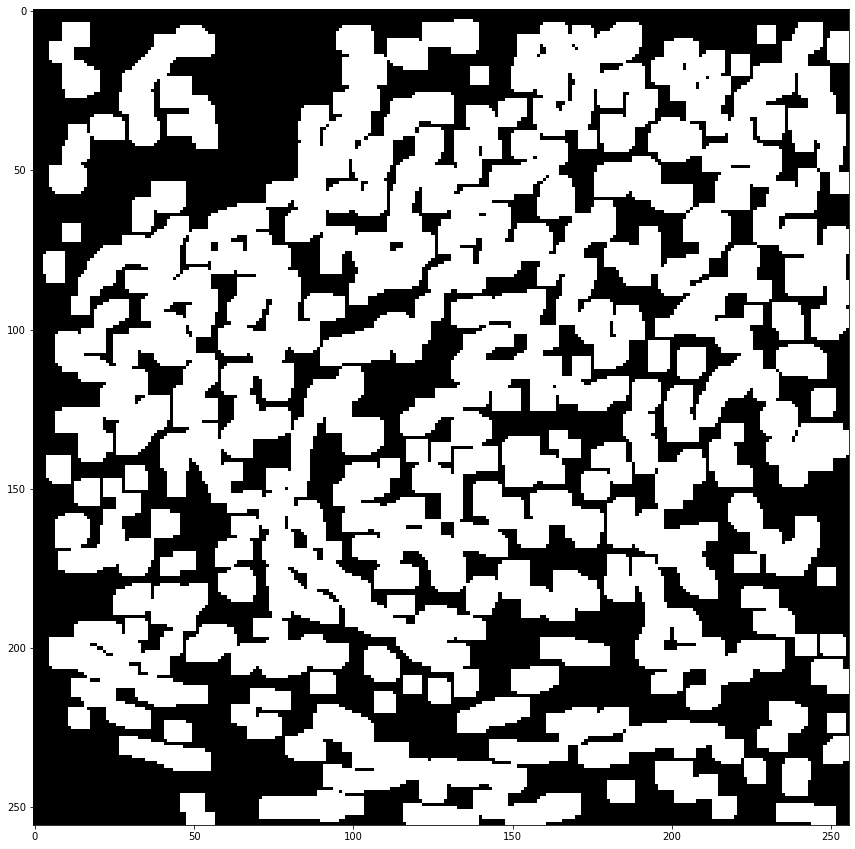

In [ ]:
sure_bg = cv2.dilate(opening,kernel,iterations=3) # Sure background obtained upon dilating the image abtained after opening

# Plotting the Sure Background
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(sure_bg, (image_size, image_size)), cmap="gray")
plt.show()

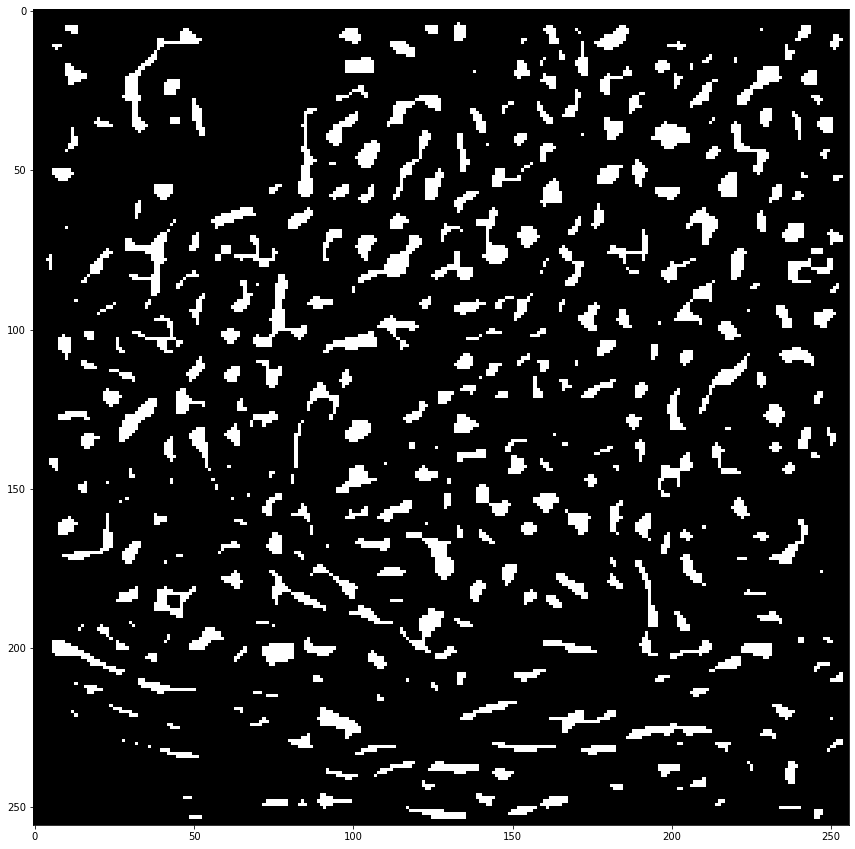

In [ ]:
# Finding sure foreground area using distance transform and thresholding
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
thresh_val2, sure_fg = cv2.threshold(dist_transform, 0.3*dist_transform.max(),255,0) #We can threshold the dist_transform to various values
#For now let's take 0.3 times its maximum value

#Plotting the Sure Foreground
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(sure_fg, (image_size, image_size)), cmap="gray")
plt.show()

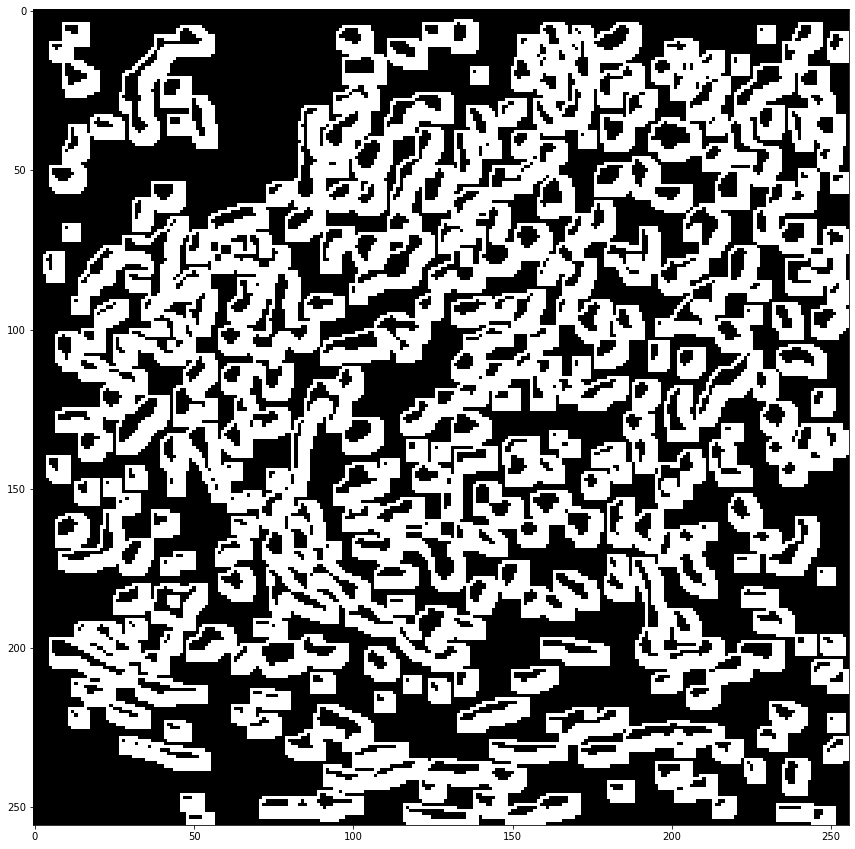

In [ ]:
# Unknown ambiguous region is background - foreground
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg) #Subtracting Sure_bg and Sure_fg

#Plotting the Unknown regions
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(unknown, (image_size, image_size)), cmap="gray")
plt.show()

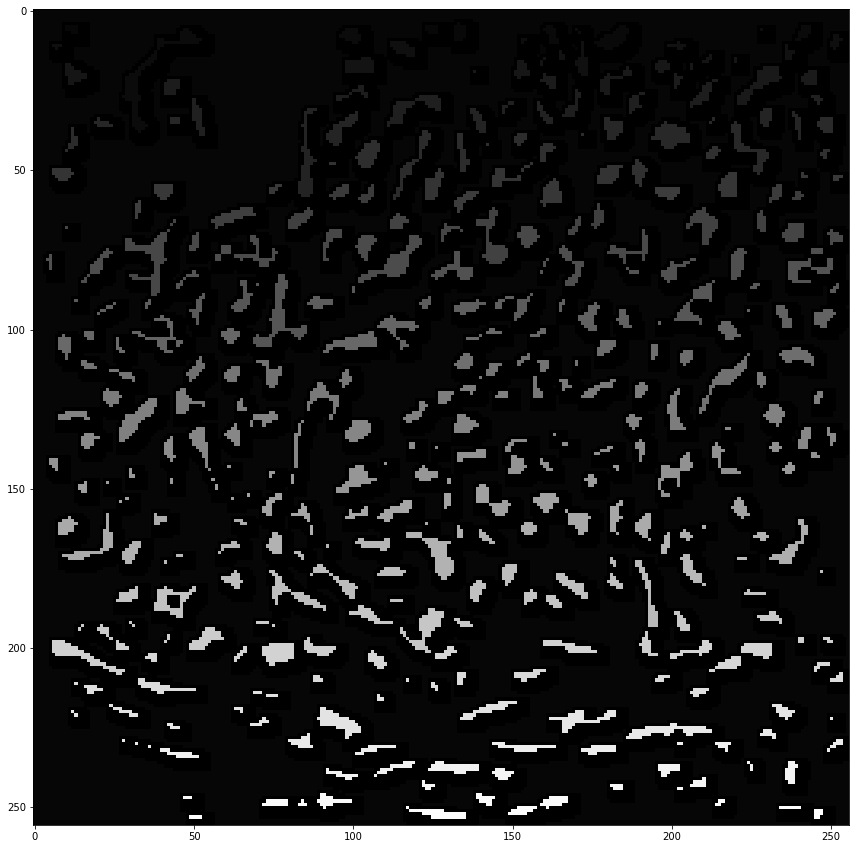

In [ ]:
# For sure regions, both foreground and background will be labeled with positive numbers.
# Unknown regions will be labeled 0.
ret1, markers = cv2.connectedComponents(sure_fg)

# entire background pixels is given value 0, adding 10 to all labels so that sure background is not 0, but 10 and only unknown region is 0
markers = markers+10

## Making the unknown area as 0
markers[unknown == 255] = 0

#Plotting the Makrkers of individual segemeted Nuclei
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(markers, (image_size, image_size)), cmap="gray")
plt.show()

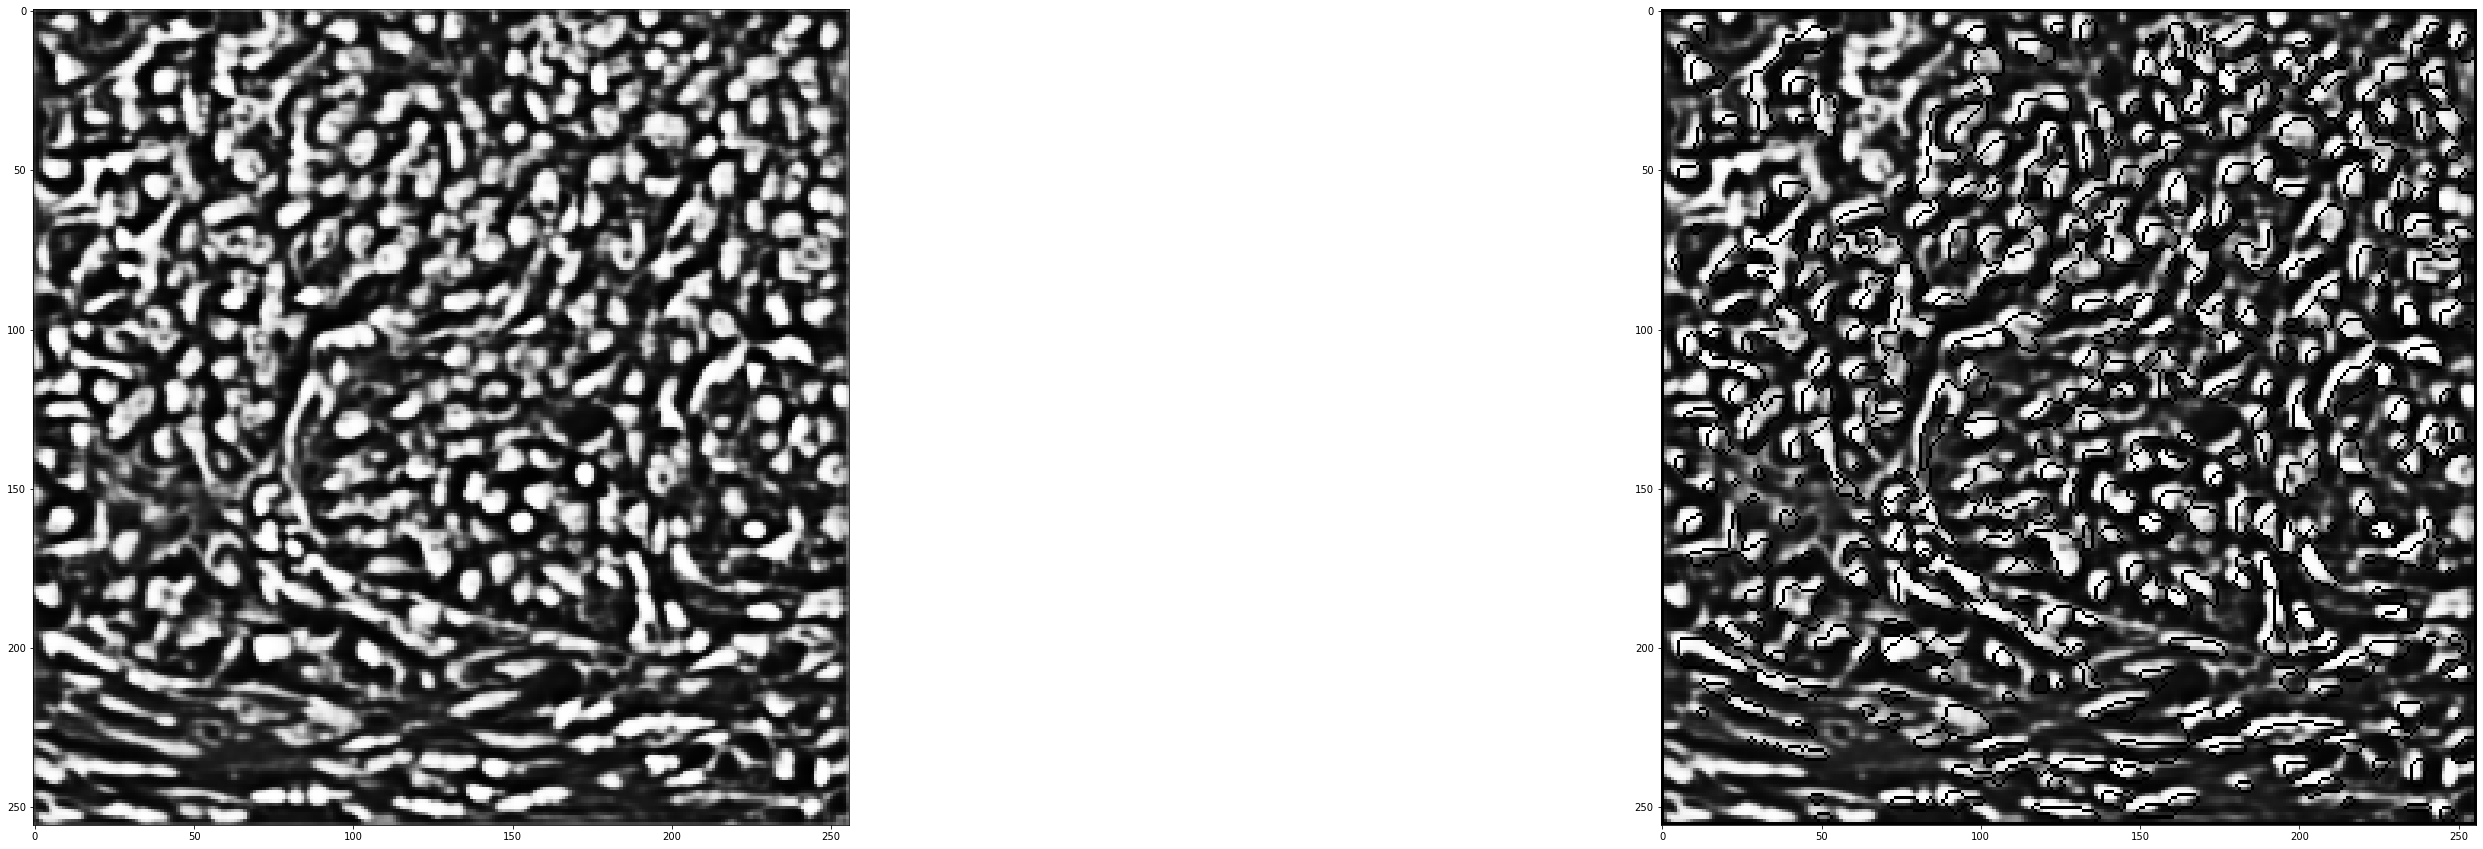

In [ ]:
img_3channel = np.dstack((img, img, img)) #Converting PMF dimension from (256,256) to (256,256,3)
markers = cv2.watershed(img_3channel.astype(np.uint8), markers) #Applyting Watershed algorithm on the PMF using the markers obtained
#The boundary region will be marked 0
img_3channel[markers == -1] = [0,0,0] #Overwriting the edges obtained from watershed to zero

#Plotting the PMF obtained from our UNet Model before and after using Watershed algorithm
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(img, (image_size, image_size)), cmap = 'gray')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(img_3channel.astype(np.uint8))

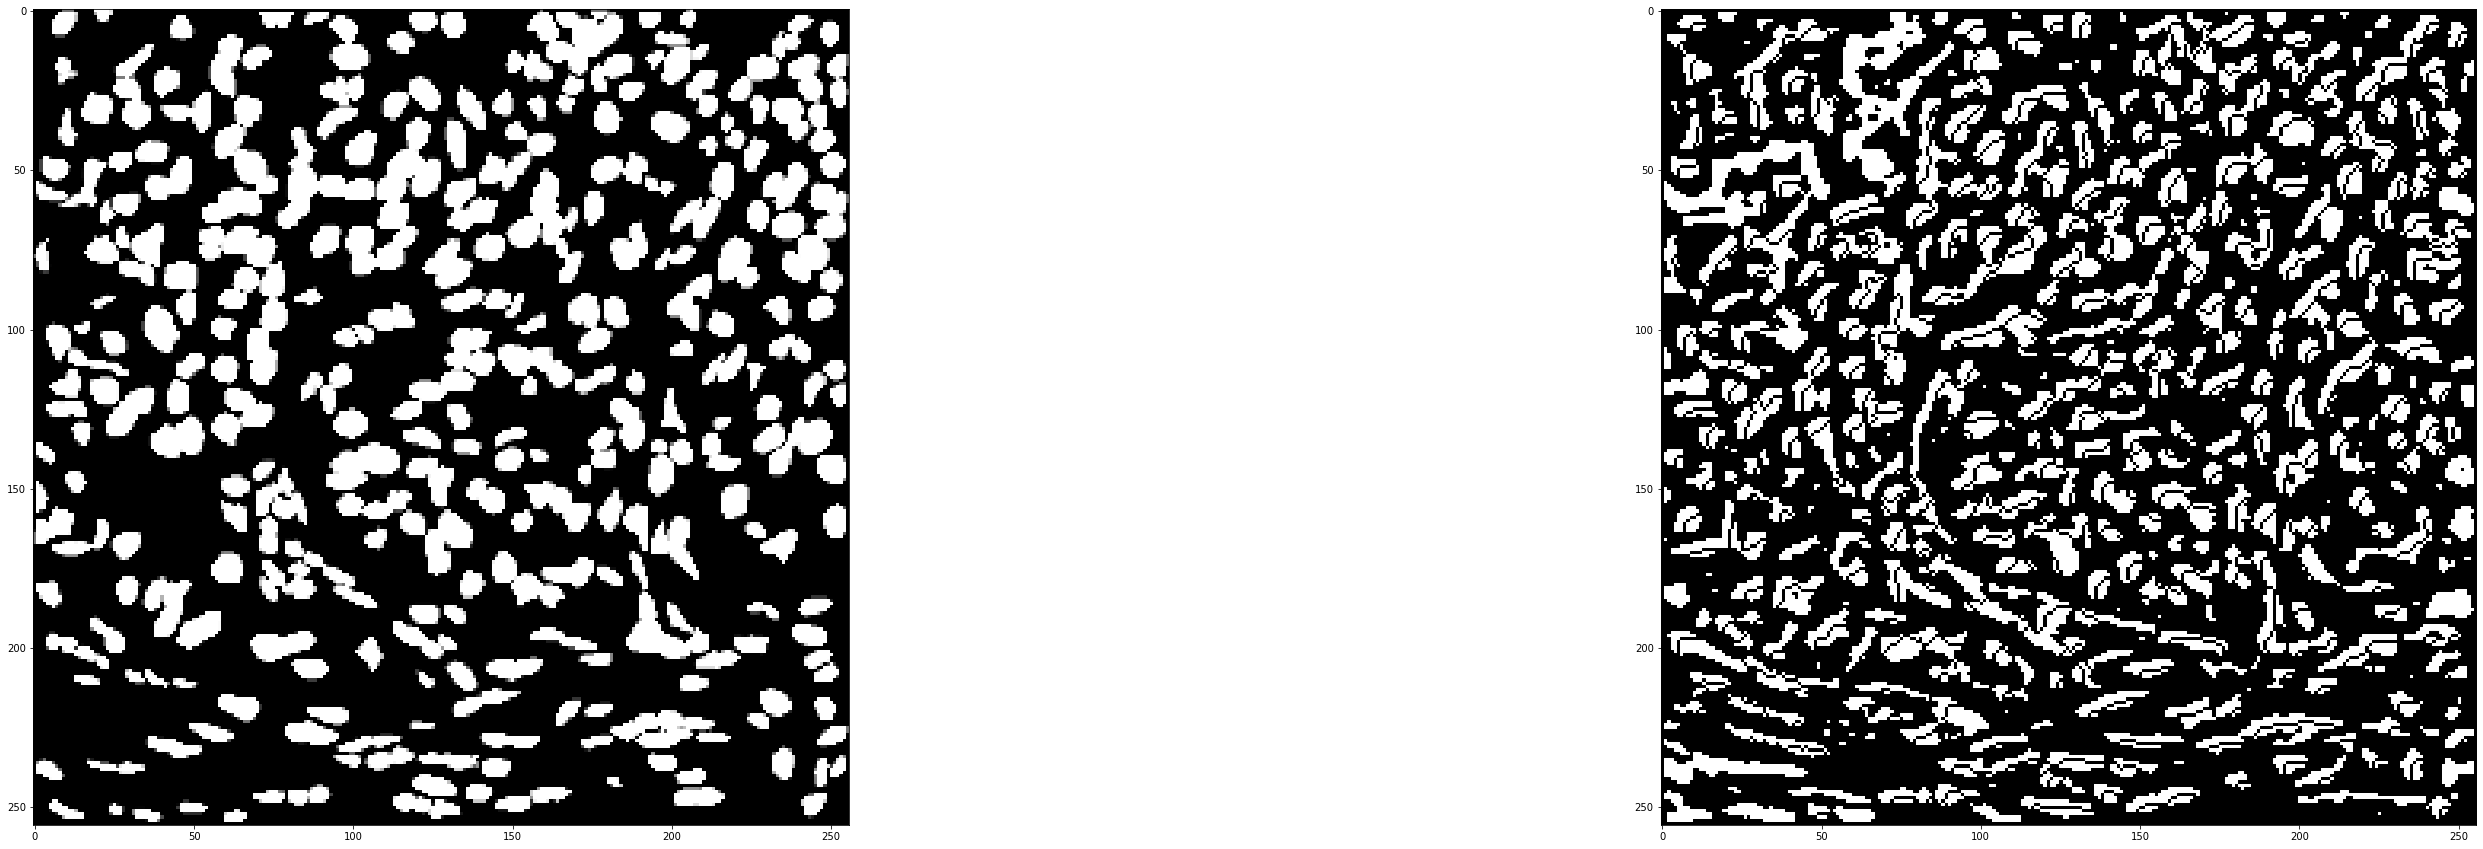

In [ ]:
# Applying CV2 threshold on the Image obtained after applying Watershed algorithm
thresh_val, watershed_img = cv2.threshold(img_3channel[:,:,0].astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


#Plotting the Mask obtained from our UNet Model before and after using Watershed algorithm
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(y[0], cmap = 'gray')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(watershed_img, cmap = 'gray')

### The results obtained after watershed algorithm are somewhat better yet not sufficient for our analysis. We shall improve the parameters to derive better results.

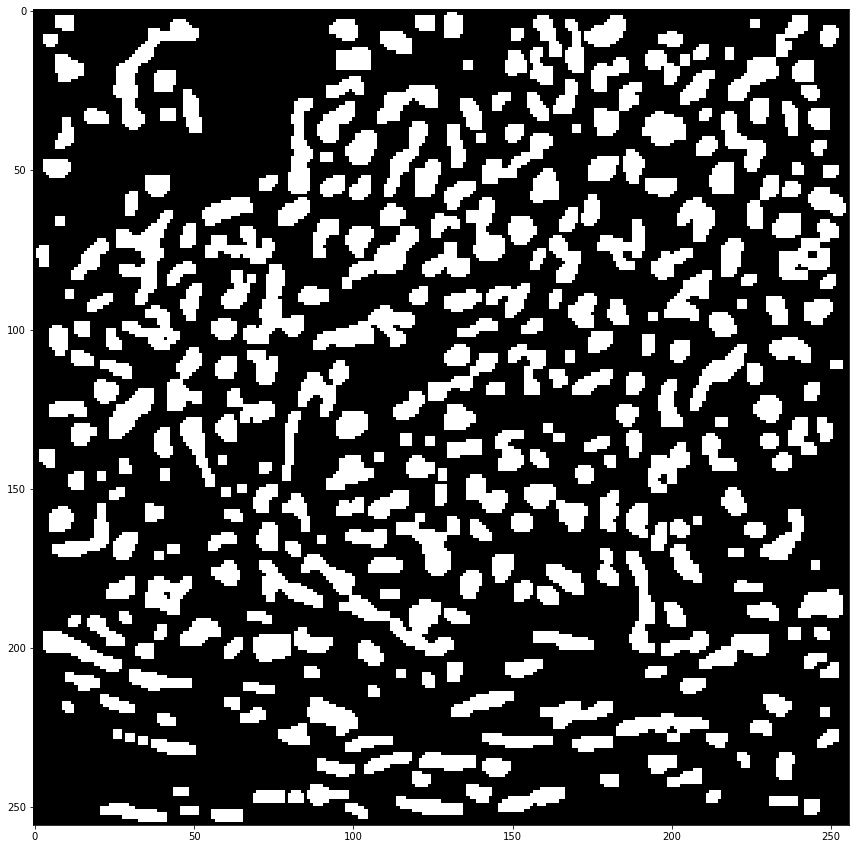

In [ ]:
# Morphological operations to remove small noise - opening

kernel = np.ones((3,3),np.uint8) #Using a 3x3 Kernel this time to create openings
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1) #Number of Itereations is set to 1 this time

from skimage.segmentation import clear_border
opening = clear_border(opening) #Remove edge touching grains.

#Plotting image obtained after Opening
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(opening, (image_size, image_size)), cmap="gray")
plt.show()

Defining the region we are sure of as the background

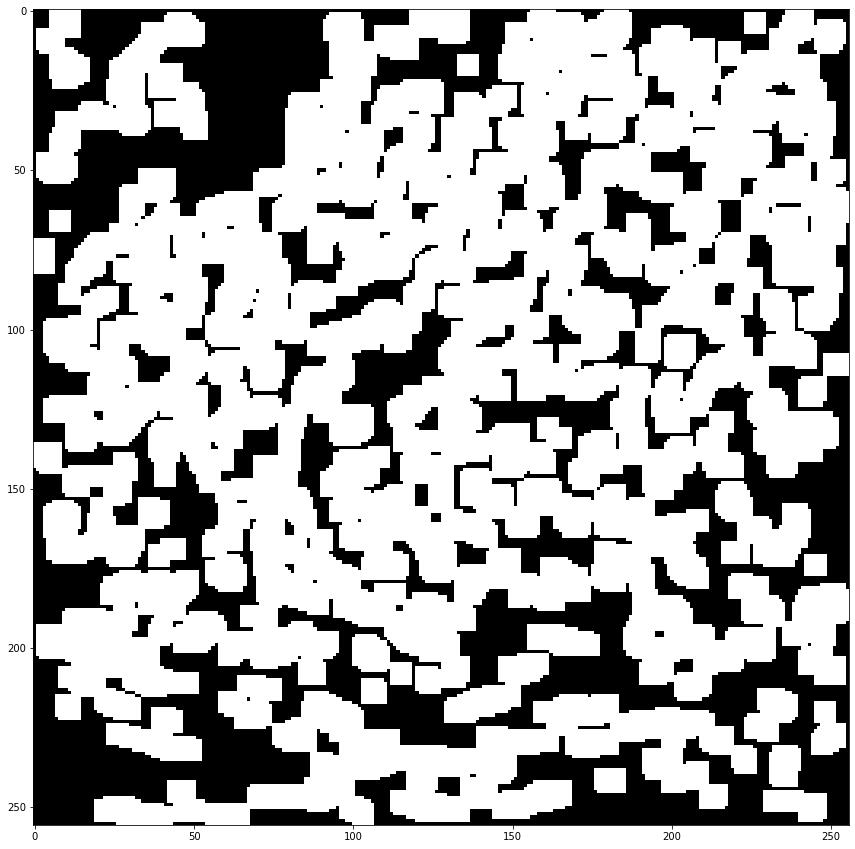

In [ ]:
sure_bg = cv2.dilate(opening,kernel,iterations=2) # Sure background obtained upon dilating the image abtained after opening
#Number of Itereations is set to 3 this time

# Plotting the Sure Background
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(sure_bg, (image_size, image_size)), cmap="gray")
plt.show()

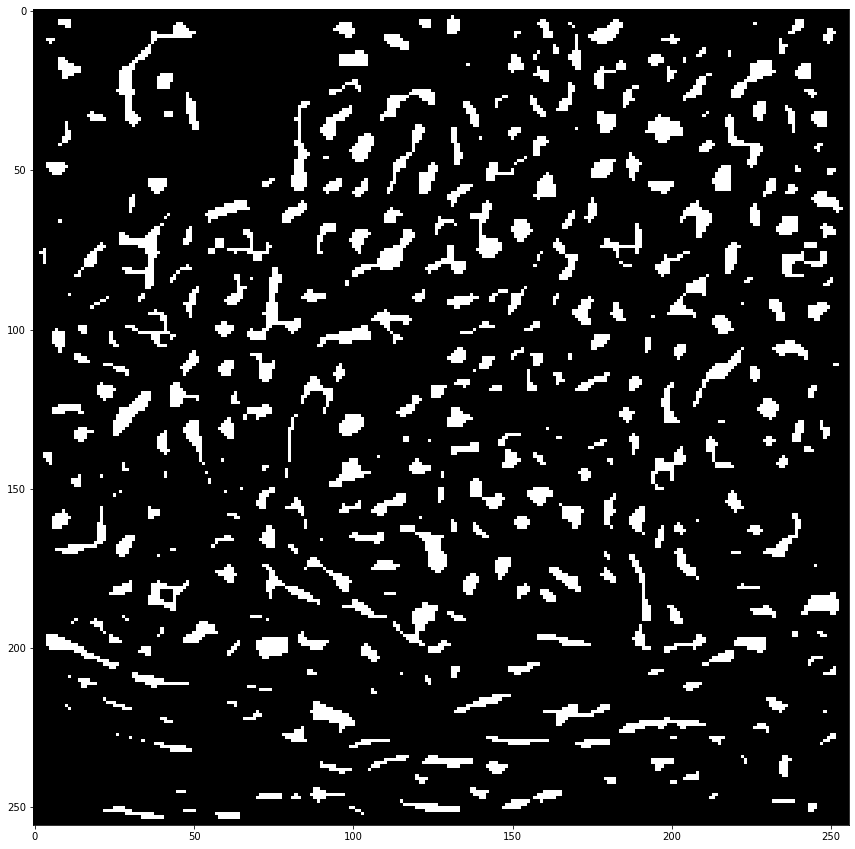

In [ ]:
# Finding sure foreground area using distance transform and thresholding
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
thresh_val2, sure_fg = cv2.threshold(dist_transform, 0.3*dist_transform.max(),255,0) #We can threshold the dist_transform to various values
#Let's take 0.3 times its maximum value

#Plotting the Sure Foreground
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(sure_fg, (image_size, image_size)), cmap="gray")
plt.show()

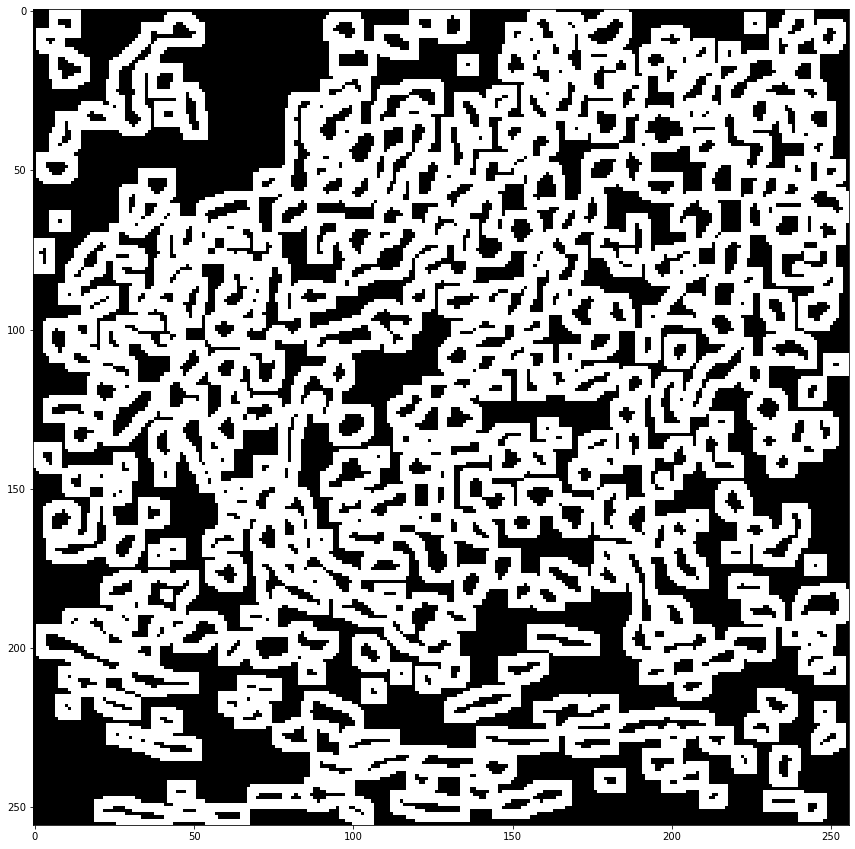

In [ ]:
# Unknown ambiguous region is background - foreground
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg) #Subtracting Sure_bg and Sure_fg

#Plotting the Unknown regions
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(unknown, (image_size, image_size)), cmap="gray")
plt.show()

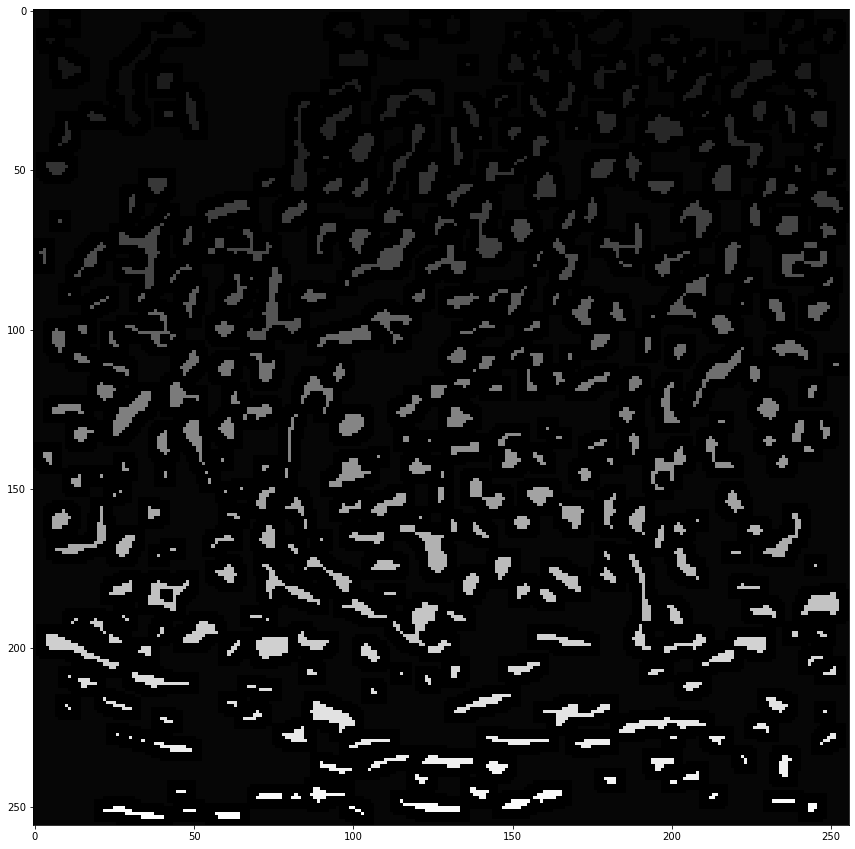

In [ ]:
# For sure regions, both foreground and background will be labeled with positive numbers.
# Unknown regions will be labeled 0.
ret1, markers = cv2.connectedComponents(sure_fg)

# entire background pixels is given value 0, adding 10 to all labels so that sure background is not 0, but 10 and only unknown region is 0
markers = markers+10

## Making the unknown area as 0
markers[unknown == 255] = 0

#Plotting the Makrkers of individual segemeted Nuclei
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(markers, (image_size, image_size)), cmap="gray")
plt.show()

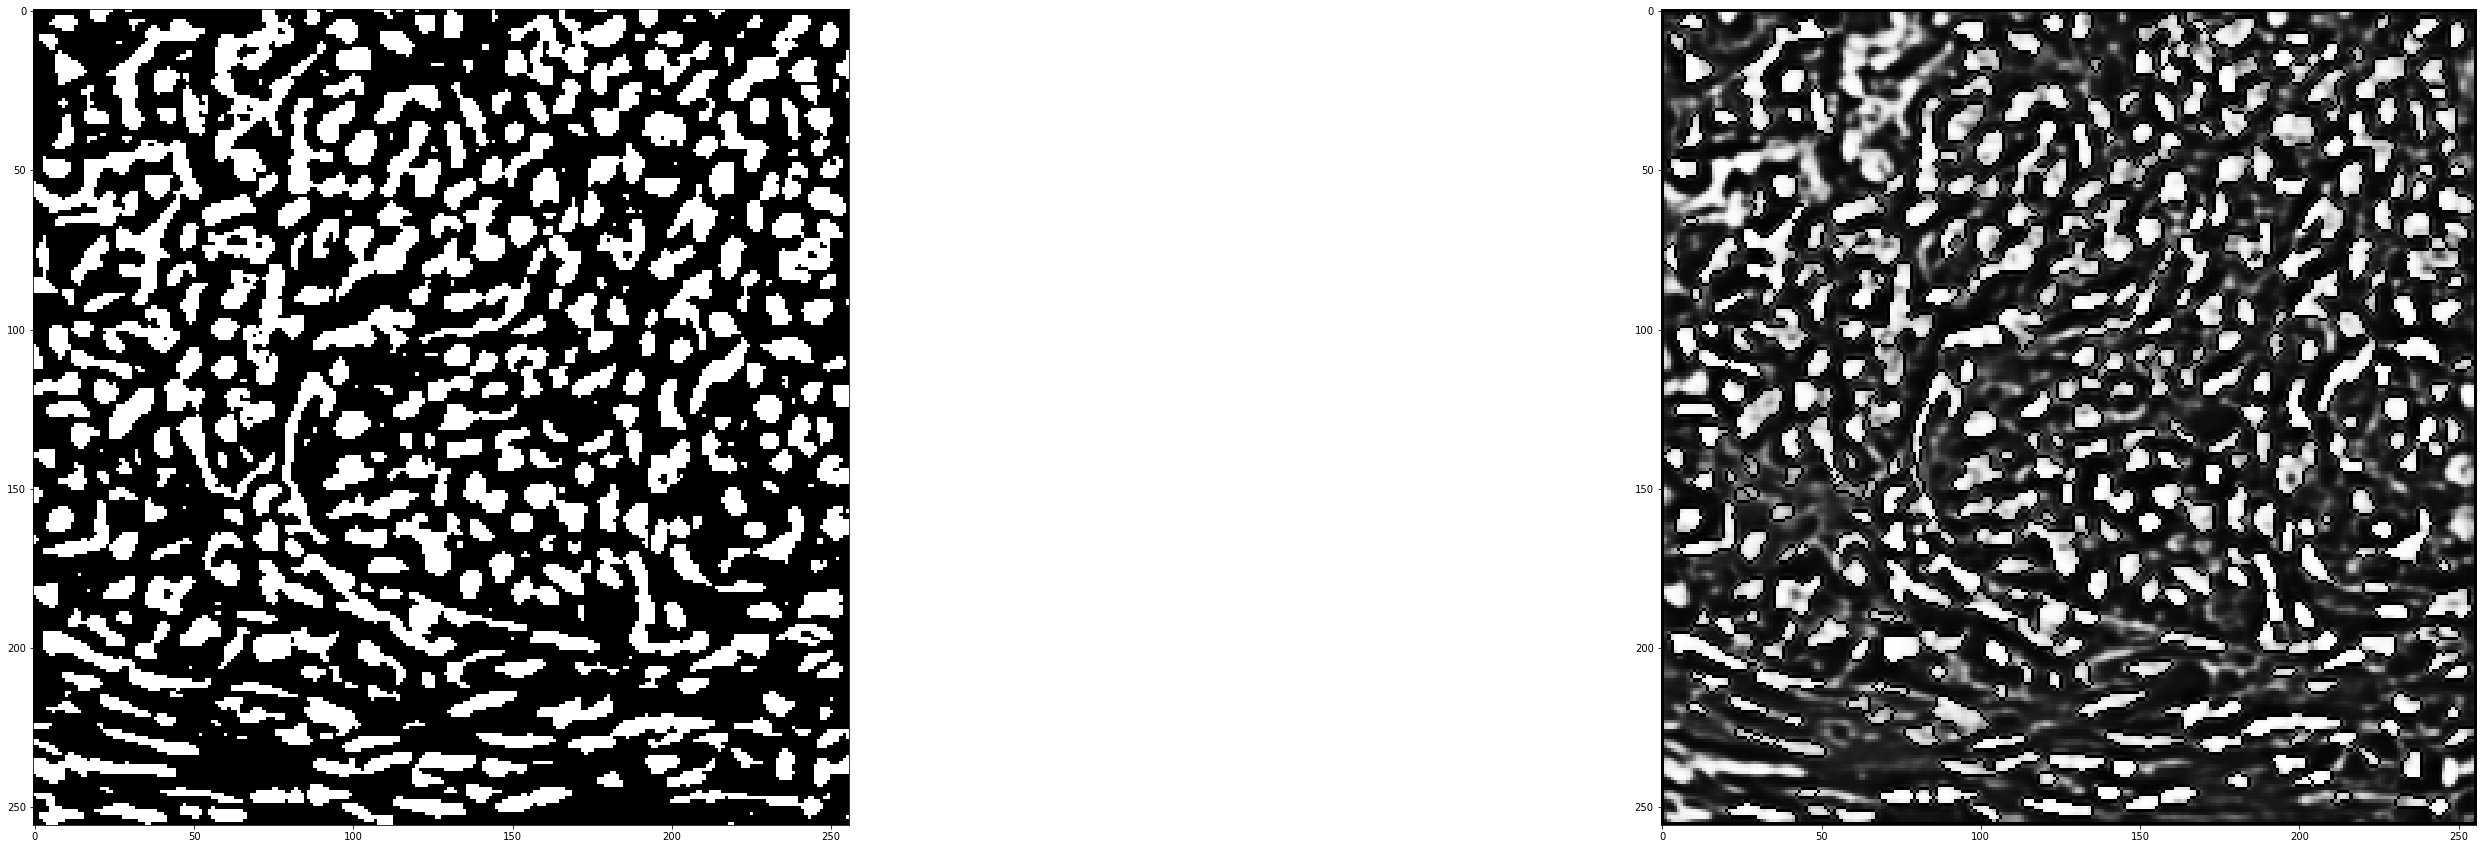

In [ ]:
img_3channel = np.dstack((img, img, img)) #Converting PMF dimension from (256,256) to (256,256,3)
markers = cv2.watershed(img_3channel.astype(np.uint8), markers)#Applyting Watershed algorithm on the PMF using the markers obtained
#The boundary region will be marked 0

img_3channel[markers == -1] = [0,0,0]  #Overwriting the edges obtained from watershed to zero

#Plotting the PMF obtained from our UNet Model before and after using Watershed algorithm
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(segmented, (image_size, image_size)), cmap = 'gray')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(img_3channel.astype(np.uint8))

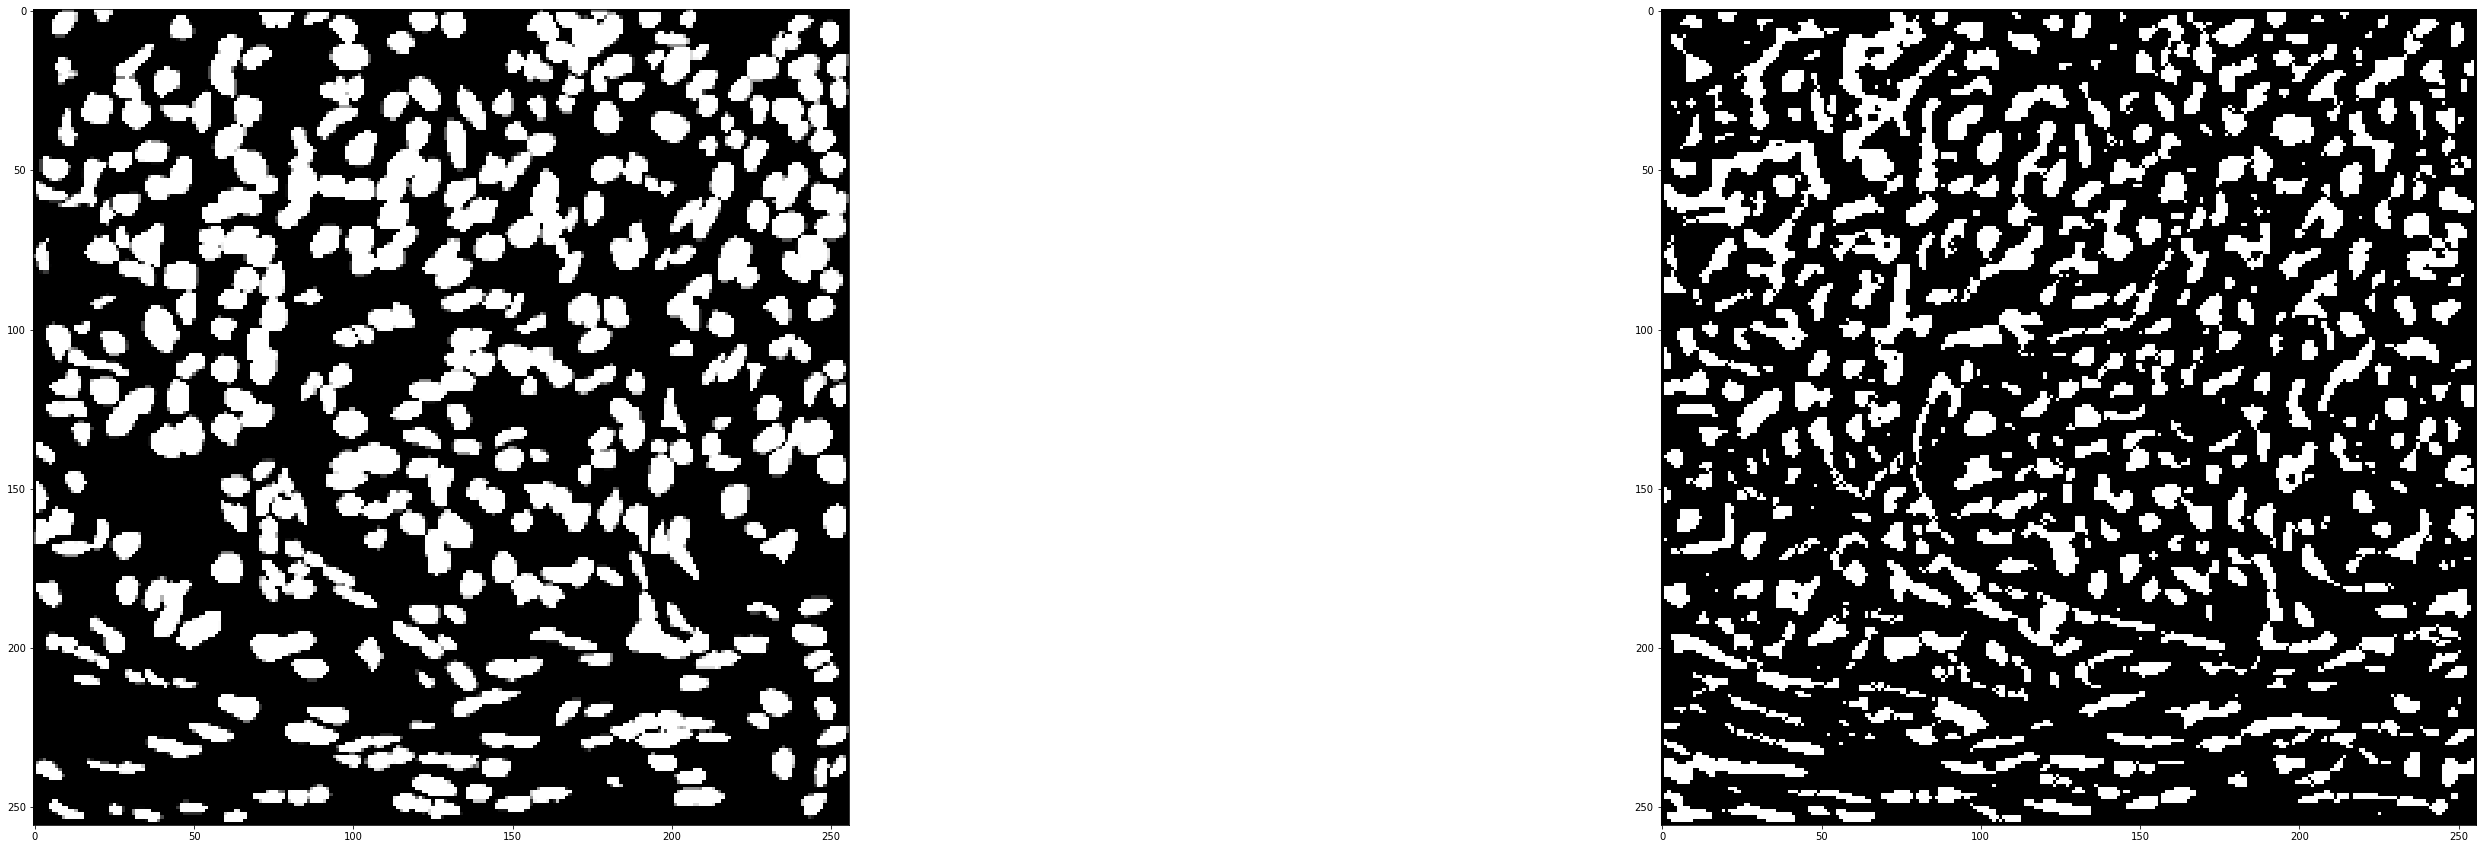

In [ ]:
# Applying CV2 threshold on the Image obtained after applying Watershed algorithm
thresh_val, watershed_img = cv2.threshold(img_3channel[:,:,0].astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#Plotting the Mask obtained from our UNet Model before and after using Watershed algorithm
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(y[0], cmap = 'gray')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(watershed_img, cmap = 'gray')

### Tweaking our parameters like this has produced much better results. Many nuclei which were previously segmented together are now segmented seperately so that we can distinguish between the two.

## References and Sources of inspiration:
- Prof. Amit Sethi's lectures and slides
- Sources recommended by Prof. Amit Sethi:
    - Lectures on Machine Learning and Deep Learining
    - Idiot Developer (https://www.youtube.com/watch?v=M3EZS__Z_XE)
- Theory and Implementation of UNet Model:
    - U-Net: Convolutional Networks for Biomedical Image Segmentation ny Ronneberger et al https://arxiv.org/pdf/1505.04597.pdf
    - https://blog.paperspace.com/unet-architecture-image-segmentation/#table-of-contents
    - https://www.jeremyjordan.me/semantic-segmentation/
- Watershed Algorithm:
    - https://www.aegissofttech.com/articles/watershed-algorithm-and-limitations.html
    - https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html

### Footnotes
- The image is intentionally resized to 256. Primary reason being that the image size should be a power of 2 as the U-Net downsamples the image with a factor of 2 with each downsampling layer. If the image size isn't a power of 2, then we end up losing boundary pixels.
- Secondary reason being that an image of size any power of 2 bigger than 256, for example 512 can't be used to train the U-net model due to memory(RAM) limitations while working in Colab.
- The images we use have a large number of small segments which upon resizing the image to almost 1/4th its original dimension, reduce their distintiveness. If images could be used in higher resolution, we could have seen much better results being generated by our DL model
- The watershed algorithm isn't very effective in our case to make the results better as the individual segments (nuclei) are already very small (in pixels) and have sharp boundaries. Watershed algorithm is much better at detecting smooth boundaries between two nearby objects but as our output PMF has many 'basins' (refer to https://media5.datahacker.rs/2020/10/7-2.jpg), the watershed algorithm, isn't nearly as effective